# Dataset Generation for AP-axis analysis

What are the genetic and regulatory mechanisms that drive the intense proliferation from the spinal-cord to the 
forebrain in bilateria?

We know that the silencing of the Hox genes in the forebrain facilitates the growth of the tissue, however, do the 
Hox genes act in isolation? Or are there other genes that exhibit the same phenotype and thus, may be equally integral
to this process?

By removing the silencing mechanism (H3K27me3) we investigate which genes, act in a similar manner by integrating the 
RNAseq response to the knockout with epigenetic data.


#### Cells appendix:

    1) Imports
    2) RNAseq merging files
    3) Add annotation information
    4) Save dataframe combinations to csv files for DE analysis
    5) Run R scripts a. DeSEQ2 & b. Normalisation (in R) plot results from normalisation
    6) Plot results from DEseq2
    7) Make bar chart of all comparisons (i.e. how many DE genes in each comaprison)
    8) Select log2(TMM + 1) as normalisation and build merged dataframe (raw + DEseq2 results)
    9) Visualise the merged data top most significant genes (Heatmap and PCA) 
    10) Add histone modification data from Encode (downloaded & processed in APaxis_encodeDataDownload)
    11) Filter the merged dataframe (i.e. for significant results)

## 1) Imports

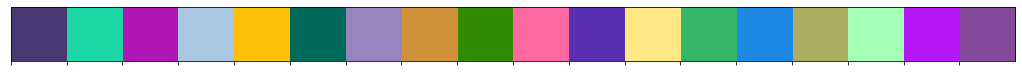

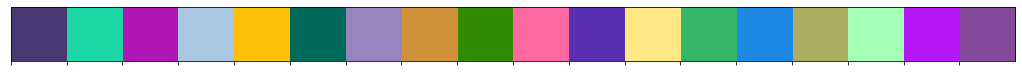

In [1]:
"""
--------------------------------------------------------
Import RNAseq data & merge featureCounts files
--------------------------------------------------------
"""

import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib_venn import venn3

from sciviso import *
from sciutil import SciUtil

u = SciUtil()

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)


"""
--------------------------------------------------------
                     Global variables
--------------------------------------------------------
"""
date = '20210124'

gene_id = 'entrezgene_id'
gene_name = 'external_gene_name'

sci_colour = ['#483873', '#1BD8A6', '#B117B7', '#AAC7E2', '#FFC107', '#016957', '#9785C0', 
             '#D09139', '#338A03', '#FF69A1', '#5930B1', '#FFE884', '#35B567', '#1E88E5', 
             '#ACAD60', '#A2FFB4', '#B618F5', '#854A9C']

hist_colour = '#483873'

e11_colour = 'white'
e13_colour = 'lightgrey'
e15_colour = '#A7A9AC'
e18_colour = '#58595B'

fb_colour = '#ffbf80'
mb_colour = '#ff8c1a'
hb_colour = '#b35900'
sc_colour = '#663300'
grey = '#bdbdbd'

h3k36me3_colour = '#CEF471'
h3k27me3_colour = '#9F71F4'
h3k4me3_colour = '#9F00FA'
h3k4me2_colour = '#5930B1'
h3k4me1_colour = '#FFE884'
h3k27ac_colour = '#35B567'
h3k9me3_colour = '#1E88E5'
h3k9ac_colour = '#A2FFB4'
           
wt_colour = '#AADFF1'
ko_colour = '#A53736'

sns.palplot(sci_colour)
sns.color_palette(sci_colour)

project_name = 'prelim'

data_dir = '../data/'
r_dir = f'{data_dir}results/deseq2/'
fig_dir = f'../figures/{project_name}/'
output_dir = f'{data_dir}results/{project_name}/'
input_dir = f'{data_dir}input/'
rna_dir = f'{input_dir}feature_counts/'

cmap = 'RdBu_r'
u_id = 'u_id'
sns.palplot(sci_colour)
sns.color_palette(sci_colour)

def get_time_colour(c):
    if '11' in c or '10' in c:
        return e11_colour
    elif '13' in c or '12' in c:
        return e13_colour
    elif '15' in c or '14' in c:
        return e15_colour
    elif '18' in c or '16' in c:
        return e18_colour
    return '#FFFFFF'

def get_tissue_colour(c):
    if 'sc' in c or 'spinal' in c:
        return sc_colour
    elif 'hb' in c or 'hindbrain' in c:
        return hb_colour
    elif 'mb' in c or 'midbrain' in c:
        return mb_colour
    elif 'fb' in c or 'forebrain' in c:
        return fb_colour
    return '#FFFFFF'

def get_cond_colour(c):
    if 'ko' in c:
        return ko_colour
    elif 'wt' in c:
        return wt_colour
    return '#FFFFFF'

def get_mark_colour(c):
    if '36me3' in c:
        return h3k36me3_colour
    elif '27me3' in c:
        return h3k27me3_colour
    elif 'K4me3' in c:
        return h3k4me3_colour
    elif 'K4me2' in c:
        return h3k4me2_colour
    elif 'K4me1' in c:
        return h3k4me1_colour
    elif '27ac' in c:
        return h3k27ac_colour
    elif 'K9me3' in c:
        return h3k9me3_colour
    elif 'K9ac' in c:
        return h3k9ac_colour
    return '#FFFFFF'

def pplot():
    plt.rcParams['figure.figsize'] = [5, 4]
    plt.rcParams['image.cmap'] = cmap
    plt.rcParams['svg.fonttype'] = 'none'
        
def cplot():
    plt.rcParams['figure.figsize'] = [6, 4]
    sns.color_palette(sci_colour)
    
def save_fig(title, ending='.svg'):
    plt.savefig(f'{fig_dir}{title.replace(" ", "-")}{ending}')
    

## 2) RNAseq merging files

Here we import the results from our FeatureCounts data. We merge the files together on their entrez ID.

In [2]:
files = os.listdir(rna_dir)

rna_files = []
for f in files:
    if 'summary' not in f:
        rna_files.append(f)

# Make a df out of all expression data
rna_files.sort()
df = pd.DataFrame()
        
# Basically want to create a dummy df since we don't want the columns except the expression
# and the entrez gene id
tmp_df = pd.read_csv(f'{rna_dir}{rna_files[0]}', sep='\t', header=1)

df['Geneid'] = tmp_df['Geneid'].values
df[rna_files[0][:-4]] = tmp_df[tmp_df.columns[-1]].values
# Now we'll add all the other RNA files to this dataframe by joining on ID
for filename in rna_files[1:]:
    u.dp(["Adding", filename])
    tmp_df = pd.DataFrame()
    file_df = pd.read_csv(f'{rna_dir}{filename}', sep='\t', header=1)
    print(file_df.head())
    u.dp([f'Length of {filename}: ', len(file_df)])
    tmp_df['Geneid'] = file_df['Geneid'].values
    # Note we take the log transform here 
    tmp_df[filename[:-4]] = file_df[file_df.columns[-1]].values
    df = df.merge(tmp_df, on='Geneid', how='outer')

# Save DF to csv for normalisation 
u.dp(["Length of merged RNAseq dataframe: ", len(df)])

--------------------------------------------------------------------------------
                              Adding	ko11fb2.txt	                               
--------------------------------------------------------------------------------
      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

--------------------------------------------------------------------------------
                              Adding	wt11fb1.txt	                               
--------------------------------------------------------------------------------
      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

--------------------------------------------------------------------------------
                              Adding	wt13hb1.txt	                               
--------------------------------------------------------------------------------
      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

--------------------------------------------------------------------------------
                              Adding	wt15mb2.txt	                               
--------------------------------------------------------------------------------
      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   

      Geneid                            Chr  \
0     497097                 chr1;chr1;chr1   
1  100503874                      chr1;chr1   
2  100038431                           chr1   
3      19888  chr1;chr1;chr1;chr1;chr1;chr1   
4      20671       chr1;chr1;chr1;chr1;chr1   

                                             Start  \
0                          3214482;3421702;3670552   
1                                  3647309;3658847   
2                                          3680155   
3  4290846;4343507;4351910;4352202;4360200;4409170   
4          4490928;4493100;4493772;4495136;4496291   

                                               End       Strand  Length  \
0                          3216968;3421901;3671498        -;-;-    3634   
1                                  3650509;3658904          -;-    3259   
2                                          3681788            +    1634   
3  4293012;4350091;4352081;4352837;4360314;4409241  -;-;-;-;-;-    9747   
4          449266

## 3) Add annotation information

We add annotation information to the genes: name, etc. This will also allow us to merge with our ChIP data which 
have been annotated with ensembl IDs.  

We also want to save the merged dataframe to CSV files (grouped by the *tissue*) as then we will run DeSEQ2 on these 
count files.

In [3]:
"""
--------------------------------------------------------
Add annotation to RNAseq dataframe & save Tissue counts as files.
--------------------------------------------------------
"""
# Lastly let's add some gene annotation information

"""
Annotations were generated using scibiomart v1.0.0 CLI

scibiomart --m ENSEMBL_MART_ENSEMBL --d mmusculus_gene_ensembl --a "ensembl_gene_id,entrezgene_id,external_gene_name,chromosome_name,start_position,end_position,strand" --o mm10Sorted_ --s t

"""

# Remove data that were not able to be annotated to gene names (i.e. these are usually the genes which are "unknown")

annot_df = pd.read_csv(os.path.join(input_dir, 'supps', 'mm10Sorted_mmusculus_gene_ensembl-GRCm38.p6.csv'))
gene_names = annot_df[gene_name].values
gene_id_to_name = {}
for i, g in enumerate(annot_df[gene_id].values):
    if not gene_id_to_name.get(g):
        gene_id_to_name[g] = gene_names[i]

# add these to the df column
gene_names = []
pseudo_id = []
df = df.rename(columns={'Geneid': 'entrezgene_id'})

for g in df[gene_id].values:
    gene_n = gene_id_to_name.get(g)
    gene_names.append(gene_n)
    pseudo_id.append(f'{g}-{gene_n}')
df[gene_name] = gene_names
df['u_id'] = pseudo_id

# Organise columns a bit nicer
cols = [gene_id, gene_name, 'u_id',
        'ko11fb1', 'ko11fb2', 'ko13fb1', 'ko13fb2', 'ko15fb1', 'ko15fb2', 'ko18fb1', 'ko18fb2',
        'ko11mb1', 'ko11mb2', 'ko13mb1', 'ko13mb2', 'ko15mb1', 'ko15mb2', 'ko18mb1', 'ko18mb2',
        'ko11hb1', 'ko11hb2', 'ko13hb1', 'ko13hb2', 'ko15hb1', 'ko15hb2', 'ko18hb1', 'ko18hb2',
        'ko11sc1', 'ko11sc2', 'ko13sc1', 'ko13sc2', 'ko15sc1', 'ko15sc2', 'ko18sc1', 'ko18sc2',
         'wt11fb1', 'wt11fb2', 'wt13fb1', 'wt13fb2', 'wt15fb1', 'wt15fb2', 'wt18fb1', 'wt18fb2',
        'wt11mb1', 'wt11mb2', 'wt13mb1', 'wt13mb2', 'wt15mb1', 'wt15mb2', 'wt18mb1', 'wt18mb2',
        'wt11hb1', 'wt11hb2', 'wt13hb1', 'wt13hb2', 'wt15hb1', 'wt15hb2', 'wt18hb1', 'wt18hb2',
        'wt11sc1', 'wt11sc2', 'wt13sc1', 'wt13sc2', 'wt15sc1', 'wt15sc2', 'wt18sc1', 'wt18sc2'
]

df = df[cols]
u.dp(["Number of genes in total:", len(df)])
# Remove the values that don't map to a gene name. On investigation these are 
# most commonly predicted genes, or non-coding RNA (which we don't expect to have messenger RNA for)
# for example: 2610203C22Rik RIKEN cDNA 2610203C22 gene [ Mus musculus (house mouse) ]
# There were about 6000 genes. None of which had a logFC > 2 with the majority having 0 LogFC
df = df[df[gene_name].values != None]
u.dp(["Number of genes with gene names:", len(df)])
df.to_csv(f'{output_dir}merged_df_FEATURE_COUNTS_annot_{date}.csv', index=False)

--------------------------------------------------------------------------------
                        Number of genes in total:	27179	                        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                    Number of genes with gene names:	20900	                     
--------------------------------------------------------------------------------


## 4) Save dataframe combinations to csv files

Here we just save each combination that we want to run DE on to a CSV file.

In [5]:
"""
Save dataframe combinations to CSV files to do DEseq2 analysis
"""

# Create DF for each tissue
tissues = ['fb', 'mb', 'hb', 'sc']
for t in tissues:
    ts = [u_id]
    for c in df.columns:
        if t in c and '11' not in c and 'id' not in c:
            ts.append(c)
    t_df = df[ts]
    t_df.to_csv(f'{r_dir}merged_df_{t}_FEATURE_COUNTS_{date}.csv', index=False)
    
# Create DF for each timepoint
times = ['11', '13', '15', '18']
for t in times:
    ts = [u_id]
    for c in df.columns:
        if t in c and 'id' not in c and ('fb' in c or 'mb' in c):
            ts.append(c)
    t_df = df[ts]
    t_df.to_csv(f'{r_dir}merged_df_anterior_{t}_FEATURE_COUNTS_{date}.csv', index=False)

for t in times:
    ts = [u_id]
    for c in df.columns:
        if t in c and 'id' not in c and ('sc' in c or 'hb' in c):
            ts.append(c)
    t_df = df[ts]
    t_df.to_csv(f'{r_dir}merged_df_posterior_{t}_FEATURE_COUNTS_{date}.csv', index=False)

    
# Create df for all the data (including e11)
columns = [gene_id]
for c in df.columns:
    if 'wt' in c or 'ko' in c:
        columns.append(c)
df[columns].to_csv(f'{r_dir}merged_df_FEATURE_COUNTS_{date}.csv', index=False)

# Create combo between each tissue (i.e sc vs mb)
def gen_csv_combo(cond1, cond2):
    condition = ['wt', 'ko']
    for t in condition:
        ts = [u_id]
        for c in df.columns:
            if t in c and (cond1 in c or cond2 in c) and gene_id != c and gene_name != c and '11' not in c:
                ts.append(c)
        t_df = df[ts]
        t_df.to_csv(f'{r_dir}merged_df_{t}_{cond1}-{cond2}_FEATURE_COUNTS_{date}.csv', index=False)
        u.dp(["Cond done:", f'{t}_{cond1}-{cond2}'])

def gen_csv_combo_time(cond1, cond2):
    condition = ['wt', 'ko']
    for t in condition:
        ts = [u_id]
        for c in df.columns:
            if t in c and (cond1 in c or cond2 in c) and gene_id != c and gene_name != c and ('sc' in c or 'hb' in c):
                ts.append(c)
        t_df = df[ts]
        t_df.to_csv(f'{r_dir}merged_df_posterior_{t}_{cond1}-{cond2}_FEATURE_COUNTS_{date}.csv', index=False)
        u.dp(["Cond done:", f'posterior_{t}_{cond1}-{cond2}'])

    for t in condition:
        ts = [u_id]
        for c in df.columns:
            if t in c and (cond1 in c or cond2 in c) and gene_id != c and gene_name != c and ('fb' in c or 'mb' in c):
                ts.append(c)
        t_df = df[ts]
        t_df.to_csv(f'{r_dir}merged_df_anterior_{t}_{cond1}-{cond2}_FEATURE_COUNTS_{date}.csv', index=False)
        u.dp(["Cond done:", f'anterior_{t}_{cond1}-{cond2}'])
        
gen_csv_combo('fb', 'mb')
gen_csv_combo('fb', 'hb')
gen_csv_combo('fb', 'sc')
gen_csv_combo('mb', 'sc')
gen_csv_combo('mb', 'hb')
gen_csv_combo('hb', 'sc')
gen_csv_combo_time('11', '18')
gen_csv_combo_time('11', '13')
gen_csv_combo_time('13', '18')
gen_csv_combo_time('15', '18')
gen_csv_combo_time('11', '15')
gen_csv_combo_time('13', '15')

df.to_csv(f'{r_dir}merged_df_FEATURE_COUNTS_annot_{date}.csv', index=False)

u.dp(["Combinations generated!"])



--------------------------------------------------------------------------------
                              Cond done:	wt_fb-mb	                              
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                              Cond done:	ko_fb-mb	                              
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                              Cond done:	wt_fb-hb	                              
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                              Cond done:	ko_fb-hb	                              
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
                         Cond done:	posterior_wt_13-15	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Cond done:	posterior_ko_13-15	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Cond done:	anterior_wt_13-15	                          
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Cond done:	anterior_ko_13-15	                          
--------------------------------------------------------------------------------
----------------------------

## 5) Run R scripts a. DeSEQ2 & b. Normalisation

Here we need to step out of this notebook and run the following R markdowns:

    2) Run Deseq2 (apAxis_between-cond-tissue.Rmd, apAxis_between-time.Rmd, apAxis_between-tissue.Rmd)
    3) Normalise the data (apAxis_between-cond-tissue.Rmd)

Prior to running our analysis, we need to normalise the RNAseq data. Given we're interested in integrating the changes across the genes, we use EdgeRs TMM method.

### Script below for normalisation

```
Run script in file: apAxis_between-cond-tissue.Rmd
```


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


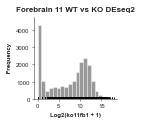

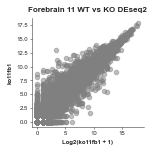

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


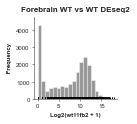

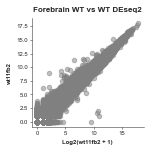

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


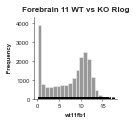

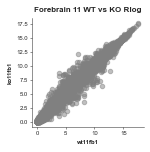

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


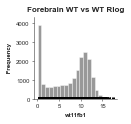

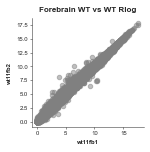

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


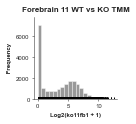

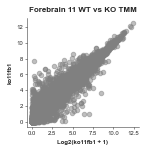

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


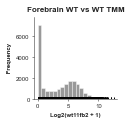

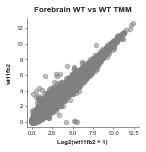

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


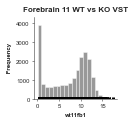

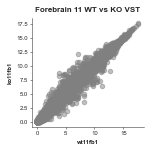

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


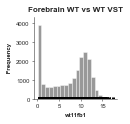

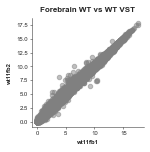

In [4]:
"""
--------------------------------------------------------
Display the normalisations 
--------------------------------------------------------
"""
%matplotlib inline
from sciviso import Histogram, Scatterplot

plot_on = True
plt_on = True
save_on = True
# Show an example of each method's normalisation
def show_scatter(df, cond_x, cond_y, x_label='', y_label='', title='', log2=False, offset=1, annotations=None): 
    a = 0.1
    offset = 1
    plt_df = pd.DataFrame()
    x = cond_x
    y = cond_y
    if log2:
        x = f'Log2({cond_x} + {offset})'
        x = f'Log2({cond_y} + {offset})'
        plt_df[x] = np.log2(df[cond_x].values + offset)
        plt_df[y] = np.log2(df[cond_y].values + offset)
    else:
        plt_df[x] = df[cond_x].values 
        plt_df[y] = df[cond_y].values
    
    # plot histogram 
    h = Histogram(plt_df, x, title=title, fit_norm=False, plot_rug=True, xlabel=x)
    h.plot()
    save_fig(f'Hist_{x}_{title}', ending='.pdf')
    plt.show()
    # now run the scatter
    s = Scatterplot(plt_df, x, y, title=title, xlabel=x, ylabel=y, colour="grey", add_legend=False)
    s.opacity=0.5
    s.plot()
    save_fig(f'Scatter_{x}-{y}_{title}', ending='.pdf')
    plt.show()

    
deseq2 = pd.read_csv(f'{r_dir}merged_df_FEATURE_COUNTS_DEseq2Norm_{date}.csv')
rlog = pd.read_csv(f'{r_dir}merged_df_FEATURE_COUNTS_rlog_{date}.csv')
tmm = pd.read_csv(f'{r_dir}merged_df_FEATURE_COUNTS_tmm_{date}.csv')
vst = pd.read_csv(f'{r_dir}merged_df_FEATURE_COUNTS_vst_{date}.csv')

sc_genes = None
show_scatter(deseq2, 'wt11fb1', 'ko11fb1', 'wt11fb1', 'ko11fb1', 'Forebrain 11 WT vs KO DEseq2', True, 1.0, sc_genes)
show_scatter(deseq2, 'wt11fb1', 'wt11fb2', 'wt11fb1', 'wt11fb2', 'Forebrain WT vs WT DEseq2', True, 1.0, sc_genes)
show_scatter(rlog, 'wt11fb1', 'ko11fb1', 'wt11fb1', 'ko11fb1', 'Forebrain 11 WT vs KO Rlog', False, 1.0, sc_genes)
show_scatter(rlog, 'wt11fb1', 'wt11fb2', 'wt11fb1', 'wt11fb2', 'Forebrain WT vs WT Rlog', False, 1.0, sc_genes)
show_scatter(tmm, 'wt11fb1', 'ko11fb1', 'wt11fb1', 'ko11fb1', 'Forebrain 11 WT vs KO TMM', True, 1.0, sc_genes)
show_scatter(tmm, 'wt11fb1', 'wt11fb2', 'wt11fb1', 'wt11fb2', 'Forebrain WT vs WT TMM', True, 1.0, sc_genes)
show_scatter(vst, 'wt11fb1', 'ko11fb1', 'wt11fb1', 'ko11fb1', 'Forebrain 11 WT vs KO VST', False, 1.0, sc_genes)
show_scatter(vst, 'wt11fb1', 'wt11fb2', 'wt11fb1', 'wt11fb2', 'Forebrain WT vs WT VST', False, 1.0, sc_genes)

## 6) Plot results from DEseq2

Here we want to do the normal figures for a DE analysis i.e. volcano plots, heatmaps, & Venn diagrams etc.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from adjustText import adjust_text

from sciviso import Vis


class Volcanoplot(Vis):

    def __init__(self, df: pd.DataFrame, log_fc: str, p_val: str, label_column: str, title='',
                 xlabel='', ylabel='', invert=False, p_val_cutoff=0.05,
                 log_fc_cuttoff=2, label_big_sig=False, colours=None, offset=None,
                 text_colours=None, values_to_label=None, max_labels=20, values_colours=None,
                 figsize=(2, 2), title_font_size=8, label_font_size=6, title_font_weight=700):
        super().__init__(df, figsize=figsize, title_font_size=title_font_size, label_font_size=label_font_size,
                         title_font_weight=title_font_weight)
        super().__init__(df)
        self.log_fc = log_fc
        self.p_val = p_val
        self.p_val_cutoff = p_val_cutoff
        self.log_fc_cuttoff = log_fc_cuttoff
        self.values_to_label = values_to_label
        self.label_big_sig = label_big_sig
        self.invert = invert
        self.label_column = label_column
        self.offset = offset
        self.label = 'volcanoplot'
        self.colours = {'ns_small-neg-logFC': 'lightgrey',
                        'ns_small-pos-logFC': 'lightgrey',
                        'ns_big-neg-logFC': 'grey',
                        'ns_big-pos-logFC': 'grey',
                        'sig_small-neg-logFC': '#ccddff',
                        'sig_small-pos-logFC': '#ffcccc',
                        'sig_big-neg-logFC': '#6699ff',
                        'sig_big-pos-logFC': '#ff8080'} if colours is None else colours
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title
        self.max_labels = max_labels
        self.figsize = figsize
        self.values_colours = values_colours or {}
        self.text_colours = text_colours or {}

    def add_scatter_and_annotate(self, fig: plt, x_all: np.array, y_all: np.array,
                                 colour: str, idxs: np.array, annotate=False, s=20):
        x = x_all[idxs]
        y = y_all[idxs]
        ax = fig.scatter(x, y, c=colour, alpha=self.opacity, s=s, vmin=-10.0, vmax=10.0)

        # Check if we want to annotate any of these with their gene IDs

        if self.values_to_label is not None:
            texts = []
            labels = self.df[self.label_column].values[idxs]
            for i, name in enumerate(labels):
                if name in self.values_to_label:
                    lbl_bg = self.values_colours.get(name)
                    color = self.text_colours.get(name)
                    texts.append(fig.text(x[i], y[i], name, color=color, fontsize=6,
                                          bbox=dict(fc=lbl_bg, alpha=0.8, boxstyle='round,pad=0.25', lw=0)))
            adjust_text(texts, force_text=2.0)
        # Check if the user wants these labeled
        if self.label_big_sig and annotate:
            # If they do have a limit on the number of ones we show (i.e. we don't want 10000 gene names...)
            max_values = -1 * self.max_labels
            if len(y) < self.max_labels:
                max_values = -1 * (len(y) - 1)
            most_sig_idxs = np.argpartition(y, max_values)[max_values:]
            labels = self.df[self.label_column].values[idxs][most_sig_idxs]
            x = x[most_sig_idxs]
            y = y[most_sig_idxs]
            # We only label the ones with the max log fc
            for i, name in enumerate(labels):
                fig.annotate(name, (x[i], y[i]),
                             xytext=(0, 10),
                             textcoords='offset points', ha='center', va='bottom',
                             bbox=dict(boxstyle='round,pad=0',
                                       fc=None, alpha=0.2)
                             )
        return ax

    def plot(self):
        """
        For annotation styling see: https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate
        Returns
        -------

        """
        # if offset is not given, make the offset the smallest value in the dataset
        if not self.offset:
            vals = self.df[self.p_val].values
            self.offset = np.min(vals[np.nonzero(vals)])
            self.u.warn_p(['No offset was provided, setting offset to be smallest value recorded in dataset: ',
                           self.offset])

        # x axis has log_fc, first only plot the values < cutoff
        x = self.df[self.log_fc].values
        y = -1 * np.log10(self.df[self.p_val].values + self.offset)

        log_fc_np = self.df[self.log_fc].values
        p_val_np = self.df[self.p_val].values

        if self.invert:
            x = -1 * np.log10(self.df[self.p_val].values + self.offset)
            y = self.df[self.log_fc].values
        sig_small_pos_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) < self.log_fc_cuttoff)
                                       & (log_fc_np > 0))
        sig_big_pos_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) >= self.log_fc_cuttoff)
                                     & (log_fc_np > 0))

        sig_small_neg_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) < self.log_fc_cuttoff)
                                       & (log_fc_np <= 0))
        sig_big_neg_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) >= self.log_fc_cuttoff)
                                     & (log_fc_np <= 0))

        # Plot the points
        fig, ax = plt.subplots(figsize=self.figsize)
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_small-pos-logFC'], sig_small_pos_logfc, s=10)
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_big-pos-logFC'], sig_big_pos_logfc, 
                                      annotate=True, s=20)

        # Negative
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_small-neg-logFC'], sig_small_neg_logfc, s=10)
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_big-neg-logFC'], sig_big_neg_logfc, 
                                      annotate=True, s=20)
        #self.add_labels()
        ax.tick_params(labelsize=6)
        ax.tick_params(direction='out', length=2, width=0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['top'].set_linewidth(0)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0)
        ax.tick_params(labelsize=6)
        ax.tick_params(axis='x', which='major', pad=0)
        ax.tick_params(axis='y', which='major', pad=0)
        return ax


In [4]:
"""
---------------------------------------------------------------
            Read in results from DEseq2 and format DFs nicer
---------------------------------------------------------------
"""

df_dict = {}
deseq2_files = os.listdir(r_dir)
for f in deseq2_files:
    if 'DEseq2' in f:
        try:
            de_df = pd.read_csv(os.path.join(r_dir, f))
            de_df = de_df.rename(columns={de_df.columns[0]: 'u_id'})
            gene_names = [s.split('-')[1] for s in list(de_df['u_id'].values)]
            gene_ids = [s.split('-')[0] for s in list(de_df['u_id'].values)]
            de_df['padj'] = de_df['padj'].fillna(1) # Replace Nan p values with 1.0s
            # Replace Nans with 0's for other values
            de_df = de_df.replace(np.nan, 0)
            de_df[gene_id] = gene_ids
            de_df[gene_name] = gene_names
            df_dict[f] = de_df
        except:
            print(f)
            
"""
---------------------------------------------------------------
            Set up markers to display on Volcano plot
---------------------------------------------------------------
"""
fb_genes = ['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6']
mb_genes = ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4']
hb_genes = ['Phox2b', 'Krox20', 'Fev', 'Hoxb1',  'Hoxd3']
sc_genes = ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11','Hoxa7', 'Hoxa9', 'Hoxa10',
            'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13']
progenitors = ['Sox2', 'Sox1', 'Sox3', 'Hes1', 'Hes5']
neurons = ['Tubb3', 'Snap25', 'Syt1', 'Slc32a1','Slc17a6']
glia = ['Pdgfra', 'Cspg4', 'Aqp4', 'Egfr', 'Slc6a11']

vals_to_label = fb_genes + mb_genes + hb_genes + sc_genes + progenitors + neurons + glia
lbl_colours = {}
text_colours = {}

for g in fb_genes:
    lbl_colours[g] = fb_colour
    text_colours[g] = 'black'
for g in mb_genes:
    lbl_colours[g] = mb_colour
    text_colours[g] = 'black'
for g in hb_genes:
    lbl_colours[g] =  hb_colour
    text_colours[g] = 'white'
for g in sc_genes:
    lbl_colours[g] = sc_colour
    text_colours[g] = 'white'
for g in progenitors:
    lbl_colours[g] = e11_colour
    text_colours[g] = 'black'
for g in neurons:
    lbl_colours[g] = e13_colour
    text_colours[g] = 'black'
for g in glia:
    lbl_colours[g] = e15_colour 
    text_colours[g] = 'black'
    
def plot_volcano(df, title, save=True, show=True):
    volcanoplot = Volcanoplot(df, 'log2FoldChange', 'padj', gene_name, 
                              title, 'Log 2 Fold change', '-log10(p adj)', 
                              p_val_cutoff=0.05,
                              label_big_sig=False, log_fc_cuttoff=1.5, 
                              values_to_label=vals_to_label, figsize=(2,2),
                              values_colours=lbl_colours, text_colours=text_colours)
    sns.set_style("ticks")
    volcanoplot.plot()
    if save:
        save_fig(f'Volcano{title.replace(" ", "")}', ending='.pdf')
    if show:
        plt.show()

"""
---------------------------------------------------------------
            Plot volcanos
---------------------------------------------------------------
"""


merged_df_FEATURE_COUNTS_DEseq2Norm_20210124.csv


'\n---------------------------------------------------------------\n            Plot volcanos\n---------------------------------------------------------------\n'

In [ ]:
plot_volcano(df_dict[f'DEseq2_CNS_fb_{date}.csv'], "FB EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_mb_{date}.csv'], "MB EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_hb_{date}.csv'], "HB EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_sc_{date}.csv'], "SC EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_anterior_11_{date}.csv'], "Anterior e11.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_anterior_13_{date}.csv'], "Anterior e13.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_anterior_15_{date}.csv'], "Anterior e15.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_anterior_18_{date}.csv'], "Anterior e18.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_posterior_11_{date}.csv'], "Posterior e11.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_posterior_13_{date}.csv'], "Posterior e13.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_posterior_15_{date}.csv'], "Posterior e15.5 EedcKO vs WT")
plot_volcano(df_dict[f'DEseq2_CNS_posterior_18_{date}.csv'], "Posterior e18.5 EedcKO vs WT")

--------------------------------------------------------------------------------
                       P.adj < 0.05 for SC: KO vs WT	717	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      P.adj < 0.05 for HB: KO vs WT	2677	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      P.adj < 0.05 for MB: KO vs WT	2617	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      P.adj < 0.05 for FB: KO vs WT	4414	                       
--------------------------------------------------------------------------------


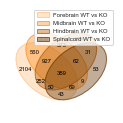

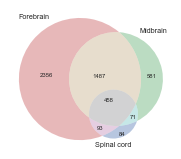

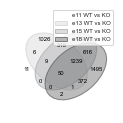

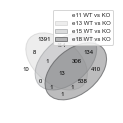

In [12]:
"""
---------------------------------------------------------------
            Plot venn diagrams
---------------------------------------------------------------
"""
import venn
from matplotlib.colors import ListedColormap

def plot_venn(gene_sets, labels, title, save=True, show=True, colours=None):
    output = f'venn_{title.replace(" ", "-")}'
    dset = {}
    for i, l in enumerate(labels):
        dset[l] = gene_sets[i]
    if len(gene_sets) > 3:
        cmap = ListedColormap(sns.color_palette(colours))
        venn.venn(dset, cmap=cmap, fontsize=6, figsize=(2, 2))
    else:
        venn3(gene_sets, set_labels=labels)
    if save:
        save_fig(output)
    if show:
        plt.show()

fb_df = df_dict[f'DEseq2_CNS_fb_{date}.csv'][abs(df_dict[f'DEseq2_CNS_fb_{date}.csv']['log2FoldChange']) > 0.5]
mb_df = df_dict[f'DEseq2_CNS_mb_{date}.csv'][abs(df_dict[f'DEseq2_CNS_mb_{date}.csv']['log2FoldChange']) > 0.5]
hb_df = df_dict[f'DEseq2_CNS_hb_{date}.csv'][abs(df_dict[f'DEseq2_CNS_hb_{date}.csv']['log2FoldChange']) > 0.5]
sc_df = df_dict[f'DEseq2_CNS_sc_{date}.csv'][abs(df_dict[f'DEseq2_CNS_sc_{date}.csv']['log2FoldChange']) > 0.5]

fb_sig_genes = fb_df[fb_df['padj'] < 0.05][gene_name].values
mb_sig_genes = mb_df[mb_df['padj'] < 0.05][gene_name].values
hb_sig_genes = hb_df[hb_df['padj'] < 0.05][gene_name].values
sc_sig_genes = sc_df[sc_df['padj'] < 0.05][gene_name].values


"""
---------------------------------------------------------------
            Print out the number of significant genes
---------------------------------------------------------------
"""

u.dp(["P.adj < 0.05 for SC: KO vs WT", len(sc_sig_genes)])
u.dp(["P.adj < 0.05 for HB: KO vs WT", len(hb_sig_genes)])
u.dp(["P.adj < 0.05 for MB: KO vs WT", len(mb_sig_genes)])
u.dp(["P.adj < 0.05 for FB: KO vs WT", len(fb_sig_genes)])


plot_venn([set(fb_sig_genes), 
           set(mb_sig_genes), set(hb_sig_genes), set(sc_sig_genes)], 
          ['Forebrain WT vs KO', 'Midbrain WT vs KO', 'Hindbrain WT vs KO', 'Spinalcord WT vs KO'],
          'tissue_WTvsKO',  colours=[fb_colour, mb_colour, hb_colour, sc_colour])

plot_venn((set(fb_sig_genes), set(mb_sig_genes), set(sc_sig_genes)),
          ('Forebrain', 'Midbrain', 'Spinal cord'), 'FbMbSc')


"""
---------------------------------------------------------------
            Plot Anterior Venns
---------------------------------------------------------------
"""
e11 = df_dict[f'DEseq2_CNS_anterior_11_{date}.csv'][abs(df_dict[f'DEseq2_CNS_anterior_11_{date}.csv']['log2FoldChange']) > 0.5]
e13 = df_dict[f'DEseq2_CNS_anterior_13_{date}.csv'][abs(df_dict[f'DEseq2_CNS_anterior_13_{date}.csv']['log2FoldChange']) > 0.5]
e15 = df_dict[f'DEseq2_CNS_anterior_15_{date}.csv'][abs(df_dict[f'DEseq2_CNS_anterior_15_{date}.csv']['log2FoldChange']) > 0.5]
e18 = df_dict[f'DEseq2_CNS_anterior_18_{date}.csv'][abs(df_dict[f'DEseq2_CNS_anterior_18_{date}.csv']['log2FoldChange']) > 0.5]

e11_sig_genes = e11[e11['padj'] < 0.05][gene_name].values
e13_sig_genes = e13[e13['padj'] < 0.05][gene_name].values
e15_sig_genes = e15[e15['padj'] < 0.05][gene_name].values
e18_sig_genes = e18[e18['padj'] < 0.05][gene_name].values

plot_venn([set(e11_sig_genes), 
           set(e13_sig_genes), set(e15_sig_genes), set(e18_sig_genes)], 
          ['e11 WT vs KO', 'e13 WT vs KO', 'e15 WT vs KO', 'e18 WT vs KO'],
          'posterior_time_WTvsKO', colours=[e11_colour, e13_colour, e15_colour, e18_colour])

"""
---------------------------------------------------------------
            Plot posterior venn diagrams
---------------------------------------------------------------
"""
e11 = df_dict[f'DEseq2_CNS_posterior_11_{date}.csv'][abs(df_dict[f'DEseq2_CNS_posterior_11_{date}.csv']['log2FoldChange']) > 0.5]
e13 = df_dict[f'DEseq2_CNS_posterior_13_{date}.csv'][abs(df_dict[f'DEseq2_CNS_posterior_13_{date}.csv']['log2FoldChange']) > 0.5]
e15 = df_dict[f'DEseq2_CNS_posterior_15_{date}.csv'][abs(df_dict[f'DEseq2_CNS_posterior_15_{date}.csv']['log2FoldChange']) > 0.5]
e18 = df_dict[f'DEseq2_CNS_posterior_18_{date}.csv'][abs(df_dict[f'DEseq2_CNS_posterior_18_{date}.csv']['log2FoldChange']) > 0.5]

e11_sig_genes = e11[e11['padj'] < 0.05][gene_name].values
e13_sig_genes = e13[e13['padj'] < 0.05][gene_name].values
e15_sig_genes = e15[e15['padj'] < 0.05][gene_name].values
e18_sig_genes = e18[e18['padj'] < 0.05][gene_name].values

plot_venn([set(e11_sig_genes), 
           set(e13_sig_genes), set(e15_sig_genes), set(e18_sig_genes)], 
          ['e11 WT vs KO', 'e13 WT vs KO', 'e15 WT vs KO', 'e18 WT vs KO'],
          'posterior_time_WTvsKO', colours=[e11_colour, e13_colour, e15_colour, e18_colour])




In [7]:
fb_df

u_id     baseMean  log2FoldChange     lfcSE       stat  \
0              18504-Pax2   929.098049        6.281474  0.216057  29.073200   
1            15422-Hoxc13  1618.363015        9.410621  0.329504  28.559978   
2           209448-Hoxc10   944.126232        8.291203  0.313065  26.483994   
4           22784-Slc30a3   932.077929        4.083362  0.165361  24.693656   
5            58801-Pmaip1   677.739614        3.327359  0.137365  24.222824   
...                   ...          ...             ...       ...        ...   
12919  100039192-Tmem254c    15.847349        0.539601  0.721806   0.747571   
13357         26900-Ddx3y  1878.191399        0.830736  1.360954   0.610407   
13366         20592-Kdm5d  1627.274693        0.937749  1.539738   0.609032   
13698           22290-Uty   847.191242        0.842456  1.650689   0.510366   
13866       26908-Eif2s3y  1957.619224        0.794170  1.742663   0.455722   

              pvalue           padj entrezgene_id external_gene_name  
0      7.834682e-186  1.199020e-181         18504               Pax2  
1      2.111797e-179  1.615947e-175         15422             Hoxc13  
2      1.481985e-154  7.560097e-151        209448             Hoxc10  
4      1.251205e-134  3.829690e-131         22784            Slc30a3  
5      1.279030e-129  3.262379e-126         58801             Pmaip1  
...              ...            ...           ...                ...  
12919   4.547193e-01   5.386241e-01     100039192           Tmem254c  
13357   5.415920e-01   6.204914e-01         26900              Ddx3y  
13366   5.425033e-01   6.211170e-01         20592              Kdm5d  
13698   6.097948e-01   6.812395e-01         22290                Uty  
13866   6.485898e-01   7.158014e-01         26908            Eif2s3y  

[3211 rows x 9 columns]

## 7) Make bar chart of all comparisons

Have a look at the comaprisons and just plot the number of DEGs for a summary figure.


No handles with labels found to put in legend.


3187, Forebrain vs Midbrain WT
1069, Forebrain vs Midbrain KO
1756, Midbrain vs Hindbrain WT
674, Midbrain vs Hindbrain KO
1479, Hindbrain vs Spinalcord WT
806, Hindbrain vs Spinalcord KO
2555, Midbrain vs Spinalcord WT
1532, Midbrain vs Spinalcord KO
4881, Forebrain vs Hindbrain WT
2085, Forebrain vs Hindbrain KO
4771, Forebrain vs Spinal cord WT
2604, Forebrain vs Spinalcord KO
4414, WT vs KO (Forebrain)
2617, WT vs KO (Midbrain)
2677, WT vs KO (Hindbrain)
717, WT vs KO (Spinal cord)
--------------------------------------------------------------------------------
              Barchart used p.adj cutoff:	0.05	
LogFC cutoff:	0.5	              
--------------------------------------------------------------------------------


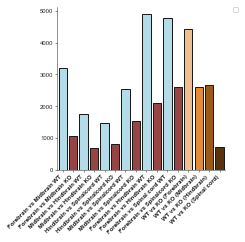

In [9]:
"""
---------------------------------------------------------------
            Bar charts for tissue specific DE 
---------------------------------------------------------------
"""
df = pd.read_csv(f'{r_dir}merged_df_FEATURE_COUNTS_annot_{date}.csv')
dfs = [df_dict[f'DEseq2_CNS_wt_fb-mb_{date}.csv'], df_dict[f'DEseq2_CNS_ko_fb-mb_{date}.csv'], 
       df_dict[f'DEseq2_CNS_wt_mb-hb_{date}.csv'], df_dict[f'DEseq2_CNS_ko_mb-hb_{date}.csv'],
       df_dict[f'DEseq2_CNS_wt_hb-sc_{date}.csv'], df_dict[f'DEseq2_CNS_ko_hb-sc_{date}.csv'],
       df_dict[f'DEseq2_CNS_wt_mb-sc_{date}.csv'], df_dict[f'DEseq2_CNS_ko_mb-sc_{date}.csv'],
       df_dict[f'DEseq2_CNS_wt_fb-hb_{date}.csv'], df_dict[f'DEseq2_CNS_ko_fb-hb_{date}.csv'],
       df_dict[f'DEseq2_CNS_wt_fb-sc_{date}.csv'], df_dict[f'DEseq2_CNS_ko_fb-sc_{date}.csv'], 
       df_dict[f'DEseq2_CNS_fb_{date}.csv'], 
       df_dict[f'DEseq2_CNS_mb_{date}.csv'], 
       df_dict[f'DEseq2_CNS_hb_{date}.csv'], 
       df_dict[f'DEseq2_CNS_sc_{date}.csv']
      ]

labels = ['Forebrain vs Midbrain WT',
          'Forebrain vs Midbrain KO',
          
          'Midbrain vs Hindbrain WT',
          'Midbrain vs Hindbrain KO',
          
          'Hindbrain vs Spinalcord WT',
          'Hindbrain vs Spinalcord KO',
          
          'Midbrain vs Spinalcord WT',
          'Midbrain vs Spinalcord KO',
          
          'Forebrain vs Hindbrain WT', 
          'Forebrain vs Hindbrain KO',
          
          'Forebrain vs Spinal cord WT',
          'Forebrain vs Spinalcord KO',
          
          'WT vs KO (Forebrain)',
          'WT vs KO (Midbrain)',
          'WT vs KO (Hindbrain)', 
          'WT vs KO (Spinal cord)',
         ]
i = 0
values = []
logfc_cutoff = 0.5

for d in dfs:
    sigD = d[d['padj'] < 0.05]
    sigD = sigD[abs(sigD['log2FoldChange']) > logfc_cutoff]
    num_sig = len(sigD)
    values.append(num_sig)
    print(f'{num_sig}, {labels[i]}')
    i += 1
    
# Plot a simple bar chart.
barchart = Barchart(df, labels, values, order=labels, figsize=(1,1))
barchart.palette=sns.color_palette([wt_colour, ko_colour, wt_colour, ko_colour, wt_colour, ko_colour,
                                   wt_colour, ko_colour, wt_colour, ko_colour, wt_colour, ko_colour, fb_colour, mb_colour, hb_colour, sc_colour])
barchart.figsize=(2,1)
barchart.plot()
save_fig(f'Barchart_numSigs')
u.dp(["Barchart used p.adj cutoff:", 0.05, "\nLogFC cutoff:", logfc_cutoff])


In [10]:
values

[3187,
 1069,
 1756,
 674,
 1479,
 806,
 2555,
 1532,
 4881,
 2085,
 4771,
 2604,
 4414,
 2617,
 2677,
 717]

No handles with labels found to put in legend.


7404, e11 vs e13 (WT)
7940, e11 vs e13 (KO)
4381, e13 vs e15 (WT)
3845, e13 vs e15 (KO)
1970, e15 vs e18 (WT)
2547, e15 vs e18 (KO)
8826, e11 vs e15 (WT)
9101, e11 vs e15 (KO)
6690, e13 vs e18 (WT)
6560, e13 vs e18 (KO)
9707, e11 vs e18 (WT)
9940, e11 vs e18 (KO)
79, WT vs KO (11)
3031, WT vs KO (13)
2415, WT vs KO (15)
3794, WT vs KO (18)
--------------------------------------------------------------------------------
              Barchart used p.adj cutoff:	0.05	
LogFC cutoff:	0.5	              
--------------------------------------------------------------------------------


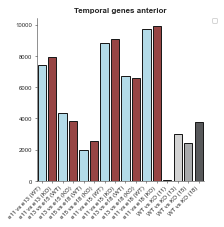

In [14]:
"""
---------------------------------------------------------------
            Bar charts for time specific DE (anterior)
---------------------------------------------------------------
"""

dfs = [df_dict[f'DEseq2_CNS_anterior_wt_11-13_{date}.csv'], df_dict[f'DEseq2_CNS_anterior_ko_11-13_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_wt_13-15_{date}.csv'], df_dict[f'DEseq2_CNS_anterior_ko_13-15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_wt_15-18_{date}.csv'], df_dict[f'DEseq2_CNS_anterior_ko_15-18_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_wt_11-15_{date}.csv'], df_dict[f'DEseq2_CNS_anterior_ko_11-15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_wt_13-18_{date}.csv'], df_dict[f'DEseq2_CNS_anterior_ko_13-18_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_wt_11-18_{date}.csv'], df_dict[f'DEseq2_CNS_anterior_ko_11-18_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_11_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_13_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_18_{date}.csv']
      ]

labels = ['e11 vs e13 (WT)', 'e11 vs e13 (KO)',
          'e13 vs e15 (WT)', 'e13 vs e15 (KO)',
          'e15 vs e18 (WT)', 'e15 vs e18 (KO)',
          
          'e11 vs e15 (WT)', 'e11 vs e15 (KO)',
          'e13 vs e18 (WT)', 'e13 vs e18 (KO)',
          
          'e11 vs e18 (WT)', 'e11 vs e18 (KO)',

          'WT vs KO (11)', 'WT vs KO (13)', 'WT vs KO (15)','WT vs KO (18)'
         ]
i = 0
values = []
for d in dfs:
    sigD = d[d['padj'] < 0.05]
    sigD = sigD[abs(sigD['log2FoldChange']) > logfc_cutoff]
    num_sig = len(sigD)
    values.append(num_sig)
    print(f'{num_sig}, {labels[i]}')
    i += 1
    
# Plot a simple bar chart.
barchart = Barchart(df, labels, values, title='Temporal genes anterior', order=labels)
barchart.palette=sns.color_palette([wt_colour, ko_colour, wt_colour, ko_colour, wt_colour, ko_colour,
                                   wt_colour, ko_colour, wt_colour, ko_colour, wt_colour, ko_colour, 
                                    e11_colour, e13_colour, e15_colour, e18_colour])

barchart.plot()
save_fig(f'Barchart_anterior_time_numSigs')

u.dp(["Barchart used p.adj cutoff:", 0.05, "\nLogFC cutoff:", logfc_cutoff])


In [ ]:
"""
---------------------------------------------------------------
            Bar charts for time specific (anterior & posterior) 
---------------------------------------------------------------
"""

dfs = [
       df_dict[f'DEseq2_CNS_anterior_11_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_13_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_anterior_18_{date}.csv'],
       df_dict[f'DEseq2_CNS_posterior_11_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_13_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_18_{date}.csv']
       
      ]

labels = [ 
        'A. WT vs KO (11)', 'A. WT vs KO (13)', 'A. WT vs KO (15)','A. WT vs KO (18)',
        'P. WT vs KO (11)', 'P. WT vs KO (13)', 'P. WT vs KO (15)','P. WT vs KO (18)'
         ]
i = 0
values = []
logfc_cutoff = 0.5
for d in dfs:
    sigD = d[d['padj'] < 0.05]
    sigD = sigD[abs(sigD['log2FoldChange']) > logfc_cutoff]
    num_sig = len(sigD)
    values.append(num_sig)
    print(f'{num_sig}, {labels[i]}')
    i += 1
    
# Plot a simple bar chart.
barchart = Barchart(dfs[0], labels, values, title='Temporal genes anterior', order=labels)
barchart.palette=sns.color_palette([e11_colour, e13_colour, e15_colour, e18_colour,
                                    e11_colour, e13_colour, e15_colour, e18_colour])
barchart.plot()
save_fig('Barchart_anterior-posterior_time_numSigs')

u.dp(["Barchart used p.adj cutoff:", 0.05, "\nLogFC cutoff:", logfc_cutoff])


No handles with labels found to put in legend.


5273, e11 vs e13 (WT)
5198, e11 vs e13 (KO)
1878, e13 vs e15 (WT)
1017, e13 vs e15 (KO)
573, e15 vs e18 (WT)
667, e15 vs e18 (KO)
5535, e11 vs e15 (WT)
6004, e11 vs e15 (KO)
3148, e13 vs e18 (WT)
2290, e13 vs e18 (KO)
6676, e11 vs e18 (WT)
6660, e11 vs e18 (KO)
19, WT vs KO (11)
1062, WT vs KO (13)
433, WT vs KO (15)
551, WT vs KO (18)
--------------------------------------------------------------------------------
              Barchart used p.adj cutoff:	0.05	
LogFC cutoff:	1.0	              
--------------------------------------------------------------------------------


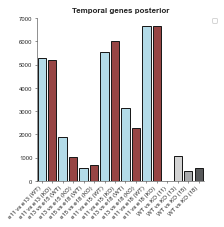

In [17]:
"""
---------------------------------------------------------------
            Bar charts for time specific DE (posterior)
---------------------------------------------------------------
"""

dfs = [df_dict[f'DEseq2_CNS_posterior_wt_11-13_{date}.csv'], df_dict[f'DEseq2_CNS_posterior_ko_11-13_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_wt_13-15_{date}.csv'], df_dict[f'DEseq2_CNS_posterior_ko_13-15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_wt_15-18_{date}.csv'], df_dict[f'DEseq2_CNS_posterior_ko_15-18_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_wt_11-15_{date}.csv'], df_dict[f'DEseq2_CNS_posterior_ko_11-15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_wt_13-18_{date}.csv'], df_dict[f'DEseq2_CNS_posterior_ko_13-18_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_wt_11-18_{date}.csv'], df_dict[f'DEseq2_CNS_posterior_ko_11-18_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_11_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_13_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_15_{date}.csv'], 
       df_dict[f'DEseq2_CNS_posterior_18_{date}.csv']
      ]

labels = ['e11 vs e13 (WT)', 'e11 vs e13 (KO)',
          'e13 vs e15 (WT)', 'e13 vs e15 (KO)',
          'e15 vs e18 (WT)', 'e15 vs e18 (KO)',
          
          'e11 vs e15 (WT)', 'e11 vs e15 (KO)',
          'e13 vs e18 (WT)', 'e13 vs e18 (KO)',
          
          'e11 vs e18 (WT)', 'e11 vs e18 (KO)',

          'WT vs KO (11)', 'WT vs KO (13)', 'WT vs KO (15)','WT vs KO (18)'
         ]
i = 0
values = []
logfc_cutoff = 1.0
for d in dfs:
    sigD = d[d['padj'] < 0.05]
    sigD = sigD[abs(sigD['log2FoldChange']) > logfc_cutoff]
    num_sig = len(sigD)
    values.append(num_sig)
    print(f'{num_sig}, {labels[i]}')
    i += 1
    
# Plot a simple bar chart.
barchart = Barchart(df, labels, values, title='Temporal genes posterior', order=labels)
barchart.palette=sns.color_palette([wt_colour, ko_colour, wt_colour, ko_colour, wt_colour, ko_colour,
                                   wt_colour, ko_colour, wt_colour, ko_colour, wt_colour, ko_colour, 
                                    e11_colour, e13_colour, e15_colour, e18_colour])
barchart.plot()
save_fig(f'Barchart_posterior_time_numSigs')
u.dp(["Barchart used p.adj cutoff:", 0.05, "\nLogFC cutoff:", logfc_cutoff])



## 8) Select log2(TMM + 1) as normalisation

We choose the normalisation to be the log2(TMM + 1) as we are keen to look across the genes rather than just run 
differential expression between the genes. As such, we need to load this add the information from the various 
differential expression analyses.

We also merge our WT vs KO experiments from before.

In [18]:
"""
--------------------------------------------------------
Choose normalisation method for data & add annoation
--------------------------------------------------------
"""

        
# Read in normalised RNAseq data
tmm = pd.read_csv(f'{r_dir}merged_df_FEATURE_COUNTS_tmm_{date}.csv')

tmm.rename(columns={ tmm.columns[0]: gene_id }, inplace = True)

for c in tmm:
    if c != gene_id:
        tmm[c] = np.log2(tmm[c].values + 1)

df_all = tmm.copy()
df_all[gene_id] = pd.to_numeric(df_all[gene_id])

# Read in each our our DE experiments from DEseq2
fb_df = df_dict[f'DEseq2_CNS_fb_{date}.csv']
mb_df = df_dict[f'DEseq2_CNS_mb_{date}.csv']
hb_df = df_dict[f'DEseq2_CNS_hb_{date}.csv']
sc_df = df_dict[f'DEseq2_CNS_sc_{date}.csv']

a11_df = df_dict[f'DEseq2_CNS_anterior_11_{date}.csv']
a13_df = df_dict[f'DEseq2_CNS_anterior_13_{date}.csv']
a15_df = df_dict[f'DEseq2_CNS_anterior_15_{date}.csv']
a18_df = df_dict[f'DEseq2_CNS_anterior_18_{date}.csv']

p11_df = df_dict[f'DEseq2_CNS_posterior_11_{date}.csv']
p13_df = df_dict[f'DEseq2_CNS_posterior_13_{date}.csv']
p15_df = df_dict[f'DEseq2_CNS_posterior_15_{date}.csv']
p18_df = df_dict[f'DEseq2_CNS_posterior_18_{date}.csv']

# Let's add all our significant results (and make sure we just indicate where they came from)
fb_df[gene_id] = pd.to_numeric(fb_df[gene_id])
df_all = df_all.merge(fb_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_fb'))
mb_df[gene_id] = pd.to_numeric(mb_df[gene_id])
df_all = df_all.merge(mb_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_mb'))
hb_df[gene_id] = pd.to_numeric(hb_df[gene_id])
df_all = df_all.merge(hb_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_hb'))
sc_df[gene_id] = pd.to_numeric(sc_df[gene_id])
df_all = df_all.merge(sc_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_sc'))

# Now we also want to add in the results from the anterior and posterior temporal changes
a11_df[gene_id] = pd.to_numeric(a11_df[gene_id])
df_all = df_all.merge(a11_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_a11'))
a13_df[gene_id] = pd.to_numeric(a13_df[gene_id])
df_all = df_all.merge(a13_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_a13'))
a15_df[gene_id] = pd.to_numeric(a15_df[gene_id])
df_all = df_all.merge(a15_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_a15'))
a18_df[gene_id] = pd.to_numeric(a18_df[gene_id])
df_all = df_all.merge(a18_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_a18'))

p11_df[gene_id] = pd.to_numeric(p11_df[gene_id])
df_all = df_all.merge(p11_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_p11'))
p13_df[gene_id] = pd.to_numeric(p13_df[gene_id])
df_all = df_all.merge(p13_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_p13'))
p15_df[gene_id] = pd.to_numeric(p15_df[gene_id])
df_all = df_all.merge(p15_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_p15'))
p18_df[gene_id] = pd.to_numeric(p18_df[gene_id])
df_all = df_all.merge(p18_df, how='left', left_on=gene_id, 
                                       right_on=gene_id, suffixes=('', '_p18'))

# Rename the padj from forebrain and logfc
df_all.rename(columns={'padj': 'padj_fb', 'log2FoldChange': 'log2FoldChange_fb'}, inplace=True)

# Drop columns that don't have gene names --> leave this out for now.
#df_all = df_all.dropna(subset=[gene_name])

# This will be on p values that weren't in there 
p_cols = [c for c in df_all.columns if 'padj' in c]

# Make them NS i.e. given them a p value of 1.0
df_all[p_cols] = df_all[p_cols].fillna(value=1.0)

# Fill everything else with 0's so we don't have NaNs in our counts etc
df_all = df_all.fillna(value=0)
df_all = df_all.reset_index()  # Ensure the index is reset each time we rejoin everything
u.dp(['Length of dataframe', len(df_all)])

# We don't want duplicate gene IDs so we drop columns with duplicates in these values
no_na_merged = df_all.drop_duplicates()

# Collect entrez IDs
ens_ids = annot_df['ensembl_gene_id'].values
chr_ids = annot_df['chromosome_name'].values
gene_id_to_ens = {}
gene_id_to_chr = {}
for i, g in enumerate(annot_df[gene_id].values):
    if not gene_id_to_ens.get(g):
        gene_id_to_ens[g] = ens_ids[i]
    if not gene_id_to_chr.get(g):
        gene_id_to_chr[g] = chr_ids[i]
ens_ids = []
chrs = []
for g in no_na_merged[gene_id].values:
    ens_ids.append(gene_id_to_ens.get(g))
    chrs.append(gene_id_to_chr.get(g))
# Add ensembl gene id 
no_na_merged['ensembl_gene_id'] = ens_ids
no_na_merged['chrs'] = chrs

# Organise columns a bit nicer
cols = [gene_id, gene_name, 'ensembl_gene_id', 'chrs',
        'wt11fb1', 'wt11fb2', 'wt13fb1', 'wt13fb2', 'wt15fb1', 'wt15fb2', 'wt18fb1', 'wt18fb2',
        'wt11mb1', 'wt11mb2', 'wt13mb1', 'wt13mb2', 'wt15mb1', 'wt15mb2', 'wt18mb1', 'wt18mb2',
        'wt11hb1', 'wt11hb2', 'wt13hb1', 'wt13hb2', 'wt15hb1', 'wt15hb2', 'wt18hb1', 'wt18hb2',
        'wt11sc1', 'wt11sc2', 'wt13sc1', 'wt13sc2', 'wt15sc1', 'wt15sc2', 'wt18sc1', 'wt18sc2',
        
        'ko11fb1', 'ko11fb2', 'ko13fb1', 'ko13fb2', 'ko15fb1', 'ko15fb2', 'ko18fb1', 'ko18fb2',
        'ko11mb1', 'ko11mb2', 'ko13mb1', 'ko13mb2', 'ko15mb1', 'ko15mb2', 'ko18mb1', 'ko18mb2',
        'ko11hb1', 'ko11hb2', 'ko13hb1', 'ko13hb2', 'ko15hb1', 'ko15hb2', 'ko18hb1', 'ko18hb2',
        'ko11sc1', 'ko11sc2', 'ko13sc1', 'ko13sc2', 'ko15sc1', 'ko15sc2', 'ko18sc1', 'ko18sc2',
]

for c in no_na_merged:
    if c not in cols:
        cols.append(c)
        
df_all = no_na_merged[cols]
df_all = df_all.reset_index()

# Ensure the gene name hasn't been messed up 
gene_names = []
pseudo_id = []

for g in df_all[gene_id].values:
    gene_n = gene_id_to_name.get(g)
    gene_names.append(gene_n)
    pseudo_id.append(f'{g}-{gene_n}')
df_all[gene_name] = gene_names

u.dp(['Length of dataframe (no dups reset index)', len(df_all)])

--------------------------------------------------------------------------------
                           Length of dataframe	20900	                           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                Length of dataframe (no dups reset index)	20900	                
--------------------------------------------------------------------------------


## Testing gender of samples

Here we just confirm the gender of the samples based on X and Y reads.

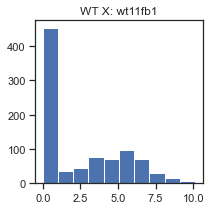

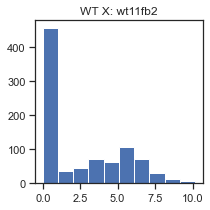

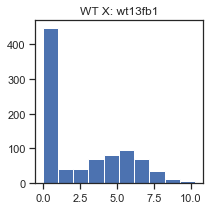

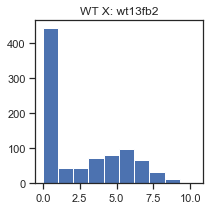

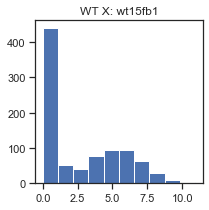

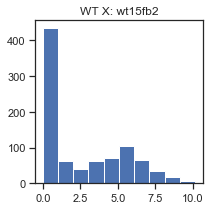

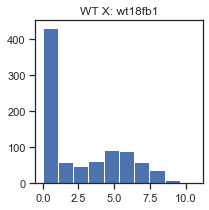

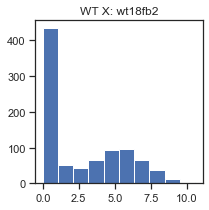

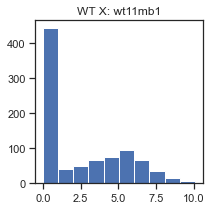

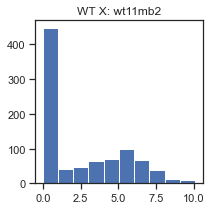

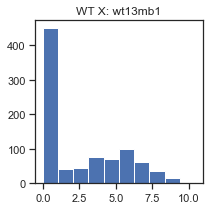

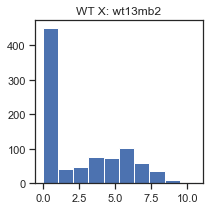

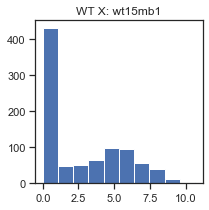

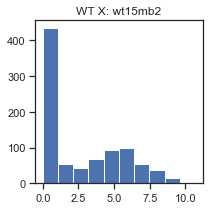

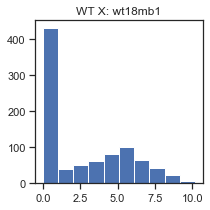

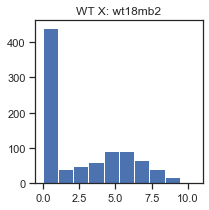

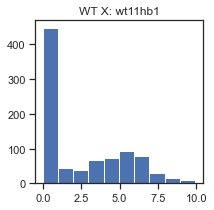

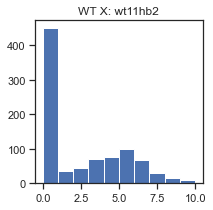

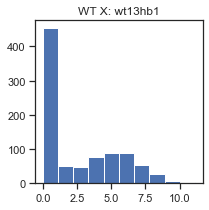

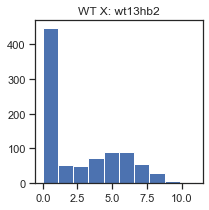

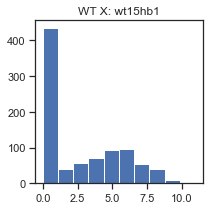

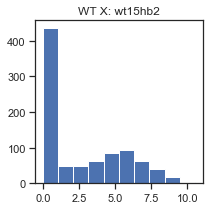

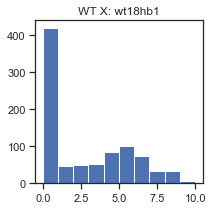

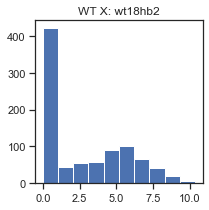

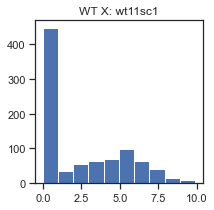

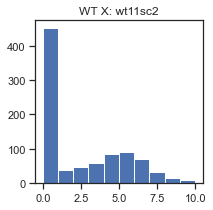

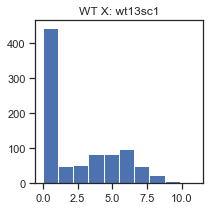

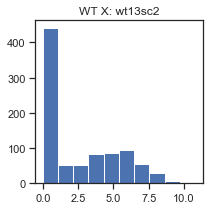

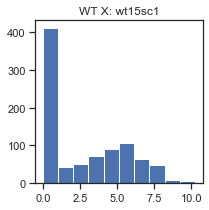

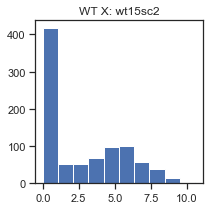

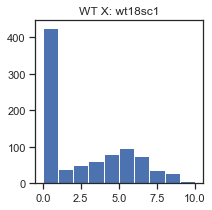

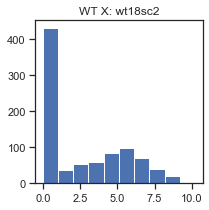

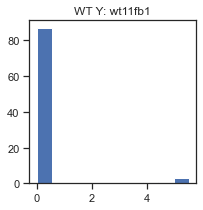

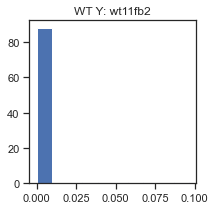

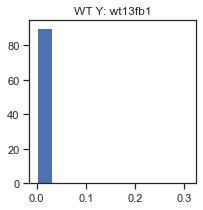

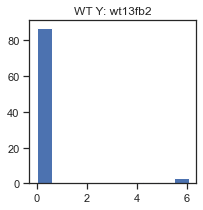

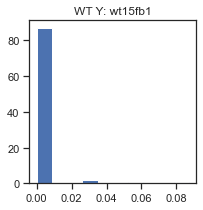

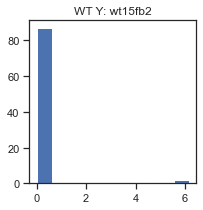

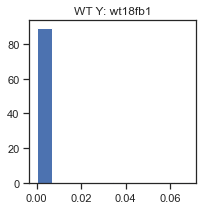

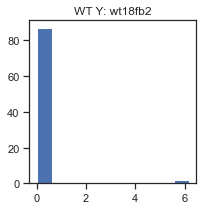

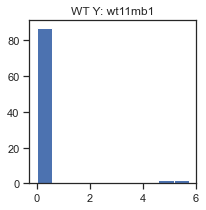

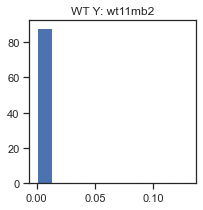

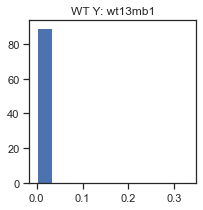

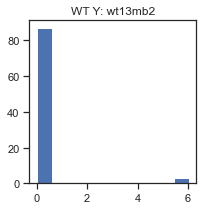

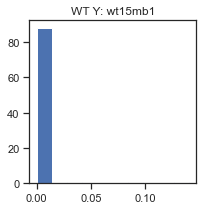

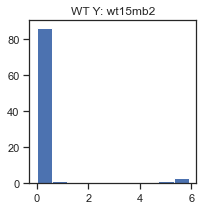

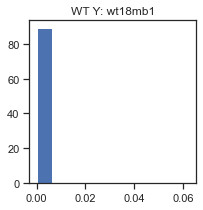

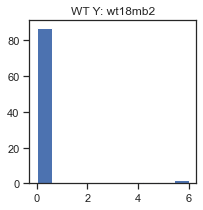

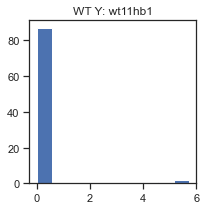

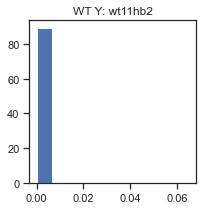

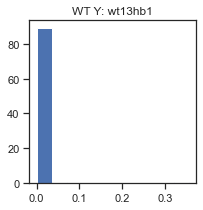

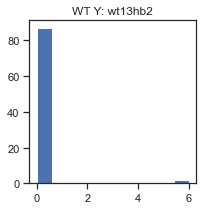

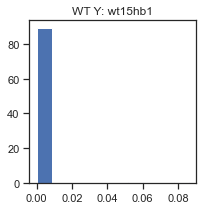

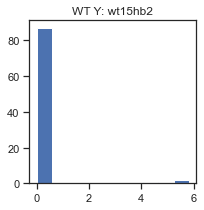

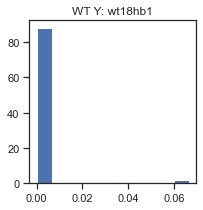

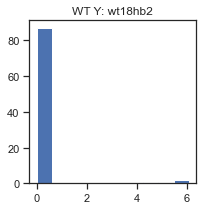

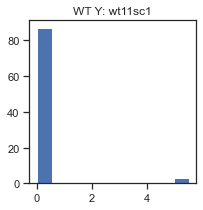

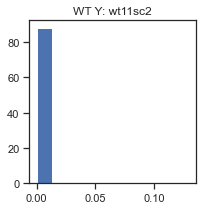

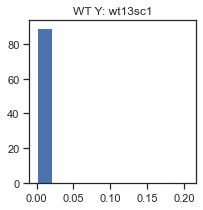

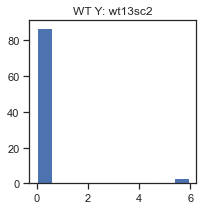

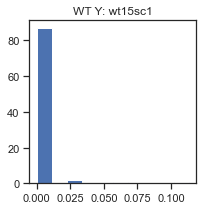

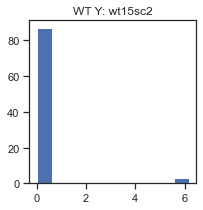

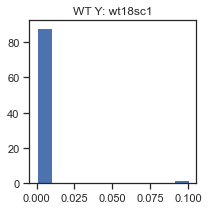

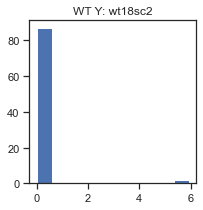

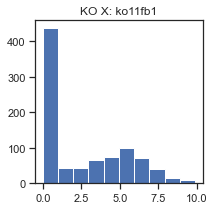

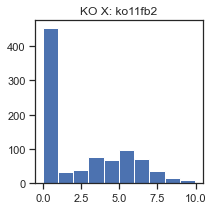

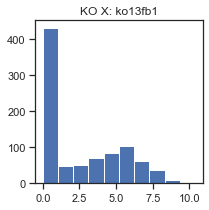

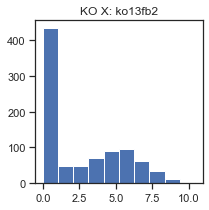

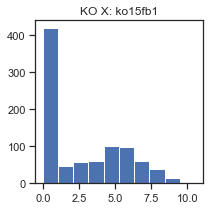

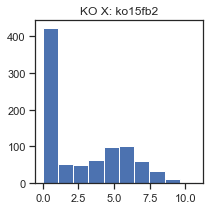

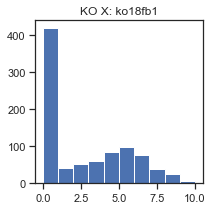

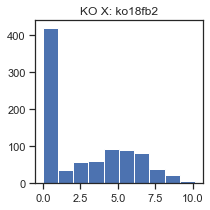

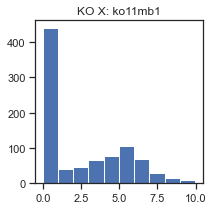

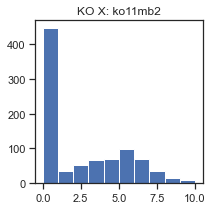

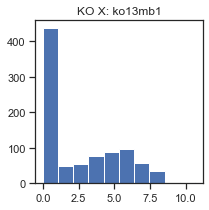

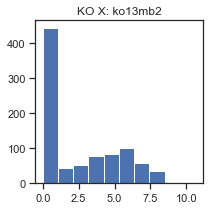

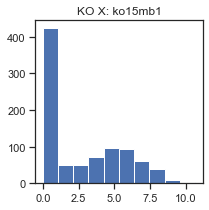

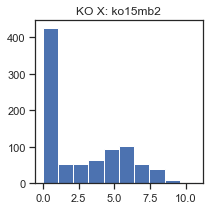

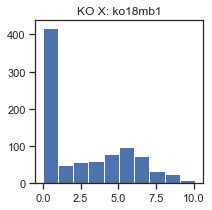

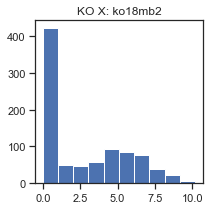

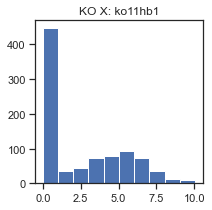

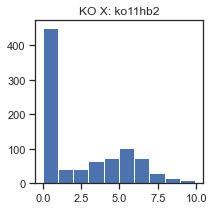

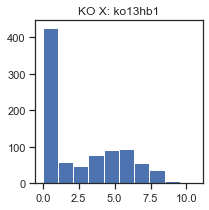

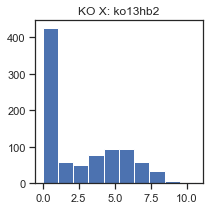

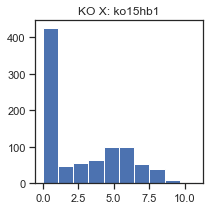

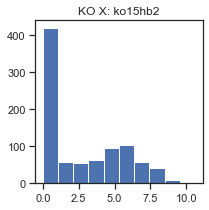

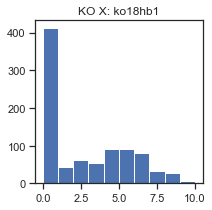

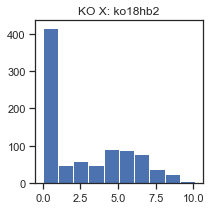

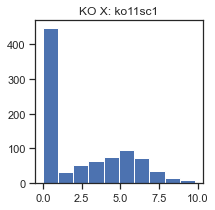

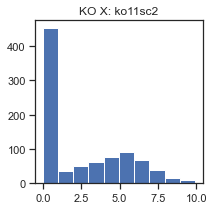

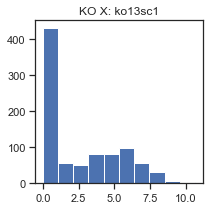

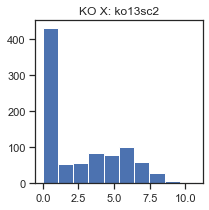

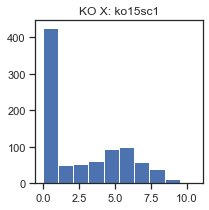

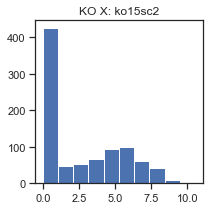

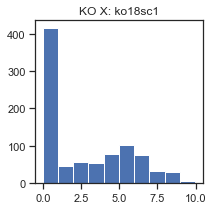

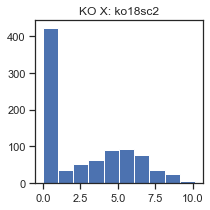

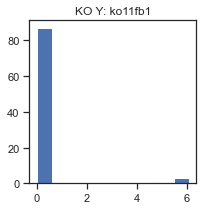

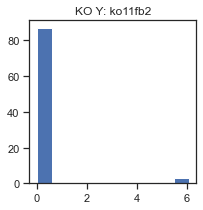

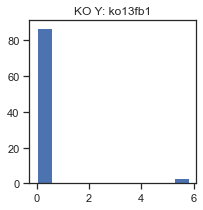

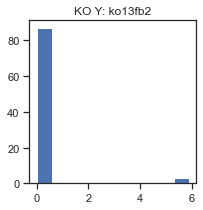

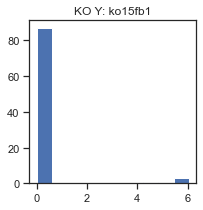

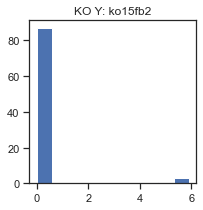

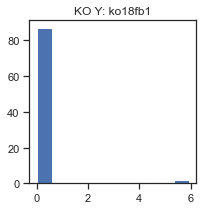

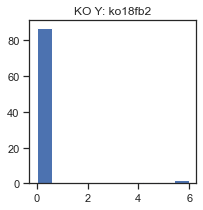

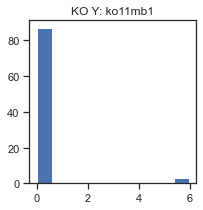

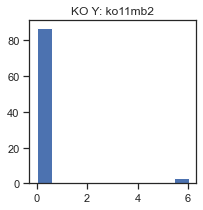

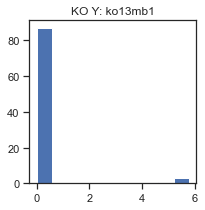

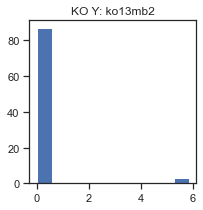

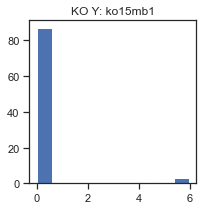

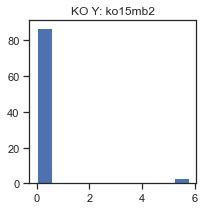

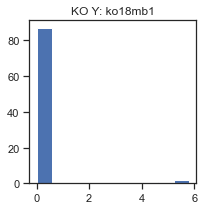

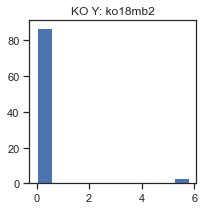

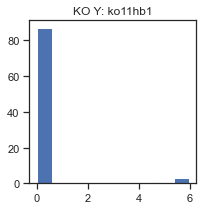

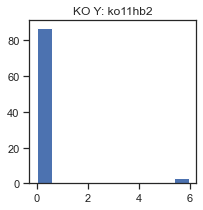

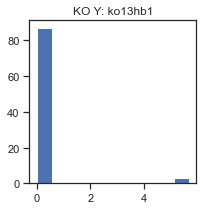

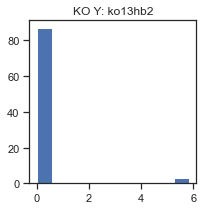

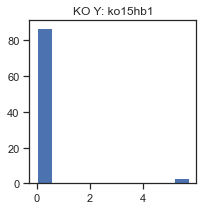

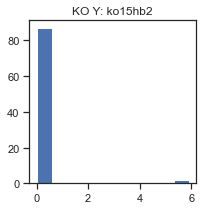

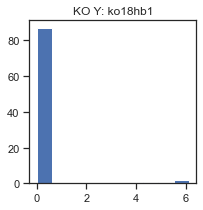

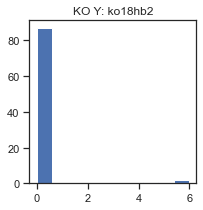

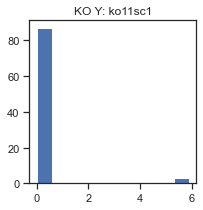

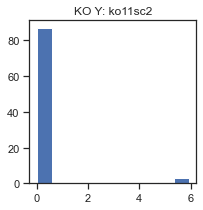

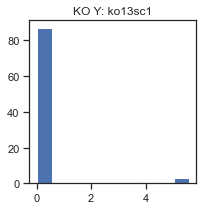

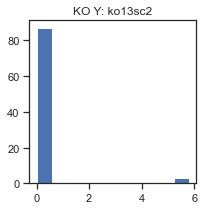

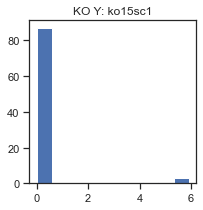

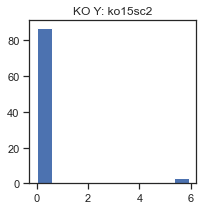

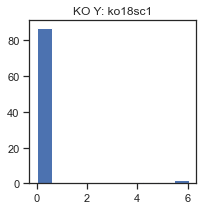

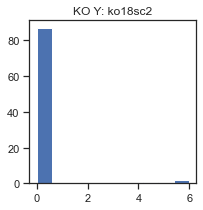

In [22]:
y_chr = df_all[df_all['chrs'] == 'Y']
x_chr = df_all[df_all['chrs'] == 'X']


wt_cols = [c for c in df_all.columns if 'merged' not in c and 'wt' in c]
for w in wt_cols:
    plt.hist(x_chr[w].values)
    plt.title(f'WT X: {w}')
    plt.show()
    
wt_cols = [c for c in df_all.columns if 'merged' not in c and 'wt' in c]
for w in wt_cols:
    plt.hist(y_chr[w].values)
    plt.title(f'WT Y: {w}')
    plt.show() 

    
ko_cols = [c for c in df_all.columns if 'merged' not in c and 'ko' in c]
for w in ko_cols:
    plt.hist(x_chr[w].values)
    plt.title(f'KO X: {w}')
    plt.show()
    
for w in ko_cols:
    plt.hist(y_chr[w].values)
    plt.title(f'KO Y: {w}')
    plt.show() 

## 9) Visualise the merged data top most significant genes

Here we visualise the top genes by padj in the forebrain and validate that these align with the other results.

We observe the Hox genes as the most diverged.


In [23]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sciviso import Scatterplot
import umap
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sciviso import Vis

# Plot PCA of the forebrain genes i.e. so we see how time separates
def get_cond_colour(c):
    if 'ko' in c:
        return ko_colour
    elif 'wt' in c:
        return wt_colour
    return '#FFFFFF'

def plt_heatmap(df, idxs, title='', plt_sig=True, mark=None, row_colours=None, cond=''):
    # Now let's look at a couple of these, and how similar these are to the other data
    heatmap_df = pd.DataFrame()
    # Select our genes of interest
    if plt_sig:
        ps = df['padj'].values[idxs]
        p_idxs = np.where(ps < 0.05)
        heatmap_df[gene_name] = df[gene_name].values[idxs][p_idxs]
    else:
        heatmap_df[gene_name] = df[gene_name].values[idxs]

    cols = []
    col_colours = []
    cond_colours = []
    tissue_colours = []
    time_colours = []
    for c in df.columns:
        if mark == None:
            if (cond in c) and 'merged' in c:
                cname = c.split('_')[0]
                print(c)
                if plt_sig:
                    heatmap_df[cname] = df[c].values[idxs][p_idxs]
                else:
                    heatmap_df[cname] = df[c].values[idxs]
                cols.append(cname)
                time_colours.append(get_time_colour(c))
                tissue_colours.append(get_tissue_colour(c))
                cond_colours.append(get_cond_colour(c))
        else:
            if mark in c and hist_metric in c:
                if plt_sig:
                    heatmap_df[c] = np.log2(df[c].values[idxs][p_idxs] + 1)
                else:
                    heatmap_df[c] =  np.log2(df[c].values[idxs] + 1)
                    
                time_colours.append(get_time_colour(c))
                tissue_colours.append(get_tissue_colour(c))
                cond_colours.append(get_mark_colour(c))
                cols.append(c)
    col_colours = [cond_colours, tissue_colours, time_colours]
    
    heatmap = Heatmap(heatmap_df, cols, gene_name, linewidths=0.0, cmap="Purples", x_tick_labels=0, 
                      figsize=(2, 1.5), vmin=0, vmax=9,
                      title=f'{title}', cluster_cols=False, cluster_rows=True, 
                     col_colours=col_colours, row_colours=row_colours)
    
    ax = heatmap.plot()
            
    ax.ax_heatmap.tick_params(direction='out', length=2, width=0.5)
    ax.ax_heatmap.tick_params(labelsize=6)
    ax.ax_heatmap.tick_params(axis='x', which='major', pad=2.0)
    ax.ax_heatmap.tick_params(axis='y', which='major', pad=2.0)

    pplot()
    save_fig(title)
    plt.show()

## Plot PCA with each of the features 

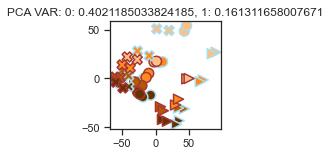

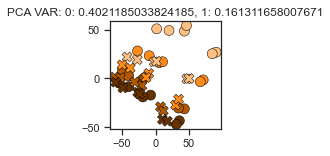

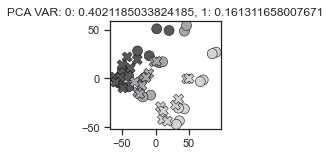

In [33]:
cols, edges = [], []
e13, e13_colours = [], []
e18, e18_colours = [], []
e15, e15_colours = [], []
tissue_colours = []
time_colours = []
cond_colours = []
wt_tissue_colours = []
wt_time_colours = []
wt_cond_colours = []
ko_tissue_colours = []
ko_time_colours = []
ko_cond_colours = []
c_i = 0
wt_pts = []
ko_pts = []
line_styles = []
for c in df_all.columns:
    if ('wt' in c or 'ko' in c) and '11' not in c:
        cols.append(c)
        if 'wt' in c:
            wt_tissue_colours.append(get_tissue_colour(c))
            wt_time_colours.append(get_time_colour(c))
            wt_pts.append(c_i)
        elif 'ko' in c:
            ko_tissue_colours.append(get_tissue_colour(c))
            ko_time_colours.append(get_time_colour(c))
            ko_pts.append(c_i)
        if '13' in c:
            e13.append(c_i)
            e13_colours.append(get_tissue_colour(c))
            tissue_colours.append(get_tissue_colour(c))
            time_colours.append(get_time_colour(c))
            cond_colours.append(get_cond_colour(c))
        elif '15' in c:
            e15.append(c_i)
            e15_colours.append(get_tissue_colour(c))
            tissue_colours.append(get_tissue_colour(c))
            time_colours.append(get_time_colour(c))
            cond_colours.append(get_cond_colour(c))
        elif '18' in c:
            e18.append(c_i)
            e18_colours.append(get_tissue_colour(c))
            # Make the edges the colour of our condition
            edges.append(get_cond_colour(c))
            tissue_colours.append(get_tissue_colour(c))
            time_colours.append(get_time_colour(c))
            cond_colours.append(get_cond_colour(c))
            if 'wt' in c:
                line_styles.append('-')
            else:
                line_styles.append('-')
        c_i += 1

vals = (df_all[cols].values).T #np.log2(df_all[cols].values + 1).T
fb_pca = PCA(n_components=2)
fb_pca_values = fb_pca.fit_transform(vals)
var_ratio = fb_pca.fit(vals).explained_variance_ratio_

"""
---------------------------------------------------------------
            Plot PCA
---------------------------------------------------------------
"""
plt.rcParams['figure.figsize'] = [2, 2]

plt.scatter(fb_pca_values[e13,0], fb_pca_values[e13,1], linestyle=line_styles, c=e13_colours, s=100, marker=">", edgecolors=edges, linewidths=1.5)
plt.scatter(fb_pca_values[e15,0], fb_pca_values[e15,1], linestyle=line_styles, c=e15_colours, s=100, marker="o", edgecolors=edges, linewidths=1.5)
plt.scatter(fb_pca_values[e18,0], fb_pca_values[e18,1], linestyle=line_styles, c=e18_colours, s=100, marker="X", edgecolors=edges, linewidths=1.5)

plt.title(f'PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
save_fig(f'PCA_ne11_fb')
# Now we want to fit everything except the gene IDs 
plt.show()


"""
---------------------------------------------------------------
            PCA coloured by tissue
---------------------------------------------------------------
"""
plt.rcParams['figure.figsize'] = [2, 2]

plt.scatter(fb_pca_values[wt_pts,0], fb_pca_values[wt_pts,1], linestyle=line_styles, c=wt_tissue_colours, s=100, marker="o", edgecolors='black', linewidths=0.5)
plt.scatter(fb_pca_values[ko_pts,0], fb_pca_values[ko_pts,1], linestyle=line_styles, c=ko_tissue_colours, s=100, marker="X", edgecolors='black', linewidths=0.5)

plt.title(f'PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
save_fig(f'PCA_ne11_tissue')
# Now we want to fit everything except the gene IDs 
plt.show()


"""
---------------------------------------------------------------
            PCA coloured by time
---------------------------------------------------------------
"""
plt.rcParams['figure.figsize'] = [2, 2]

plt.scatter(fb_pca_values[wt_pts,0], fb_pca_values[wt_pts,1], linestyle=line_styles, c=wt_time_colours, s=100, marker="o", edgecolors='black', linewidths=0.5)
plt.scatter(fb_pca_values[ko_pts,0], fb_pca_values[ko_pts,1], linestyle=line_styles, c=ko_time_colours, s=100, marker="X", edgecolors='black', linewidths=0.5)

plt.title(f'PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
save_fig(f'PCA_ne11_time')
# Now we want to fit everything except the gene IDs 
plt.show()



## Merge samples and do sample clustermap

Here we just do a sample clustermap 

merged wt15fb1 wt15fb2
merged wt18fb1 wt18fb2
merged wt15mb1 wt15mb2
merged wt18mb1 wt18mb2
merged ko15fb1 ko15fb2
merged ko18fb1 ko18fb2
merged ko15mb1 ko15mb2
merged ko18mb1 ko18mb2


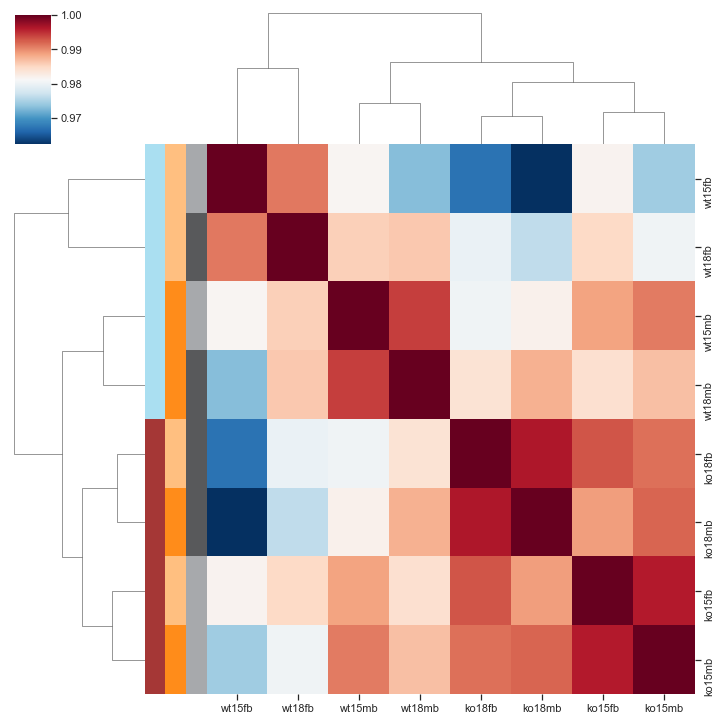

merged wt11fb1 wt11fb2
merged wt13fb1 wt13fb2
merged wt15fb1 wt15fb2
merged wt18fb1 wt18fb2
merged wt11mb1 wt11mb2
merged wt13mb1 wt13mb2
merged wt15mb1 wt15mb2
merged wt18mb1 wt18mb2
merged wt11hb1 wt11hb2
merged wt13hb1 wt13hb2
merged wt15hb1 wt15hb2
merged wt18hb1 wt18hb2
merged wt11sc1 wt11sc2
merged wt13sc1 wt13sc2
merged wt15sc1 wt15sc2
merged wt18sc1 wt18sc2
merged ko11fb1 ko11fb2
merged ko13fb1 ko13fb2
merged ko15fb1 ko15fb2
merged ko18fb1 ko18fb2
merged ko11mb1 ko11mb2
merged ko13mb1 ko13mb2
merged ko15mb1 ko15mb2
merged ko18mb1 ko18mb2
merged ko11hb1 ko11hb2
merged ko13hb1 ko13hb2
merged ko15hb1 ko15hb2
merged ko18hb1 ko18hb2
merged ko11sc1 ko11sc2
merged ko13sc1 ko13sc2
merged ko15sc1 ko15sc2
merged ko18sc1 ko18sc2
merged wt11fb1 wt11fb2
merged wt11mb1 wt11mb2
merged wt11hb1 wt11hb2
merged wt11sc1 wt11sc2
merged ko11fb1 ko11fb2
merged ko11mb1 ko11mb2
merged ko11hb1 ko11hb2
merged ko11sc1 ko11sc2
merged wt13fb1 wt13fb2
merged wt13mb1 wt13mb2
merged wt13hb1 wt13hb2
merged wt13

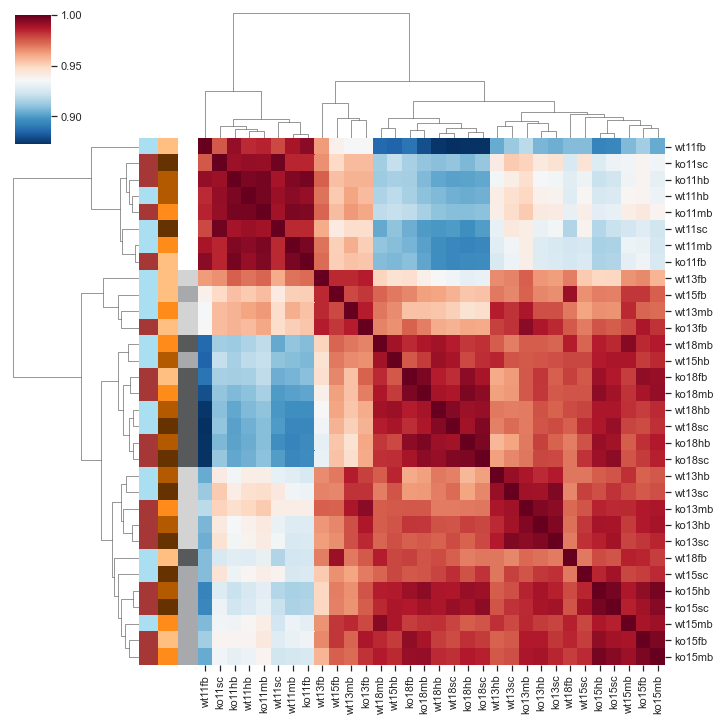

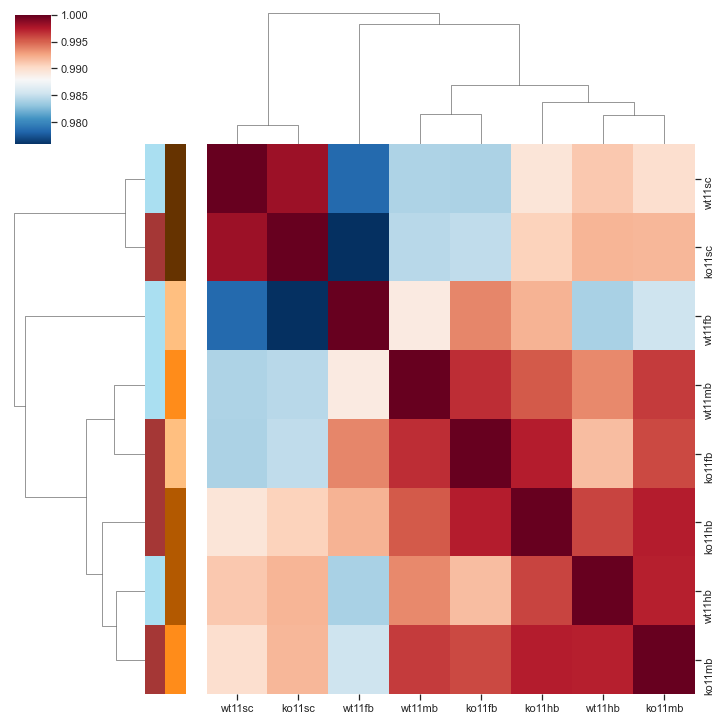

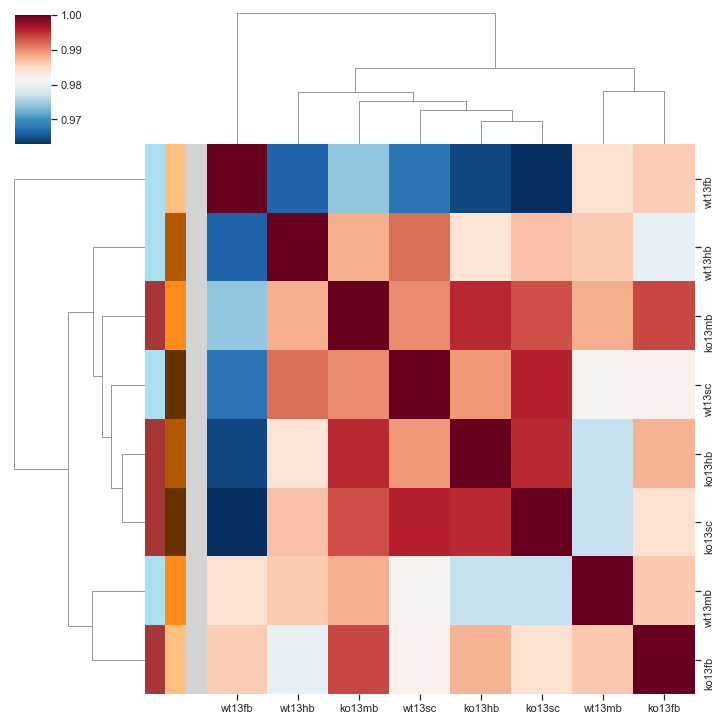

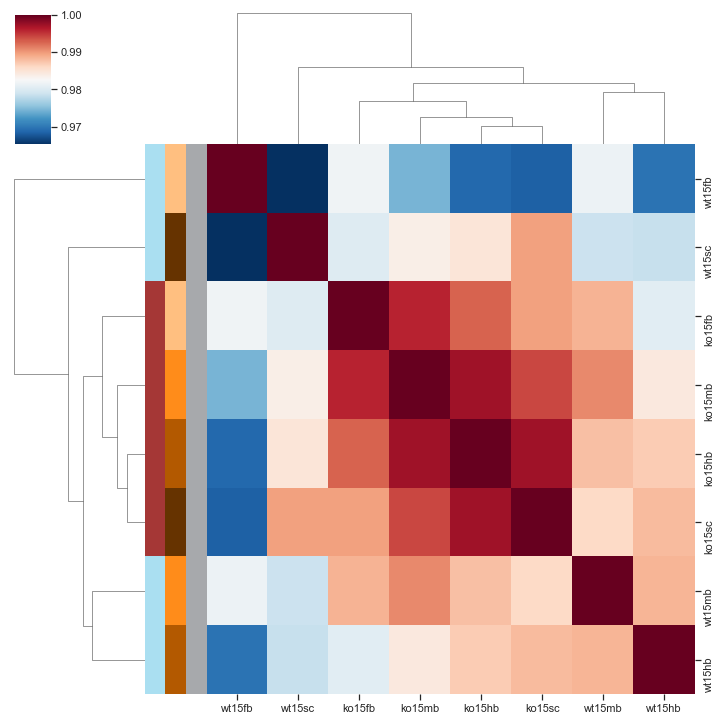

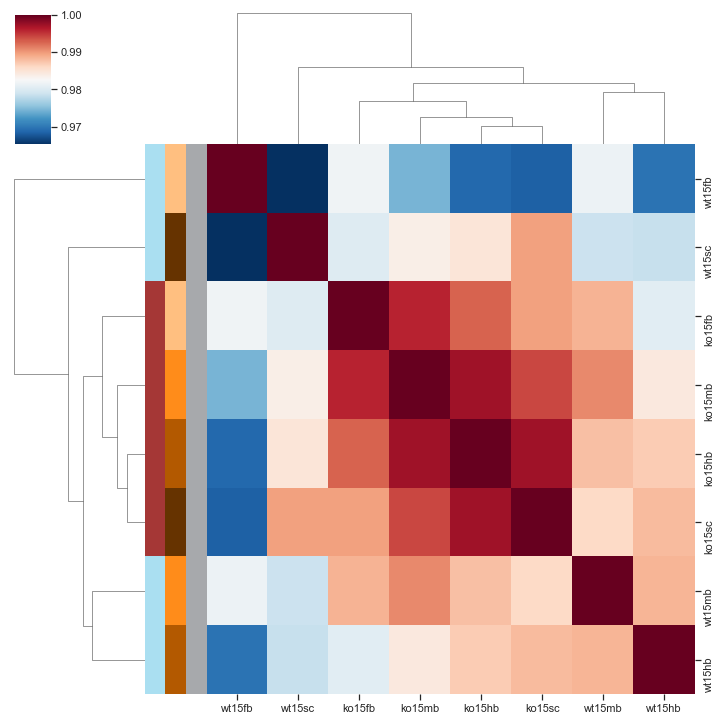

In [88]:
"""
---------------------------------------------------------------
            Sample clustermap for anterior late stage
---------------------------------------------------------------
"""
# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
log2_df = pd.DataFrame()
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
i = 0
tissue_colours = []
cond_colours = []
time_colours = []
while(i < len(cols_to_merge)):
    if ('mb' in cols_to_merge[i] or 'fb' in cols_to_merge[i]) and ('15' in cols_to_merge[i]  or '18' in cols_to_merge[i]):
        log2_df[cols_to_merge[i][:-1]] = 0.5 * ((df_all[cols_to_merge[i]].values + 1) +
                                                                    df_all[cols_to_merge[i + 1]].values)
        tissue_colours.append(get_tissue_colour(cols_to_merge[i]))
        time_colours.append(get_time_colour(cols_to_merge[i]))
        cond_colours.append(get_cond_colour(cols_to_merge[i]))

        print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
    
plt.rcParams['figure.figsize'] = [3, 3]

row_colors_t = [cond_colours, tissue_colours, time_colours]
corr = log2_df.corr()
sns.clustermap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
save_fig(f'Heatmap_sample_cluster')
plt.show()

"""
---------------------------------------------------------------
            Sample clustermap for all
---------------------------------------------------------------
"""
# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
log2_df = pd.DataFrame()
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
i = 0
tissue_colours = []
cond_colours = []
time_colours = []
while(i < len(cols_to_merge)):
    log2_df[cols_to_merge[i][:-1]] = 0.5 * ((df_all[cols_to_merge[i]].values + 1) +
                                                                df_all[cols_to_merge[i + 1]].values)
    tissue_colours.append(get_tissue_colour(cols_to_merge[i]))
    time_colours.append(get_time_colour(cols_to_merge[i]))
    cond_colours.append(get_cond_colour(cols_to_merge[i]))

    print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
    
plt.rcParams['figure.figsize'] = [3, 3]

row_colors_t = [cond_colours, tissue_colours, time_colours]
corr = log2_df.corr()
sns.clustermap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
save_fig(f'Heatmap_sample_cluster_all')


"""
---------------------------------------------------------------
            Sample clustermap for E11
---------------------------------------------------------------
"""
# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
log2_df = pd.DataFrame()
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
i = 0
tissue_colours = []
cond_colours = []
time_colours = []
while(i < len(cols_to_merge)):
    if '11' in cols_to_merge[i]:
        log2_df[cols_to_merge[i][:-1]] = 0.5 * ((df_all[cols_to_merge[i]].values + 1) +
                                                                    df_all[cols_to_merge[i + 1]].values)
        tissue_colours.append(get_tissue_colour(cols_to_merge[i]))
        time_colours.append(get_time_colour(cols_to_merge[i]))
        cond_colours.append(get_cond_colour(cols_to_merge[i]))

        print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
    
plt.rcParams['figure.figsize'] = [3, 3]

row_colors_t = [cond_colours, tissue_colours, time_colours]
corr = log2_df.corr()
sns.clustermap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
save_fig(f'Heatmap_sample_cluster_Ell')


"""
---------------------------------------------------------------
            Sample clustermap for E13
---------------------------------------------------------------
"""
# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
log2_df = pd.DataFrame()
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
i = 0
tissue_colours = []
cond_colours = []
time_colours = []
while(i < len(cols_to_merge)):
    if '13' in cols_to_merge[i]:
        log2_df[cols_to_merge[i][:-1]] = 0.5 * ((df_all[cols_to_merge[i]].values + 1) +
                                                                    df_all[cols_to_merge[i + 1]].values)
        tissue_colours.append(get_tissue_colour(cols_to_merge[i]))
        time_colours.append(get_time_colour(cols_to_merge[i]))
        cond_colours.append(get_cond_colour(cols_to_merge[i]))

        print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
    
plt.rcParams['figure.figsize'] = [3, 3]

row_colors_t = [cond_colours, tissue_colours, time_colours]
corr = log2_df.corr()
sns.clustermap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
save_fig(f'Heatmap_sample_cluster_El3')


"""
---------------------------------------------------------------
            Sample clustermap for E15
---------------------------------------------------------------
"""
# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
log2_df = pd.DataFrame()
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
i = 0
tissue_colours = []
cond_colours = []
time_colours = []
while(i < len(cols_to_merge)):
    if '15' in cols_to_merge[i]:
        log2_df[cols_to_merge[i][:-1]] = 0.5 * ((df_all[cols_to_merge[i]].values + 1) +
                                                                    df_all[cols_to_merge[i + 1]].values)
        tissue_colours.append(get_tissue_colour(cols_to_merge[i]))
        time_colours.append(get_time_colour(cols_to_merge[i]))
        cond_colours.append(get_cond_colour(cols_to_merge[i]))

        print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
    
plt.rcParams['figure.figsize'] = [3, 3]

row_colors_t = [cond_colours, tissue_colours, time_colours]
corr = log2_df.corr()
sns.clustermap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
save_fig(f'Heatmap_sample_cluster_El5')


"""
---------------------------------------------------------------
            Sample clustermap for E18
---------------------------------------------------------------
"""
# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
log2_df = pd.DataFrame()
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
i = 0
tissue_colours = []
cond_colours = []
time_colours = []
while(i < len(cols_to_merge)):
    if '15' in cols_to_merge[i]:
        log2_df[cols_to_merge[i][:-1]] = 0.5 * ((df_all[cols_to_merge[i]].values + 1) +
                                                                    df_all[cols_to_merge[i + 1]].values)
        tissue_colours.append(get_tissue_colour(cols_to_merge[i]))
        time_colours.append(get_time_colour(cols_to_merge[i]))
        cond_colours.append(get_cond_colour(cols_to_merge[i]))

        print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
plt.rcParams['figure.figsize'] = [3, 3]

row_colors_t = [cond_colours, tissue_colours, time_colours]
corr = log2_df.corr()
sns.clustermap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
save_fig(f'Heatmap_sample_cluster_El8')

## Plot heatmaps of samples RNAseq

Plot the top and bottom of the heatmaps of each of the DE analyses.

merged wt11fb1 wt11fb2
merged wt13fb1 wt13fb2
merged wt15fb1 wt15fb2
merged wt18fb1 wt18fb2
merged wt11mb1 wt11mb2
merged wt13mb1 wt13mb2
merged wt15mb1 wt15mb2
merged wt18mb1 wt18mb2
merged wt11hb1 wt11hb2
merged wt13hb1 wt13hb2
merged wt15hb1 wt15hb2
merged wt18hb1 wt18hb2
merged wt11sc1 wt11sc2
merged wt13sc1 wt13sc2
merged wt15sc1 wt15sc2
merged wt18sc1 wt18sc2
merged ko11fb1 ko11fb2
merged ko13fb1 ko13fb2
merged ko15fb1 ko15fb2
merged ko18fb1 ko18fb2
merged ko11mb1 ko11mb2
merged ko13mb1 ko13mb2
merged ko15mb1 ko15mb2
merged ko18mb1 ko18mb2
merged ko11hb1 ko11hb2
merged ko13hb1 ko13hb2
merged ko15hb1 ko15hb2
merged ko18hb1 ko18hb2
merged ko11sc1 ko11sc2
merged ko13sc1 ko13sc2
merged ko15sc1 ko15sc2
merged ko18sc1 ko18sc2
wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merge

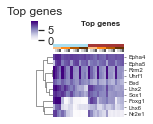

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


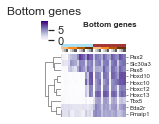

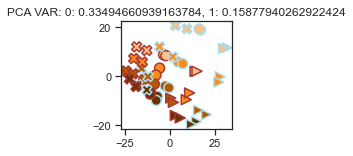

In [34]:
"""
---------------------------------------------------------------
            Select top 20 DE genes (by padj in Forebrain)
---------------------------------------------------------------
"""
n_genes = 10
n_g_neg = -10
# Select the locfc that is the forebrain WT vs KO
merged_df = df_all.copy()

cols_to_merge = [c for c in merged_df.columns if 'wt' in c or 'ko' in c]
col_names = []
col_values = []
values = merged_df[cols_to_merge].values
i = 0
while(i < len(cols_to_merge)):
    merged_df[f'{cols_to_merge[i][:-1]}_merged-rep'] = 0.5 * (merged_df[cols_to_merge[i]].values +
                                                                merged_df[cols_to_merge[i + 1]].values)
    print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2

log2FoldChange = merged_df['stat'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_genes)[:n_genes]) # np.argpartition(x, -k)[-k:]

col_colours = ['#6666ff'] * n_genes + ['#990033'] * n_genes

"""
---------------------------------------------------------------
            Plot heatmap
---------------------------------------------------------------
"""

plt_heatmap(merged_df, selected_idxs, f'Top genes', False, row_colours=None, cond="")
plt.show()

selected_idxs = list(np.argpartition(log2FoldChange, n_g_neg)[n_g_neg:])
plt_heatmap(merged_df, selected_idxs, f'Bottom genes', False, row_colours=None, cond="")
plt.show()

"""
---------------------------------------------------------------
            Setup PCA
---------------------------------------------------------------
"""
cols, edges = [], []
e13, e13_colours = [], []
e18, e18_colours = [], []
e15, e15_colours = [], []
c_i = 0
line_styles = []
for c in df_all.columns:
    if ('wt' in c or 'ko' in c) and '11' not in c:
        cols.append(c)
        if '13' in c:
            e13.append(c_i)
            e13_colours.append(get_tissue_colour(c))
        elif '15' in c:
            e15.append(c_i)
            e15_colours.append(get_tissue_colour(c))
        elif '18' in c:
            e18.append(c_i)
            e18_colours.append(get_tissue_colour(c))
            # Make the edges the colour of our condition
            edges.append(get_cond_colour(c))
            if 'wt' in c:
                line_styles.append('-')
            else:
                line_styles.append('-')
        c_i += 1

vals = np.log2(df_all[cols].values + 1).T
fb_pca = PCA(n_components=2)
fb_pca_values = fb_pca.fit_transform(vals)
var_ratio = fb_pca.fit(vals).explained_variance_ratio_

"""
---------------------------------------------------------------
            Plot PCA
---------------------------------------------------------------
"""
plt.rcParams['figure.figsize'] = [2, 2]

plt.scatter(fb_pca_values[e13,0], fb_pca_values[e13,1], linestyle=line_styles, c=e13_colours, s=100, marker=">", edgecolors=edges, linewidths=1.5)
plt.scatter(fb_pca_values[e15,0], fb_pca_values[e15,1], linestyle=line_styles, c=e15_colours, s=100, marker="o", edgecolors=edges, linewidths=1.5)
plt.scatter(fb_pca_values[e18,0], fb_pca_values[e18,1], linestyle=line_styles, c=e18_colours, s=100, marker="X", edgecolors=edges, linewidths=1.5)

plt.title(f'PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
save_fig(f'PCA_ne11_fb')
# Now we want to fit everything except the gene IDs 
plt.show()

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


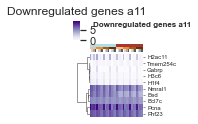

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


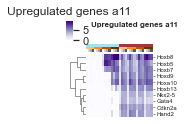

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


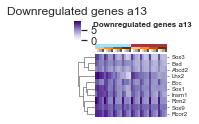

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


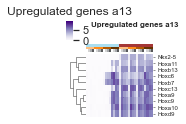

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


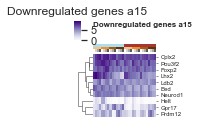

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


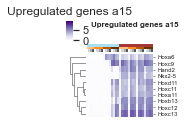

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


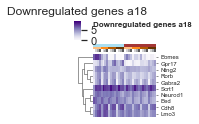

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


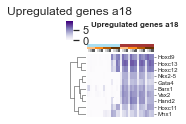

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


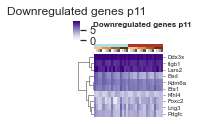

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


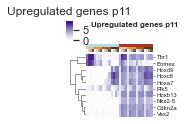

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


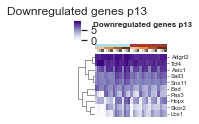

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


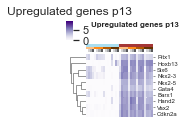

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


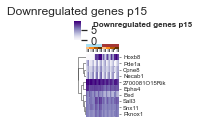

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


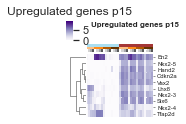

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


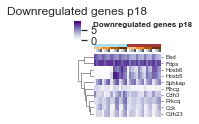

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


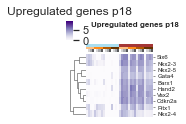

In [35]:
"""
---------------------------------------------------------------
            Select top 20 DE genes (by padj in Forebrain)
---------------------------------------------------------------
"""
n_genes = 10
n_g_neg = -10
val = 'stat'
# Select the locfc that is the forebrain WT vs KO
for cond in ['a11', 'a13', 'a15', 'a18', 'p11', 'p13', 'p15', 'p18']:
    e18_gene_df = merged_df.copy()

    log2FoldChange = e18_gene_df[f'{val}_{cond}'].values
    selected_idxs = list(np.argpartition(log2FoldChange, n_genes)[:n_genes]) # np.argpartition(x, -k)[-k:]


    col_colours = ['#6666ff'] * n_genes + ['#990033'] * n_genes

    """
    ---------------------------------------------------------------
                Plot heatmap
    ---------------------------------------------------------------
    """

    plt_heatmap(merged_df, selected_idxs, f'Downregulated genes {cond}', False, row_colours=None)
    plt.show()

    log2FoldChange = e18_gene_df[f'log2FoldChange_{cond}'].values
    selected_idxs = list(np.argpartition(log2FoldChange, n_g_neg)[n_g_neg:])
    plt_heatmap(merged_df, selected_idxs, f'Upregulated genes {cond}', False, row_colours=None)
    plt.show()



wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


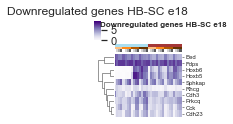

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


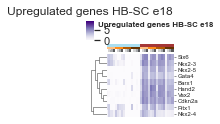

In [36]:
"""
---------------------------------------------------------------
            Select top 20 DE genes (by padj in Forebrain)
---------------------------------------------------------------
"""
n_genes = 10
n_g_neg = -10
# Select the locfc that is the forebrain WT vs KO
e18_gene_df = merged_df.copy()

log2FoldChange = e18_gene_df['stat_p18'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_genes)[:n_genes]) # np.argpartition(x, -k)[-k:]


col_colours = ['#6666ff'] * n_genes + ['#990033'] * n_genes

"""
---------------------------------------------------------------
            Plot heatmap
---------------------------------------------------------------
"""

plt_heatmap(merged_df, selected_idxs, f'Downregulated genes HB-SC e18', False, row_colours=None)
plt.show()

log2FoldChange = e18_gene_df['log2FoldChange_p18'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_g_neg)[n_g_neg:])
plt_heatmap(merged_df, selected_idxs, f'Upregulated genes HB-SC e18', False, row_colours=None)
plt.show()



wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


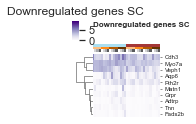

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


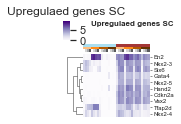

In [37]:
"""
---------------------------------------------------------------
            Select top 20 DE genes (by padj in Forebrain)
---------------------------------------------------------------
"""
n_genes = 10
n_g_neg = -10
# Select the locfc that is the forebrain WT vs KO
e18_gene_df = merged_df.copy()

log2FoldChange = e18_gene_df['log2FoldChange_sc'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_genes)[:n_genes]) # np.argpartition(x, -k)[-k:]


col_colours = ['#6666ff'] * n_genes + ['#990033'] * n_genes

"""
---------------------------------------------------------------
            Plot heatmap
---------------------------------------------------------------
"""

plt_heatmap(merged_df, selected_idxs, f'Downregulated genes SC', False, row_colours=None)
plt.show()

log2FoldChange = e18_gene_df['log2FoldChange_sc'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_g_neg)[n_g_neg:])
plt_heatmap(merged_df, selected_idxs, f'Upregulaed genes SC', False, row_colours=None)
plt.show()



wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


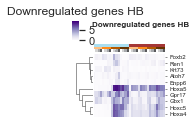

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


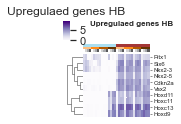

In [38]:
"""
---------------------------------------------------------------
            Select top 20 DE genes (by padj in Forebrain)
---------------------------------------------------------------
"""
n_genes = 10
n_g_neg = -10
# Select the locfc that is the forebrain WT vs KO
e18_gene_df = merged_df.copy()

log2FoldChange = e18_gene_df['log2FoldChange_hb'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_genes)[:n_genes]) # np.argpartition(x, -k)[-k:]


col_colours = ['#6666ff'] * n_genes + ['#990033'] * n_genes

"""
---------------------------------------------------------------
            Plot heatmap
---------------------------------------------------------------
"""

plt_heatmap(merged_df, selected_idxs, f'Downregulated genes HB', False, row_colours=None)
plt.show()

log2FoldChange = e18_gene_df['log2FoldChange_hb'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_g_neg)[n_g_neg:])
plt_heatmap(merged_df, selected_idxs, f'Upregulaed genes HB', False, row_colours=None)
plt.show()



wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


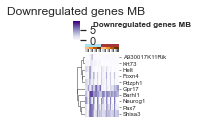

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep
ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


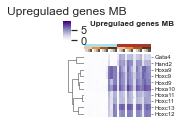

In [39]:
"""
---------------------------------------------------------------
            Select top 20 DE genes (by padj in Forebrain)
---------------------------------------------------------------
"""
n_genes = 10
n_g_neg = -10
# Select the locfc that is the forebrain WT vs KO
e18_gene_df = merged_df.copy()

log2FoldChange = e18_gene_df['log2FoldChange_mb'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_genes)[:n_genes]) # np.argpartition(x, -k)[-k:]


col_colours = ['#6666ff'] * n_genes + ['#990033'] * n_genes

"""
---------------------------------------------------------------
            Plot heatmap
---------------------------------------------------------------
"""

plt_heatmap(merged_df, selected_idxs, f'Downregulated genes MB', False, row_colours=None)
plt.show()

log2FoldChange = e18_gene_df['log2FoldChange_mb'].values
selected_idxs = list(np.argpartition(log2FoldChange, n_g_neg)[n_g_neg:])
plt_heatmap(merged_df, selected_idxs, f'Upregulaed genes MB', False, row_colours=None)
plt.show()



## Heatmaps of marker genes in WT and KO


In [40]:

gene_markers_sep = [['Foxg1', 'Tbr1', 'Emx1', 'Eomes'], 
                    ['Bhlhe23', 'En2', 'Fev', 'Phox2b'], 
                    ['Hoxb9', 'Hoxc9', 'Hoxd9', 'Hoxc12'],
                    ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11', 
                    'Hoxa13', 'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
                    ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a', 
                    'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a'],
                    ['Cdkn1a', 'Cdkn1b', 'Cdkn1c', 'Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d'],
                    ['Sox1', 'Sox2', 'Sox3'],
                    ['Snap25', 'Syt1', 'Slc32a1','Slc17a6', 'Syn1'],
                    ['Cspg4', 'Aqp4', 'Slc6a11', 'Olig1', 'Igfbp3']
                    ]

marker_labels_sep = ['Forebrain', 'Midbrain', 'Hindbrain',  'Spinalcord', 
                     'Proliferation', 'Neg. reg. Cell Cycle', 
                    'Progenitors', 'Neurons', 'Glia'
                    ]


wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


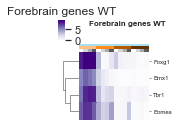

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


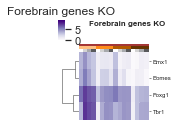

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


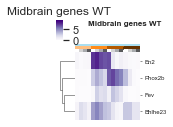

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


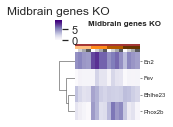

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


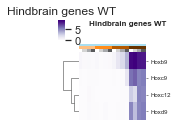

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


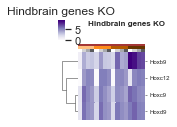

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


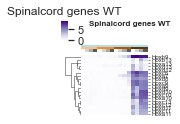

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


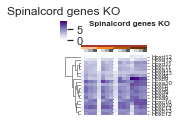

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


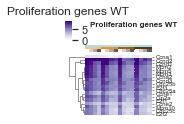

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


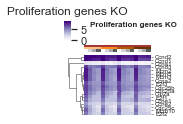

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


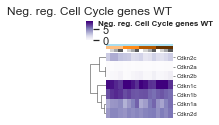

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


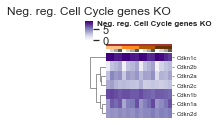

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


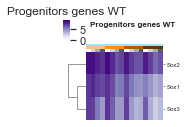

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


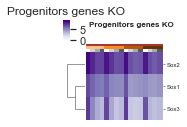

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


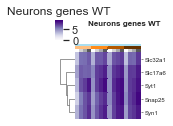

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


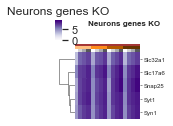

wt11fb_merged-rep
wt13fb_merged-rep
wt15fb_merged-rep
wt18fb_merged-rep
wt11mb_merged-rep
wt13mb_merged-rep
wt15mb_merged-rep
wt18mb_merged-rep
wt11hb_merged-rep
wt13hb_merged-rep
wt15hb_merged-rep
wt18hb_merged-rep
wt11sc_merged-rep
wt13sc_merged-rep
wt15sc_merged-rep
wt18sc_merged-rep


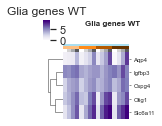

ko11fb_merged-rep
ko13fb_merged-rep
ko15fb_merged-rep
ko18fb_merged-rep
ko11mb_merged-rep
ko13mb_merged-rep
ko15mb_merged-rep
ko18mb_merged-rep
ko11hb_merged-rep
ko13hb_merged-rep
ko15hb_merged-rep
ko18hb_merged-rep
ko11sc_merged-rep
ko13sc_merged-rep
ko15sc_merged-rep
ko18sc_merged-rep


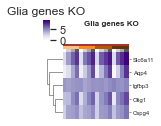

In [41]:

for i, genes in enumerate(gene_markers_sep):
    selected_idxs = []
    for j, gene in enumerate(df_all[gene_name].values):
        if gene in genes:
            selected_idxs.append(j)
    plt_heatmap(merged_df, selected_idxs, marker_labels_sep[i] + " genes WT", False, row_colours=None, cond='wt')
    plt_heatmap(merged_df, selected_idxs, marker_labels_sep[i] + " genes KO", False, row_colours=None, cond='ko')

    plt.show()

## 10) Add Epigenetic data from Encode
We downloaded and processed the data according to the notebook DownloadEncode. Now we want to merge the peak files with 
our RNAseq data. 

Here we keep the signal with the highest value as multiple may have been added. 

Keeping in mind, we have potentially the same peak assigned to many genes. This is particularly evident in the H3K27me3 
broad peak data.

First we download an annotation from 
We use sciloc2gene v1.0.0 to annotate this information.

Note you may need to check the reference used for the peak files (this was not needed since we also used Ensembl to map our gene's and find their location).

Need to download the annotation from: https://www.encodeproject.org/references/ENCSR425FOI/
ENCFF871VGROpen file informationDownload	gtf	genome reference	mm10	M21

Convert the GTF to a bed and then sort the bed file (convert using gtf2bed v0.11.0 downloaded frmo https://github.com/fls-bioinformatics-core/GFFUtils/tree/master)
gtf2bed ENCFF871VGR.gtf > ENCFF871VGR_mm10-m21_encode.bed

Then we convert to a CSV file and sort it by TSS.
```
def run_parallel(self):
    data_dir = 'data/encode/histone_modifications/beds_cns/encode/sorted_bed/'
    files = os.listdir(data_dir)
    files_to_run = []
    for filename in files:
        files_to_run.append(filename)
    # Run in paralell
    pool = ThreadPool(12)
    results = pool.map(run_bed, files_to_run)


def run_bed(filename):
    base_dir = 'data/encode/histone_modifications/beds_cns/encode/'
    data_dir = f'{base_dir}sorted_bed/'
    output_dir = f'{base_dir}scie2g_28102020/'
    overlap_method = 'in_promoter'
    if 'H3K9me3' in filename or 'H3K36me3' in filename:
        overlap_method = 'overlaps'
    #ensembl_gene_id, entrezgene_id, external_gene_name, chromosome_name, start_position, end_position, strand
    bed = Bed(f'{data_dir}{filename}', overlap_method=overlap_method,
              output_bed_file=f'{output_dir}selected_peaks/{filename}',
              buffer_after_tss=1500,
              buffer_before_tss=5000,
              buffer_gene_overlap=1500,
              chr_idx=0, start_idx=1,
              end_idx=2, peak_value=6, header_extra='8,9',
              header="chr,start,end,signal,qvalue,peak",
              gene_start=4, gene_end=5, gene_direction=6, gene_chr=3, gene_name=0
              )
    # Use your annotation file i.e. for humans
    bed.set_annotation_from_file('../supps/mm10Sorted_mmusculus_gene_ensembl-GRCm38.p6.csv')
    # Now we can run the assign values
    bed.assign_locations_to_genes()
    bed.save_loc_to_csv(f'{output_dir}parsed_files/{filename[:-3]}csv', keep_unassigned=True)
```


In [42]:
"""
--------------------------------------------------------
Add Epigenetic data to the RNAseq dataframe
--------------------------------------------------------
"""

%matplotlib inline

def add_peak_file(df, filename):
    # Make a dictionary from the key being the gene id to the value (width)
    mapping = {}
    mapping_signals = {}

    file_df = pd.read_csv(f'{chip_dir}{filename}')
    
    # Keep the max value
    signals = file_df['signal'].values
    widths = file_df['width'].values
    qvalues = file_df['qvalue'].values # q-value at position 9 i.e. 9 - 1 = 8
    
    # Only keep peaks that were significant i.e. qvalue > -1 * log10(0.05) ~ 1.3
    for i, g in enumerate(file_df[gene_id].values):
        qvalue = qvalues[i]
        if qvalue > 1.3:
            if not mapping.get(g):
                mapping[g] = widths[i]
                mapping_signals[g] = signals[i]
            else:
                mapping[g] = widths[i] if widths[i] > mapping[g] else mapping[g]
                # Keep the signal that corresponds to the widest peak
                mapping_signals[g] = signals[i] if widths[i] > mapping[g] else mapping_signals[g]
    # Now we want to iterate through the genes in the df and add them
    widths_ordered = []
    signals_ordered = []
    fname = filename[:-4]
    for g in df[gene_id].values:
        widths_ordered.append(mapping.get(g))
        signals_ordered.append(mapping_signals.get(g))
        
    df[f'{fname}_width'] = widths_ordered
    df[f'{fname}_signal'] = signals_ordered

    return df

# Now we want to add our chipseq data from Encode
chip_dir = os.path.join(input_dir, f'scie2g_b2500_g500/parsed_files/')
files = os.listdir(chip_dir)

chip_files = []
mark_locations = []
for f in files:
    if '.csv' in f and '.swp' not in f and 'embryonic_' in f:
        chip_files.append(f)

chip_files.sort()

# Add them to the dataframe
dfs = []
for filename in chip_files:
    u.dp(["Adding", filename])
    df_all = add_peak_file(df_all, filename)

--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR.csv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB.csv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD.csv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_10.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF053GHW.csv	
---------------------------------------------------------------------------

--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_14.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF531BZD.csv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_14.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF703RVX.csv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_14.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF012TIE.csv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Adding	embryonic-facial-prominence_14.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF027YKW.csv	
---------------------------------------------------------------------------

--------------------------------------------------------------------------------
    Adding	forebrain_12.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF397HZX.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	forebrain_12.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF744VBB.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	forebrain_12.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF191DCQ.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	forebrain_12.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF077LYY.csv	     
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
     Adding	forebrain_16.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF378OWA.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	forebrain_16.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF686XPK.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	forebrain_16.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF788EJN.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	forebrain_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF502DRX.csv	     
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
      Adding	heart_13.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF311HQB.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
      Adding	heart_13.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF924ZOT.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	heart_13.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF649ZZL.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	heart_13.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF454NBK.csv	       
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
       Adding	heart_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF003WOW.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	heart_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF179PHX.csv	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	heart_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF801DMR.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	hindbrain_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF751ZHP.csv	     
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
     Adding	hindbrain_13.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF840MRK.csv	      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	hindbrain_13.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF292IDK.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	hindbrain_14.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF157AZQ.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	hindbrain_14.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF658ZBC.csv	     
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
     Adding	intestine_14.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF854JVF.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	intestine_14.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF406MRQ.csv	      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	intestine_14.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF010EOK.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	intestine_15.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF378DZY.csv	     
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
      Adding	kidney_15.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF066PLX.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
      Adding	kidney_15.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF207JEH.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	kidney_15.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF529SOW.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
      Adding	kidney_15.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF700ZGY.csv	       
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
        Adding	limb_12.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF482OCW.csv	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	limb_12.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF425DTV.csv	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	limb_13.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF467HTN.csv	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	limb_13.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF718DIQ.csv	       
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
       Adding	liver_11.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF482JBE.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	liver_11.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF343AOE.csv	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	liver_11.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF470CWQ.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	liver_12.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF974RAJ.csv	       
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
      Adding	liver_15.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF398IQT.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
      Adding	liver_15.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF706TOV.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	liver_15.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF938YRV.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	liver_15.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF860WOO.csv	       
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
       Adding	lung_16.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF913XPA.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	lung_16.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF782HRY.csv	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	lung_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF696ERS.csv	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Adding	lung_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF593MNH.csv	        
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
     Adding	midbrain_13.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF005PXT.csv	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	midbrain_13.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF097SDI.csv	      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	midbrain_13.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF872YAF.csv	      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     Adding	midbrain_13.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF095ZPA.csv	      
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
   Adding	neural-tube_11.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF090NYW.csv	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
   Adding	neural-tube_11.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF567RNX.csv	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	neural-tube_11.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF211AEC.csv	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	neural-tube_11.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF105KTG.csv	    
--------------------------------------------------------------------------------
----------------------------

--------------------------------------------------------------------------------
   Adding	neural-tube_15.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF432THP.csv	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
   Adding	neural-tube_15.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF842ZMC.csv	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	neural-tube_15.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF832NUL.csv	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    Adding	neural-tube_15.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF112TNK.csv	    
--------------------------------------------------------------------------------
----------------------------

## 11) Filter the merged dataframe

Since we have merged so many dataframes there are likely to be many missing values.

We want to first drop any rows that are duplicates & 2) fill in null values with 0's (otherwise we'll get errors 
when running analyses).

We also want to organise the columns of the dataframe (this makes it easier for charts later on).

Lastly, we are only interested in genes that had a significant change between WT and KO (we want to desipher WHY this occured), so we drop any data with a non-sig result.

Filtering steps:

    1) Keep genes if padj < 0.05 in at least one experiment, THEN
    2) Keep genes if genes were expressed in WT or KO tissues with at least an average TMM of 2, THEN
    3) Keep genes if genes at least one experiment recorded a log fold change of > 1.0
  
This dataset will be used for our VAE analysis.

In [43]:
# Keep only the significant data i.e. the data where at least one of the p values was < 0.05
genes_to_keep = []
ps = ((1.0 * (df_all['padj_sc'].values < 0.05)) + (1.0 * (df_all['padj_mb'].values < 0.05))
     +  (1.0 * (df_all['padj_hb'].values < 0.05)) + (1.0 * (df_all['padj_fb'].values < 0.05))
     + (1.0 * (df_all['padj_a11'].values < 0.05)) 
     + (1.0 * (df_all['padj_a13'].values < 0.05)) 
     + (1.0 * (df_all['padj_a15'].values < 0.05))
     + (1.0 * (df_all['padj_a18'].values < 0.05)))


df_all['p_mask'] = ps

# Now we also want to make sure that in each of these datasets, we have at least 2 TMM average in either WT or KO
# We don't want the genes that have super low expression since that is not interesting for our downstream analyses
wt_cols = [c for c in df_all.columns if 'wt' in c]
ko_cols = [c for c in df_all.columns if 'ko' in c]
tmm_cutoff = 0.5

expression_mask = ((1.0 * (np.mean(df_all[wt_cols].values, axis=1) >= tmm_cutoff)) + (1.0 * (np.mean(df_all[ko_cols].values, axis=1) >= tmm_cutoff)))
df_all['expression_mask'] = expression_mask

# Make a DF that only has genes that are significant at the 0.05 level
df_sig = df_all[df_all['p_mask'] > 0]

# Make a DF that only has genes that are minimally expressed in at least one condition
df_sig = df_sig[df_sig['expression_mask'] > 0]

u.dp(['Number of significant rows: ', len(df_sig)])

# Let's also make sure that we can keep have genes that have at least an absolute logfc of 0.5
log_str = 'log2FoldChange'
logfc_cols = [c for c in df_sig.columns if log_str in c]
mean_logfc = np.mean(abs(df_sig[logfc_cols].values), axis=1)


cutoff = 1.0
logfc = ((1.0 * (abs(df_sig[f'{log_str}_sc'].values) > cutoff)) 
         + (1.0 * (abs(df_sig[f'{log_str}_mb'].values) > cutoff)) 
         + (1.0 * (abs(df_sig[f'{log_str}_hb'].values) > cutoff)) 
         + (1.0 * (abs(df_sig[f'{log_str}_fb'].values) > cutoff)) 
         + (1.0 * (abs(df_sig[f'{log_str}_a11'].values) > cutoff))
         + (1.0 * (abs(df_sig[f'{log_str}_a13'].values) > cutoff)) 
         + (1.0 * (abs(df_sig[f'{log_str}_a15'].values) > cutoff)) 
         + (1.0 * (abs(df_sig[f'{log_str}_a18'].values) > cutoff))
        )

df_sig['logfc_mask'] = logfc
df_sig_2 = df_sig[df_sig['logfc_mask'] > 2]  # Require two of the conditions it to be met
df_sig_1 = df_sig[df_sig['logfc_mask'] > 0]  # Require two of the conditions it to be met

u.dp(['Number of significant rows with an absolute FC > 1.0: ', len(df_sig_1)])
u.dp(['Number of significant rows with 2 values absolute FC > 2.0: ', len(df_sig_2)])

# Save all to dataframes
df_sig_1.to_csv(f'{output_dir}df-sig_1_epi-2500_{date}.csv', index=False)
df_sig_2.to_csv(f'{output_dir}df-consistent_epi-2500_{date}.csv', index=False)
df_sig.to_csv(f'{output_dir}df-significant_epi-2500_{date}.csv', index=False)
df_all.to_csv(f'{output_dir}df-all_epi-2500_{date}.csv', index=False)

# --------------------------------------------------------------------------------
#                       Number of significant rows: 	12532	                       
# --------------------------------------------------------------------------------
# --------------------------------------------------------------------------------
#           Number of significant rows with an absolute FC > 1.0: 	2944	          
# --------------------------------------------------------------------------------
# --------------------------------------------------------------------------------
#        Number of significant rows with 2 values absolute FC > 2.0: 	1928	       
# --------------------------------------------------------------------------------

gene_markers_sep = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6'], 
                    ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4'], 
                    ['Hoxb1', 'Krox20', 'Fev', 'Hoxd3', 'Phox2b'],
                    ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11', 
                    'Hoxa13', 'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
                    ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a', 
                    'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a'],
                    ['Cdkn1a', 'Cdkn1b', 'Cdkn1c', 'Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d'],
                    ['Sox2', 'Sox1', 'Sox3', 'Hes1', 'Hes5'],
                    ['Snap25', 'Syt1', 'Slc32a1','Slc17a6', 'Syn1'],
                    ['Cspg4', 'Aqp4', 'Slc6a11', 'Olig1', 'Igfbp3'],
                    ['Foxg1'], 
                    ['En2'], 
                    ['Phox2b'],
                    ['Hoxc9'],
                    ['Sox3']
                    ]
for ml in gene_markers_sep:
    print("\n")
    for m in ml:
        for g in df_sig_1[gene_name].values:
            try:
                if g == m:
                    print(g)
            except:
                x = 0

--------------------------------------------------------------------------------
                      Number of significant rows: 	12797	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
          Number of significant rows with an absolute FC > 1.0: 	3148	          
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       Number of significant rows with 2 values absolute FC > 2.0: 	1371	       
--------------------------------------------------------------------------------


Emx1
Eomes
Tbr1
Foxg1
Lhx6


En1
En2
Lmx1a
Bhlhe23
Sall4


Hoxb1
Fev
Hoxd3
Phox2b


Hoxd8
Hoxd9
Hoxd10
Hoxd11
Hoxd13
Hoxa7
Hoxa9
Hoxa10
Hoxa11
Hoxa13
Hoxb9
Hoxb13
Hoxc8
Hoxc9
Hoxc10
Hoxc11
Hoxc12
Hoxc13


Ccna2
Ccnd1
Ccnd2
Cdc25c
E2f1
E2f2
Mcm10
Mcm5
Mcm3
Mcm2
Cip2a




In [24]:
pd.read_csv(f'{output_dir}df-significant_epi-2500_{date}.csv')

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


level_0  entrezgene_id external_gene_name     ensembl_gene_id chrs  \
0            0         497097               Xkr4  ENSMUSG00000051951    1   
1            2          20671              Sox17  ENSMUSG00000025902    1   
2            3          27395             Mrpl15  ENSMUSG00000033845    1   
3            5          21399              Tcea1  ENSMUSG00000033813    1   
4            6          58175              Rgs20  ENSMUSG00000002459    1   
...        ...            ...                ...                 ...  ...   
12792    20799         333605             Frmpd4  ENSMUSG00000049176    X   
12793    20800          17692               Msl3  ENSMUSG00000031358    X   
12794    20801          11856            Arhgap6  ENSMUSG00000031355    X   
12795    20803          15159               Hccs  ENSMUSG00000031352    X   
12796    20804          17318               Mid1  ENSMUSG00000035299    X   

        wt11fb1   wt11fb2   wt13fb1   wt13fb2   wt15fb1  ...  \
0      1.887233  1.194021  3.384810  3.413348  4.543870  ...   
1      3.330280  3.188772  3.153470  3.189883  3.085838  ...   
2      5.872648  6.170291  5.624924  5.587420  5.398727  ...   
3      7.086790  7.351565  5.607660  5.387271  7.077901  ...   
4      1.856543  1.628928  3.955603  4.070196  3.762770  ...   
...         ...       ...       ...       ...       ...  ...   
12792  0.603204  0.568481  1.648271  1.506013  2.998638  ...   
12793  5.373746  5.519459  5.302895  5.203288  4.979234  ...   
12794  1.760348  2.069270  1.287377  1.272363  1.377225  ...   
12795  5.325070  5.388558  5.313581  5.184317  5.129605  ...   
12796  5.025050  5.120363  4.532705  4.070196  5.088845  ...   

       stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_signal  \
0                                               32.56543                 
1                                               17.05396                 
2                                               32.48818                 
3                                               12.89607                 
4                                                    NaN                 
...                                                  ...                 
12792                                                NaN                 
12793                                           21.82412                 
12794                                           23.78164                 
12795                                           17.11209                 
12796                                            7.41834                 

       stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_width  \
0                                                 2456.0                
1                                                 1257.0                
2                                                 2048.0                
3                                                 2526.0                
4                                                    NaN                
...                                                  ...                
12792                                                NaN                
12793                                             3127.0                
12794                                             2420.0                
12795                                             2270.0                
12796                                             1159.0                

       stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_signal  \
0                                               37.44113                 
1                                               14.96443                 
2                                               41.08784                 
3                                               55.09949                 
4                                                    NaN                 
...                                                  ...                 
12792                        

## 12) Setup functions for simple analyses


We want to test whether some simple things are enriched or not. i.e. do we see different annotations if we look at the genes that were 1) significant a) with H3K27me3, b) without H3K27me3, 2) non-significant a) with H3K27me3, b) without H3K27me3.

For each of these groups we want to:

    1) test for annotation enrichment
    2) plot the overal HM profile 
    3) plot the overal gene expression profile.

In [9]:
! pip install venn

  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19701 sha256=0caba4a04fc9847b9027f2691202659fe2437e2e752e78e4b2465e526e704717
  Stored in directory: /Users/ariane/Library/Caches/pip/wheels/3c/4a/19/23397c245ac8eb77245b88c0929b53a850a56ee87f089b3e9e
Successfully built venn


In [13]:
df_all = pd.read_csv(f'{output_dir}df-all_epi-2500_{date}.csv')


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
import venn
from matplotlib.colors import ListedColormap

def plot_venn(gene_sets, labels, title, save=True, show=True, colours=None):
    output = f'venn_{title.replace(" ", "-")}'
    dset = {}
    for i, l in enumerate(labels):
        dset[l] = gene_sets[i]
    if len(gene_sets) > 3:
        cmap = ListedColormap(sns.color_palette(colours))
        venn.venn(dset, cmap=cmap, fontsize=6, figsize=(2, 2))
    else:
        venn3(gene_sets, set_labels=labels)
    if save:
        save_fig(output)
    if show:
        plt.show()

In [16]:
from statsmodels.stats.multitest import multipletests
import string
from scipy import stats
from sciviso import Heatmap
import matplotlib 
def run_annot_plot(df_bg, df_fg, title=""):
    changes = []
    order = ['Pr-A', 'Pr-W', 'Pr-B', 'Pr-F', 'En-Sd', 'En-Sp', 
         'En-W', 'En-Pd', 'En-Pp', 'Tr-S', 'Tr-P', 'Tr-I', 
          'Hc-P', 'Hc-H', 'NS']
    total = len(df_bg) * 1.0
    total_sig = len(df_fg) * 1.0
    perc_all = []
    perc_sig = []
    
    for o in order:
        o_all = len(df_bg[df_bg['peak_value'] == o])
        o_sig = len(df_fg[df_fg['peak_value'] == o])
        perc_all.append(o_all)
        perc_sig.append(o_sig)
        if o_all == 0 and o_sig == 0:
            changes.append(0)
        else:
            changes.append(((o_sig) - (o_all)))

    odds_ratios = []
    pvalues = []
    for i, o in enumerate(order):
        # Do a FET on each one
        oddsratio, pvalue = stats.fisher_exact([[perc_sig[i], perc_all[i]], 
                                                [total_sig - perc_sig[i],
                                                 total - perc_all[i]]])

        print(o, oddsratio, pvalue,[[perc_sig[i], perc_all[i]], 
                                                [total_sig - perc_sig[i], 
                                                 total - perc_all[i]]])
        odds_ratios.append(oddsratio)
        pvalues.append(pvalue)

    reg, padj, a, b = multipletests(pvalues, alpha=0.1, 
                                    method='fdr_bh', returnsorted=False)

    p_sigs = []
    for p in padj: 
        if p > 0.05:
            p_sigs.append('')
        elif p <= 0.05 and p > 0.01:
            p_sigs.append('*')
        elif p <= 0.01 and p > 0.001:
            p_sigs.append('**')
        elif p <= 0.001 and p > 0.0001:
            p_sigs.append('***')
        elif p <= 0.0001:
            p_sigs.append('****')
        else:
            print(p)
            p_sigs.append('')

    fig, ax = plt.subplots(figsize=(1.5,1.0))
    c = [grey] * 14
    c[2] = "green"
    c[12] = "green"
    plt.bar(order, odds_ratios, color=c, linewidth=0.5, edgecolor='black')
    rects = ax.patches
    # Make some labels.
    labels = [f'{p_sigs[i]}' for i in range(0, len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label,
                ha='center', va='bottom')
    plt.ylim(0, 7)
    plt.yticks(np.arange(0, 7, 2.0))
    ax.set_title(f'Odds ratio FET for significant dataset {title} compared to all genes ChromHMM annotations')
    ax.set_xlabel('', fontsize=6)
    ax.set_ylabel('Odds ratio', fontsize=6)
    ax.set_xticklabels(order, rotation=90, ha="center")

        
    ax.tick_params(direction='out', length=2, width=0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=6)
    ax.tick_params(axis='x', which='major', pad=0)
    ax.tick_params(axis='y', which='major', pad=0)

    save_fig(f'OddsRatio-ChromHMM-{title}')
    
    plt.show()

tissues = ['forebrain', 'midbrain', 'hindbrain', 'neural-tube', 
           'embryonic-facial-prominence', 'limb',
           'heart', 'liver']
marks = ['H3K9me3', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me2', 'H3K4me3','H3K9ac']

def get_median_naninc(df, mark, hist_metric="", time_1="", time_2="", time_3="", tissue="brain"):
    cols = []
    for c in df.columns:
        if tissue in c and mark in c and hist_metric in c and (time_1 in c or time_2 in c or time_3 in c):
            cols.append(c)
    # get nan median
    vals = np.nanmean(df[cols].values, axis=1)
    return vals

    
def plot_mark_heatmap(df, idxs, title, mark_cutoff=3.0):
    mark_df = pd.DataFrame()
    mark_values = []
    mean_col = []
    num_genes = 0
    if idxs is None:
        num_genes = len(df)
    else:
        num_genes = len(idxs) * 1.0
    for t in [['10.5', '11.5', '12.5'], ['15.5', '15.5', '16.5']]:
        tissue_titles = []
        marks_title = []
        for m in marks:
            mark_col = []
            for tissue in tissues:
                median_all_data = get_median_naninc(df, m, "signal", t[0], t[1], t[2], tissue)
                if idxs is None:
                    median_genes = median_all_data
                else:
                    median_genes = median_all_data[idxs]     
                has_mark = 1.0 * len(np.where(median_genes > mark_cutoff)[0])
                if has_mark == 0:
                    mark_col.append(0)
                else:
                    mark_col.append(has_mark/num_genes) #np.nan_to_num(np.nanmean(median_genes)))
                if string.capwords(tissue) not in tissue_titles:
                    if tissue == 'embryonic-facial-prominence':
                        if 'E.F.P' not in tissue_titles:
                            tissue_titles.append('E.F.P')
                    else:
                        tissue_titles.append(string.capwords(tissue))
            marks_title.append(string.capwords(m))
            mark_df[string.capwords(m)] = mark_col

        mark_df['Tissue'] = tissue_titles

        heatmap = Heatmap(mark_df, marks_title, 'Tissue', vmin=0, vmax=1, cmap='Greens', figsize=(2, 2),
                          title=f'{title} {"-".join(t)}', cluster_rows=False, cluster_cols=False)
        heatmap.plot()
        pplot()
        print(mark_df.head())
        save_fig(f'mark_all_tissues_signal-{title}_{"-".join(t)}')
        plt.show()

## 13) Setup the groups

    1) Significnat (p < 0.05 in at least one experiment (anterior time or spatial wt/ko))
        1.a) has H3K27me3 mark (signal at e16.5 > 3.0)
            1.a.i) Expressed (mean (log2(TMM + 1) > 2 in WT OR KO) 
            1.a.j) Not expressed
        1.b) doesn't have H3K27me3 (signal at e16.5 < 3.0)
            1.b.i) Expressed
            1.b.j) Not expressed
    2) Not significant 
        2.a) Has (as above)
            2.a.i) Exprerssed
            2.a.j) Not expressed
        2.b) Has not (as above)
            2.b.i) Expressed
            2.b.j) Not expressed


In [17]:
df_all

level_0  entrezgene_id external_gene_name     ensembl_gene_id chrs  \
0            0         497097               Xkr4  ENSMUSG00000051951    1   
1            1          19888                Rp1  ENSMUSG00000025900    1   
2            2          20671              Sox17  ENSMUSG00000025902    1   
3            3          27395             Mrpl15  ENSMUSG00000033845    1   
4            4          18777             Lypla1  ENSMUSG00000025903    1   
...        ...            ...                ...                 ...  ...   
20895    20895      100861906            Gm21317  ENSMUSG00000101286    Y   
20896    20896      100862025            Gm21409  ENSMUSG00000099840    Y   
20897    20897      100040911            Gm20854  ENSMUSG00000095650    Y   
20898    20898      100042201            Gm20906  ENSMUSG00000099856    Y   
20899    20899      100861691            Gm21366  ENSMUSG00000103919    Y   

        wt11fb1   wt11fb2   wt13fb1   wt13fb2   wt15fb1  ...  \
0      1.887233  1.194021  3.384810  3.413348  4.543870  ...   
1      0.036967  0.126963  0.000000  0.000000  0.413579  ...   
2      3.330280  3.188772  3.153470  3.189883  3.085838  ...   
3      5.872648  6.170291  5.624924  5.587420  5.398727  ...   
4      5.833129  6.202185  5.302895  5.198847  5.061317  ...   
...         ...       ...       ...       ...       ...  ...   
20895  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
20896  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
20897  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
20898  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
20899  0.000000  0.000000  0.000000  0.000000  0.000000  ...   

       stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_width  \
0                                                 2522.0                
1                                                    NaN                
2                                                 1327.0                
3                                                 1334.0                
4                                                 2022.0                
...                                                  ...                
20895                                                NaN                
20896                                                NaN                
20897                                                NaN                
20898                                                NaN                
20899                                                NaN                

       stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_signal  \
0                                               32.56543                 
1                                                    NaN                 
2                                               17.05396                 
3                                               32.48818                 
4                                               21.33089                 
...                                                  ...                 
20895                                                NaN                 
20896                                                NaN                 
20897                                                NaN                 
20898                                                NaN                 
20899                                                NaN                 

       stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_width  \
0                                                 2456.0                
1                                                    NaN                
2                                                 1257.0                
3                                                 2048.0                
4                                                 1800.0                
...                                                  ...                
20895                               

In [18]:
tmm_cutoff = 0.5

df_bg = df_all.copy()  # Make a copy so we don't override the other one

# Also have a look at how the marks plot over genes that are not significant
chrom_dir = os.path.join(input_dir, "supps", "annot")
chromhmm_annot = pd.read_csv(f'{chrom_dir}/e16.5_forebrain_15_segments.csv')
print(len(chromhmm_annot), len(df_bg))
# Make sure we only keep 1 annotation per gene
chromhmm_annot = chromhmm_annot.groupby('external_gene_name').first()
# Merge this with our dataframe
df_bg = df_bg.merge(chromhmm_annot, on='external_gene_name', how='left', suffixes=('', '_chmm'))
# Ensure the new length is the same as the old length
ps = ((1.0 * (df_all['padj_sc'].values < 0.05)) + (1.0 * (df_all['padj_mb'].values < 0.05))
     +  (1.0 * (df_all['padj_hb'].values < 0.05)) + (1.0 * (df_all['padj_fb'].values < 0.05))
     + (1.0 * (df_all['padj_a11'].values < 0.05)) 
     + (1.0 * (df_all['padj_a13'].values < 0.05)) 
     + (1.0 * (df_all['padj_a15'].values < 0.05))
     + (1.0 * (df_all['padj_a18'].values < 0.05)))


df_bg['p_mask'] = ps
df_bg = df_bg.fillna(0)
ko_cols = [c for c in df_bg if 'ko' in c]
wt_cols = [c for c in df_bg if 'wt' in c]

expression_mask = ((1.0 * (np.mean(df_all[wt_cols].values, axis=1) >= tmm_cutoff)) + (1.0 * (np.mean(df_all[ko_cols].values, axis=1) >= tmm_cutoff)))
df_bg['expression_mask'] = expression_mask

# Update to only look at expressed gnes
print(len(df_bg))

cutoff = 1.0
log_str = 'log2FoldChange'
logfc = ((1.0 * (abs(df_bg[f'{log_str}_sc'].values) > cutoff)) 
         + (1.0 * (abs(df_bg[f'{log_str}_mb'].values) > cutoff)) 
         + (1.0 * (abs(df_bg[f'{log_str}_hb'].values) > cutoff)) 
         + (1.0 * (abs(df_bg[f'{log_str}_fb'].values) > cutoff)) 
         + (1.0 * (abs(df_bg[f'{log_str}_a11'].values) > cutoff))
         + (1.0 * (abs(df_bg[f'{log_str}_a13'].values) > cutoff)) 
         + (1.0 * (abs(df_bg[f'{log_str}_a15'].values) > cutoff)) 
         + (1.0 * (abs(df_bg[f'{log_str}_a18'].values) > cutoff))
        )

df_bg['logfc_mask'] = logfc

# Add in the H3K mark --> we'll just look in the brain regions at e16.5
h3k_cols = [c for c in df_bg.columns if 'brain' in c and '16.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)

ectopic = ((1.0 * (np.mean(df_bg[wt_cols].values, axis=1) <= tmm_cutoff)) + (1.0 * (np.mean(df_bg[ko_cols].values, axis=1) >= tmm_cutoff)))
df_bg['ectopic'] = ectopic

df_sig = df_bg[df_bg['p_mask'] > 0]

# COunt NS as not having one significant and also not expressed (i.e. < 0.5 TMM in either condition)
df_ns = pd.concat([df_bg[df_bg['p_mask'] == 0],df_sig[df_sig['expression_mask'] <= tmm_cutoff]])
# Count affected as only those which have some sort of gene expression
df_sig = df_sig[df_sig['expression_mask'] > tmm_cutoff]
h3k_cutoff = 0.0

df_sig_hasH3 = df_sig[df_sig['hk3_mean'] > h3k_cutoff]
df_hasH3_exp = df_bg[df_bg['hk3_mean'] > h3k_cutoff]

df_noH3_exp = df_bg[df_bg['hk3_mean'] == 0]
df_noH3_exp = df_noH3_exp[df_noH3_exp['expression_mask'] > tmm_cutoff]

pert_cutoff = 2

df_sig_hasH3_pert = df_sig_hasH3[df_sig_hasH3['logfc_mask'] > pert_cutoff]  # Consistently perturbed
df_sig_hasH3_unpert = df_sig_hasH3[df_sig_hasH3['logfc_mask'] <= pert_cutoff]  # Inconsistently perturbed

df_sig_hasH3_ectopic = df_sig_hasH3[df_sig_hasH3['ectopic'] == 2]

df_sig_hasH3_exp = df_sig_hasH3[df_sig_hasH3['expression_mask'] > tmm_cutoff]
df_sig_hasH3_exp_pert = df_sig_hasH3_exp[df_sig_hasH3_exp['logfc_mask'] > pert_cutoff]  # Consistently perturbed
df_sig_hasH3_exp_unpert = df_sig_hasH3_exp[df_sig_hasH3_exp['logfc_mask'] <= pert_cutoff]  # Inonsistently perturbed

df_sig_hasH3_not_exp = df_sig_hasH3[df_sig_hasH3['expression_mask'] <= tmm_cutoff]

df_sig_noH3 = df_sig[df_sig['hk3_mean'] <= h3k_cutoff]
df_sig_noH3_pert = df_sig_noH3[df_sig_noH3['logfc_mask'] > pert_cutoff]  # Consistently perturbed
df_sig_noH3_unpert = df_sig_noH3[df_sig_noH3['logfc_mask'] <= pert_cutoff]  # Inonsistently perturbed

df_sig_noH3_exp = df_sig_noH3[df_sig_noH3['expression_mask'] > tmm_cutoff]
# #df_bg = df_bg[df_bg['logfc_mask'] > 2] 
df_sig_noH3_exp_pert = df_sig_noH3_exp[df_sig_noH3_exp['logfc_mask'] > pert_cutoff]
df_sig_noH3_exp_unpert = df_sig_noH3_exp[df_sig_noH3_exp['logfc_mask'] <= pert_cutoff]


df_sig_noH3_ectopic = df_sig_noH3[df_sig_noH3['ectopic'] == 2]

df_sig_noH3_notexp = df_sig_noH3[df_sig_noH3['expression_mask'] <= tmm_cutoff]


df_ns_hasH3 = df_ns[df_ns['hk3_mean'] > h3k_cutoff]

df_ns_hasH3_exp = df_ns_hasH3[df_ns_hasH3['expression_mask'] > tmm_cutoff]

df_ns_hasH3_not_exp = df_ns_hasH3[df_ns_hasH3['expression_mask'] <= tmm_cutoff]
df_ns_noH3 = df_ns[df_ns['hk3_mean'] <= h3k_cutoff]
df_ns_noH3_exp = df_ns_noH3[df_ns_noH3['expression_mask'] > tmm_cutoff]
df_ns_noH3_notexp = df_ns_noH3[df_ns_noH3['expression_mask'] <= tmm_cutoff]

df_ns_noH3_ectopic = df_ns_noH3[df_ns_noH3['ectopic'] == 2]
df_ns_H3_ectopic = df_ns_hasH3[df_ns_hasH3['ectopic'] == 2]

dfs = [df_bg, df_sig, df_ns, df_sig_hasH3, df_ns_hasH3, df_sig_noH3, df_ns_noH3,
       df_sig_hasH3_pert, df_sig_hasH3_unpert, df_sig_noH3_pert, df_sig_noH3_unpert,
       df_sig_hasH3_exp_pert, df_sig_hasH3_exp_unpert, df_sig_noH3_exp_pert, df_sig_noH3_exp_unpert,
       df_sig_hasH3_exp, df_sig_hasH3_not_exp, df_sig_noH3_exp, df_sig_noH3_notexp, 
      df_ns_hasH3_exp, df_ns_hasH3_not_exp, df_ns_noH3_exp, df_ns_noH3_notexp,
      df_sig_hasH3_ectopic, df_sig_noH3_ectopic]
df_dict = {'All genes': df_bg, 
           'Genes with H3K27me3': df_hasH3_exp,
           'Genes without H3K27me3': df_noH3_exp,
             'Genes with at least 1 sig': df_sig, 
             'Non-sig genes': df_ns, 
             'Sig with H3K27me3': df_sig_hasH3, 
             'NS with H3K27me3': df_ns_hasH3,
             'Sig unmarked': df_sig_noH3, 
             'NS unmarked': df_ns_noH3,
             'Sig Marked Perturbed': df_sig_hasH3_pert,  
             'Sig Marked un-Perturbed': df_sig_hasH3_unpert, 
             'Sig Unmarked Perturbed': df_sig_noH3_pert,  
             'Sig Unmarked un-Perturbed': df_sig_noH3_unpert,
             'Exp. Sig Marked Perturbed': df_sig_hasH3_exp_pert, 
             'Exp. Sig Marked un-Perturbed': df_sig_hasH3_exp_unpert, 
             'Exp. Sig Unmarked Perturbed': df_sig_noH3_exp_pert,  
             'Exp. Sig Unmarked un-Perturbed': df_sig_noH3_exp_unpert,
            'Sig genes with H3K27me3 and expression': df_sig_hasH3_exp, 
             'Sig genes with H3K27me3 NO expression': df_sig_hasH3_not_exp, 
            'Sig genes unmarked and expression': df_sig_noH3_exp, 
             'Sig genes unmarked NO expression': df_sig_noH3_notexp,
            'NS genes with H3K27me3 and expression': df_ns_hasH3_exp,
             'NS genes with H3K27me3 NO expression': df_ns_hasH3_not_exp, 
            'NS genes unmarked and expression': df_ns_noH3_exp,
             'NS genes unmarked NO expression': df_ns_noH3_notexp, 
            'Sig ectopic marked': df_sig_hasH3_ectopic, 
             'Sig ectopic unmarked': df_sig_noH3_ectopic, 
            'NS ectopic marked': df_ns_H3_ectopic,
            'NS ectopic unmarked': df_ns_noH3_ectopic,
          }


emg = [g for g in df_dict['Sig ectopic marked'][gene_name].values]
print(", ".join(emg))
emg = [g for g in df_dict['Sig ectopic unmarked'][gene_name].values]
print(", ".join(emg))


53254 20900
20900
Tcf24, Cryba2, Ihh, Fcrlb, Tcf21, Nodal, Npffr1, Fstl3, Gipc3, Hand1, Alox12b, Hnf1b, Gcgr, Tc2n, Gsc, Lbhd2, Prss16, Susd3, Dmgdh, Ltb4r2, Gja3, Gata4, Fam83f, Ttll8, Wnt10b, Gsc2, Ildr1, Prss41, Hs3st6, Gng13, Nkx2-5, Mpig6b, Lta, Abcg8, Dmrt1, Acbd7, Spag6, Lrrc26, Cutal, Rspo4, Rem1, Fgf2, Hapln2, Rhbg, Slc44a3, Foxe1, Cdkn2a, Kdf1, Lrrc38, Gabrd, Cwh43, Nmu, Cfap299, Gfi1, Tbx5, Hoxa13, Vax2, Zfp541, Ppm1n, Phldb3, Lypd3, Nccrp1, Slc6a16, AC151602.1, Ano9, Ascl2, Rab20, Htra4, Adrb3, Hand2, Comp, Ttc29, Il15, Mlkl, 4833427G06Rik, C2cd4a, Ankrd34c, Prss50, Ccr9
Gsta3, Rfx8, Aox3, Mdh1b, Mogat1, Sp100, Ugt1a7c, Ugt1a6a, Iqca, Cfap221, Lax1, Fcgr4, Cd48, Vsig8, Ccdc170, Vip, Zc3h12d, Lilrb4a, Oit3, Aire, Lif, Ifi47, Slc36a2, Nmur2, Slc35g3, Mgl2, Clec10a, Tm4sf5, Ccl2, Ccl12, Slfn8, Krt26, Asb16, Aanat, Card14, Cbr2, Cdhr3, Efcab10, Acot4, Batf, Gpr65, Ifi27l2a, Serpina3g, Omd, Fam81b, Bhmt, Il31ra, Dhrs2, Arl11, Rubcnl, Epsti1, Slc45a2, Gpr20, Lypd2, Meltf, Cd80, C

In [19]:
#df_bg[]df_bg['p_mask'] = ps , logfc_mask  hk3_mean
len(df_bg[df_bg['p_mask'] > 0])

13065

In [20]:
# Print out the size of each DF
for label, d in df_dict.items():
    u.dp([label, len(d)])

--------------------------------------------------------------------------------
                                All genes	20900	                                
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                           Genes with H3K27me3	2895	                            
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Genes without H3K27me3	12372	                          
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        Genes with at least 1 sig	12797	                        
--------------------------------------------------------------------------------
----------------------------

## Plot correlation between FB logFC and median H3K27me3 mark

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     311.2
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           6.46e-63
Time:                        16:23:30   Log-Likelihood:                -3348.4
No. Observations:                1371   AIC:                             6701.
Df Residuals:                    1369   BIC:                             6711.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2022      0.090     24.599      0.0

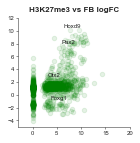

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     191.3
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           7.99e-41
Time:                        16:23:31   Log-Likelihood:                -3399.2
No. Observations:                1371   AIC:                             6802.
Df Residuals:                    1369   BIC:                             6813.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3757      0.092     25.722      0.0

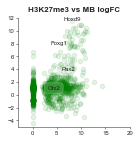

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     55.40
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           1.73e-13
Time:                        16:23:31   Log-Likelihood:                -3461.6
No. Observations:                1371   AIC:                             6927.
Df Residuals:                    1369   BIC:                             6938.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6203      0.101     26.016      0.0

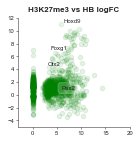

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     103.1
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           2.11e-23
Time:                        16:23:31   Log-Likelihood:                -3439.1
No. Observations:                1371   AIC:                             6882.
Df Residuals:                    1369   BIC:                             6893.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6761      0.089     30.153      0.0

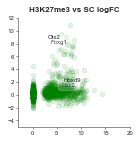

In [29]:
%matplotlib inline
from scipy.stats import spearmanr
from sciviso import Histogram, Scatterplot
from numpy.polynomial.polynomial import polyfit
import statsmodels.api as sm

# Do this on the consistently affected dataset
df_const = pd.read_csv(f'{output_dir}df-consistent_epi-2500_{date}.csv')


#calculate Spearman Rank correlation and corre
# Also do the main markers
fb_genes = ['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6']
mb_genes = ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4']
hb_genes = ['Phox2b', 'Krox20', 'Fev', 'Hoxb1',  'Hoxd3']
sc_genes = ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11','Hoxa7', 'Hoxa9', 'Hoxa10',
              'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13']

# Fill NAs in genes that didn't have the H3K27me3 mark
df_const_na = df_const.fillna(0)
h3k_cols = [c for c in df_const_na.columns if 'brain' in c and 'H3K27me3' in c and 'signal' in c]
Y = np.nan_to_num(np.nanmedian(df_const_na[h3k_cols].values, axis=1))
df_const_na['Median_H3K'] = Y
X = df_const_na['log2FoldChange_fb'].values
results = sm.OLS(Y,sm.add_constant(X)).fit()
print(results.summary())
corr, _ = spearmanr(X, Y)
u.dp(["H3K27me3 median signal in brain regions vs FB logFC:\n", 'Spearmans correlation: %.3f' % corr, 'pvalue', _])

# now run the scatter
s = Scatterplot(df_const_na,'Median_H3K', 'log2FoldChange_fb', title='H3K27me3 vs FB logFC', colour="green", 
                points_to_annotate=['Foxg1', 'Otx2', 'Pax2', 'Hoxd9'], 
                annotation_label=gene_name, add_legend=False)
s.opacity=0.1
ax = s.plot()
ax.set_xlim(-3, 20)
ax.set_ylim(-5, 12)

save_fig(f'Scatter_H3K27me3vsLogFC')
plt.show()
# MB
X = df_const_na['log2FoldChange_mb'].values
results = sm.OLS(Y,sm.add_constant(X)).fit()
print(results.summary())
corr, _ = spearmanr(X, Y)
u.dp(["H3K27me3 median signal in brain regions vs MB logFC:\n", 'Spearmans correlation: %.3f' % corr, 'pvalue', _])

# now run the scatter
s = Scatterplot(df_const_na,'Median_H3K', 'log2FoldChange_mb', title='H3K27me3 vs MB logFC', colour="green", 
                points_to_annotate=['Foxg1', 'Otx2', 'Pax2', 'Hoxd9'], 
                annotation_label=gene_name, add_legend=False)
s.opacity=0.1
ax = s.plot()
ax.set_xlim(-3, 20)
ax.set_ylim(-5, 12)

save_fig(f'Scatter_H3K27me3vsLogFC_MB')
plt.show()

# HB
X = df_const_na['log2FoldChange_hb'].values
results = sm.OLS(Y,sm.add_constant(X)).fit()
print(results.summary())
corr, _ = spearmanr(X, Y)
u.dp(["H3K27me3 median signal in brain regions vs HB logFC:\n", 'Spearmans correlation: %.3f' % corr, 'pvalue', _])

# now run the scatter
s = Scatterplot(df_const_na,'Median_H3K', 'log2FoldChange_hb', title='H3K27me3 vs HB logFC', colour="green", 
                points_to_annotate=['Foxg1', 'Otx2', 'Pax2', 'Hoxd9'], 
                annotation_label=gene_name, add_legend=False)
s.opacity=0.1
ax = s.plot()
ax.set_xlim(-3, 20)
ax.set_ylim(-5, 12)

save_fig(f'Scatter_H3K27me3vsLogFC_HB')
plt.show()

# SC
X = df_const_na['log2FoldChange_sc'].values
results = sm.OLS(Y,sm.add_constant(X)).fit()
print(results.summary())
corr, _ = spearmanr(X, Y)
u.dp(["H3K27me3 median signal in brain regions vs SC logFC:\n", 'Spearmans correlation: %.3f' % corr, 'pvalue', _])

# now run the scatter
s = Scatterplot(df_const_na,'Median_H3K', 'log2FoldChange_sc', title='H3K27me3 vs SC logFC', colour="green", 
                points_to_annotate=['Foxg1', 'Otx2', 'Pax2', 'Hoxd9'], 
                annotation_label=gene_name, add_legend=False)
s.opacity=0.1
ax = s.plot()
ax.set_xlim(-3, 20)
ax.set_ylim(-5, 12)

save_fig(f'Scatter_H3K27me3vsLogFC_SC')
plt.show()


    
    

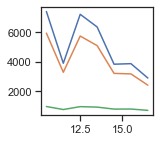

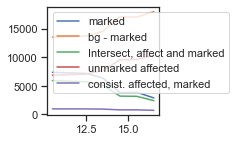

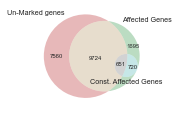

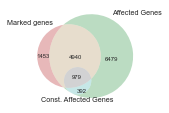

In [22]:
h3k_cols = [c for c in df_bg.columns if 'brain' in c and '10.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e10 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

h3k_cols = [c for c in df_bg.columns if 'brain' in c and '11.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e11 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

h3k_cols = [c for c in df_bg.columns if 'brain' in c and '12.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e12 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

h3k_cols = [c for c in df_bg.columns if 'brain' in c and '13.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e13 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

h3k_cols = [c for c in df_bg.columns if 'brain' in c and '14.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e14 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

h3k_cols = [c for c in df_bg.columns if 'brain' in c and '15.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e15 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

h3k_cols = [c for c in df_bg.columns if 'brain' in c and '16.5' in c and 'signal' in c and 'H3K27me3' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
e16 = df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values

### ----------- 
plt.plot([10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(e10), len(e11), len(e12), len(e13), len(e14), len(e15), len(e16)]
        )
afct = set(df_sig[gene_name].values)
cafct = set(df_sig[df_sig['logfc_mask'] > pert_cutoff][gene_name].values)

plt.plot([10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(set(afct) & set(e10)), len(set(afct) & set(e11)), 
          len(set(afct) & set(e12)), len(set(afct) & set(e13)), len(set(afct) & set(e14)), 
          len(set(afct) & set(e15)), len(set(afct) & set(e16))]
        )

plt.plot([10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(set(cafct) & set(e10)), len(set(cafct) & set(e11)), 
          len(set(cafct) & set(e12)), len(set(cafct) & set(e13)), len(set(cafct) & set(e14)), 
          len(set(cafct) & set(e15)), len(set(cafct) & set(e16))]
        )

plt.show()

# ==============================
plt.plot([10.5,  12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(e10), len(e12), len(e13), len(e14), len(e15), len(e16)], label="marked"
        )
plt.plot([10.5,  12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(df_bg) - len(e10), len(df_bg) - len(e12), len(df_bg) - len(e13), len(df_bg) - len(e14), len(df_bg) - len(e15), len(df_bg) - len(e16)]
        , label="bg - marked")
afct = set(df_sig[gene_name].values)
cafct = set(df_sig[df_sig['logfc_mask'] > pert_cutoff][gene_name].values)
afct = set(df_sig[gene_name].values)

plt.plot([10.5, 12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(set(afct) & set(e10)), 
          len(set(afct) & set(e12)), len(set(afct) & set(e13)), len(set(afct) & set(e14)), 
          len(set(afct) & set(e15)), len(set(afct) & set(e16))], label="Intersect, affect and marked"
        )
plt.plot([10.5, 12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(set(afct)) - len(set(afct) & set(e10)), 
          len(set(afct)) - len(set(afct) & set(e12)), len(set(afct)) - len(set(afct) & set(e13)),
          len(set(afct)) - len(set(afct) & set(e14)), 
          len(set(afct)) - len(set(afct) & set(e15)), len(set(afct)) - len(set(afct) & set(e16))],
         label="unmarked affected"
        )
plt.plot([10.5, 12.5, 13.5, 14.5, 15.5, 16.5], 
         [len(set(cafct) & set(e10)), 
          len(set(cafct) & set(e12)), len(set(cafct) & set(e13)), len(set(cafct) & set(e14)), 
          len(set(cafct) & set(e15)), len(set(cafct) & set(e16))], 
         label="consist. affected, marked"
        )
plt.legend(loc="upper left")
plt.show()


#------------ 
h3k_cols = [c for c in df_bg.columns if 'brain' in c and 'signal' in c and 'H3K27me3' in c and '16.5' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
plot_venn((set(df_bg[df_bg['hk3_mean'] == 0][gene_name].values), 
           set(df_sig[gene_name].values), set(df_sig[df_sig['logfc_mask'] > pert_cutoff][gene_name].values)),
          ('Un-Marked genes', 'Affected Genes', 'Const. Affected Genes'), 'venn_unmaked_marked_const_aff')

#------------ 
h3k_cols = [c for c in df_bg.columns if 'brain' in c and 'signal' in c and 'H3K27me3' in c and '10.5' in c]
df_bg['hk3_mean'] = np.nanmean(df_bg[h3k_cols].values, axis=1)
plot_venn((set(df_bg[df_bg['hk3_mean'] > h3k_cutoff][gene_name].values), 
           set(df_sig[gene_name].values), set(df_sig[df_sig['logfc_mask'] > pert_cutoff][gene_name].values)),
          ('Marked genes', 'Affected Genes', 'Const. Affected Genes'), 'venn_marked_const_aff')


--------------------------------------------------------------------------------
                                All genes	14968	                                
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                           Genes with H3K27me3	2596	                            
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Genes without H3K27me3	12372	                          
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        Genes with at least 1 sig	12797	                        
--------------------------------------------------------------------------------
----------------------------

## 13) Test for enrichment of specific marks using the Gorkin et al annotations

In [26]:
# Save each DF so we can test each of them for ORA (just save the gene name to avoid dups.)
for label, d in df_dict.items():
    print(label)
    dn = d[[gene_id, gene_name]]
    dn.to_csv(os.path.join(output_dir, f'{label.replace(" ", "_")}_gene-name_{date}.csv'), index=False)
    print(os.path.join(output_dir, f'{label.replace(" ", "_")}_gene-name_{date}.csv'))

All genes
../data/results/prelim/All_genes_gene-name_20210124.csv
Genes with H3K27me3
../data/results/prelim/Genes_with_H3K27me3_gene-name_20210124.csv
Genes without H3K27me3
../data/results/prelim/Genes_without_H3K27me3_gene-name_20210124.csv
Genes with at least 1 sig
../data/results/prelim/Genes_with_at_least_1_sig_gene-name_20210124.csv
Non-sig genes
../data/results/prelim/Non-sig_genes_gene-name_20210124.csv
Sig with H3K27me3
../data/results/prelim/Sig_with_H3K27me3_gene-name_20210124.csv
NS with H3K27me3
../data/results/prelim/NS_with_H3K27me3_gene-name_20210124.csv
Sig unmarked
../data/results/prelim/Sig_unmarked_gene-name_20210124.csv
NS unmarked
../data/results/prelim/NS_unmarked_gene-name_20210124.csv
Sig Marked Perturbed
../data/results/prelim/Sig_Marked_Perturbed_gene-name_20210124.csv
Sig Marked un-Perturbed
../data/results/prelim/Sig_Marked_un-Perturbed_gene-name_20210124.csv
Sig Unmarked Perturbed
../data/results/prelim/Sig_Unmarked_Perturbed_gene-name_20210124.csv
Sig Un

In [24]:
output_dir

'../data/results/prelim/'

Pr-A 1.0 1.0 [[5885, 5885], [9083.0, 9083.0]]
Pr-W 1.0 1.0 [[3464, 3464], [11504.0, 11504.0]]
Pr-B 1.0 1.0 [[806, 806], [14162.0, 14162.0]]
Pr-F 1.0 1.0 [[1042, 1042], [13926.0, 13926.0]]
En-Sd 1.0 1.0 [[59, 59], [14909.0, 14909.0]]
En-Sp 1.0 1.0 [[348, 348], [14620.0, 14620.0]]
En-W 1.0 1.0 [[23, 23], [14945.0, 14945.0]]
En-Pd 1.0 1.0 [[155, 155], [14813.0, 14813.0]]
En-Pp 1.0 1.0 [[352, 352], [14616.0, 14616.0]]
Tr-S 1.0 1.0 [[51, 51], [14917.0, 14917.0]]
Tr-P 1.0 1.0 [[997, 997], [13971.0, 13971.0]]
Tr-I 1.0 1.0 [[114, 114], [14854.0, 14854.0]]
Hc-P 1.0 1.0 [[311, 311], [14657.0, 14657.0]]
Hc-H 1.0 1.0 [[54, 54], [14914.0, 14914.0]]
NS 1.0 1.0 [[747, 747], [14221.0, 14221.0]]


<ipython-input-45-c5d5c405855c>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90, ha="center")


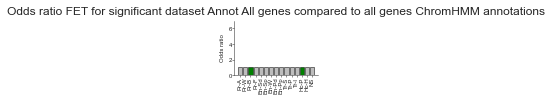

Pr-A 0.24210438635947157 1.5288251008234748e-160 [[352, 5885], [2244.0, 9083.0]]
Pr-W 0.7707531586671943 8.82178889259204e-07 [[489, 3464], [2107.0, 11504.0]]
Pr-B 7.658034871209293 3.869481077353874e-268 [[788, 806], [1808.0, 14162.0]]
Pr-F 2.2988462021724154 8.564505369731715e-35 [[381, 1042], [2215.0, 13926.0]]
En-Sd 0.487639743832955 0.15536536696834718 [[5, 59], [2591.0, 14909.0]]
En-Sp 0.8755836395604792 0.39383457522404997 [[53, 348], [2543.0, 14620.0]]
En-W 0.0 0.03909597693235345 [[0, 23], [2596.0, 14945.0]]
En-Pd 0.48098360246275274 0.008348898548592993 [[13, 155], [2583.0, 14813.0]]
En-Pp 0.5674718682332895 0.0008329972164518171 [[35, 352], [2561.0, 14616.0]]
Tr-S 0.0 0.0005057624163226845 [[0, 51], [2596.0, 14917.0]]
Tr-P 0.3485280159467744 3.1862659558307444e-20 [[63, 997], [2533.0, 13971.0]]
Tr-I 1.3694249247095942 0.1519492557862803 [[27, 114], [2569.0, 14854.0]]
Hc-P 5.949860153029553 1.66421426639638e-88 [[291, 311], [2305.0, 14657.0]]
Hc-H 0.3195355015640399 0.0393816

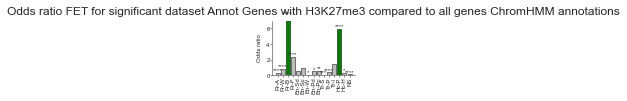

Pr-A 1.2486793035545176 2.1059896133398323e-19 [[5533, 5885], [6839.0, 9083.0]]
Pr-W 1.051401840447826 0.0806854086676437 [[2975, 3464], [9397.0, 11504.0]]
Pr-B 0.025600854205406996 4.861687845129709e-185 [[18, 806], [12354.0, 14162.0]]
Pr-F 0.754338285559568 3.0963394272441627e-08 [[661, 1042], [11711.0, 13926.0]]
En-Sd 1.1077711823127792 0.6361104147042314 [[54, 59], [12318.0, 14909.0]]
En-Sp 1.0261977978469572 0.7485960286860522 [[295, 348], [12077.0, 14620.0]]
En-W 1.2102194509676898 0.5549686692086748 [[23, 23], [12349.0, 14945.0]]
En-Pd 1.1096172816711947 0.37979319883722756 [[142, 155], [12230.0, 14813.0]]
En-Pp 1.0918875608008747 0.27094418554334565 [[317, 352], [12055.0, 14616.0]]
Tr-S 1.2106971836701566 0.37000577474536944 [[51, 51], [12321.0, 14917.0]]
Tr-P 1.1442715977974138 0.004430077722762405 [[934, 997], [11438.0, 13971.0]]
Tr-I 0.9227470385365122 0.6187431886899627 [[87, 114], [12285.0, 14854.0]]
Hc-P 0.07630928977225397 1.2444808863936277e-57 [[20, 311], [12352.0, 146

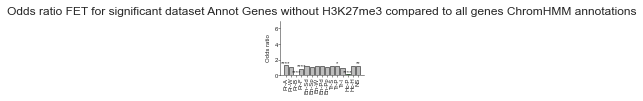

Pr-A 0.9969173576070832 0.9019063953449773 [[5022, 5885], [7775.0, 9083.0]]
Pr-W 0.9944838215236491 0.8526973591024303 [[2949, 3464], [9848.0, 11504.0]]
Pr-B 1.1093916173683664 0.04734402215783287 [[760, 806], [12037.0, 14162.0]]
Pr-F 1.0692648974321635 0.15456572825426157 [[948, 1042], [11849.0, 13926.0]]
En-Sd 1.0509126262142636 0.8494742316131091 [[53, 59], [12744.0, 14909.0]]
En-Sp 1.0395220791269963 0.6347160636240619 [[309, 348], [12488.0, 14620.0]]
En-W 0.9152583892731622 0.8757941656140028 [[18, 23], [12779.0, 14945.0]]
En-Pd 1.0189263276962819 0.9057666847002287 [[135, 155], [12662.0, 14813.0]]
En-Pp 0.9899810166631512 0.9050005166446206 [[298, 352], [12499.0, 14616.0]]
Tr-S 0.7791793987829403 0.27714150921013736 [[34, 51], [12763.0, 14917.0]]
Tr-P 0.9021119751169002 0.03850739040487501 [[774, 997], [12023.0, 13971.0]]
Tr-I 0.9848540728247672 0.9446602076932347 [[96, 114], [12701.0, 14854.0]]
Hc-P 1.0619472709918516 0.4791900765574865 [[282, 311], [12515.0, 14657.0]]
Hc-H 0.88

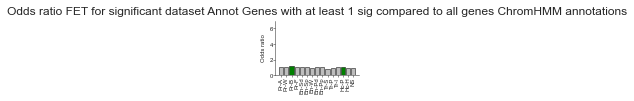

Pr-A 1.0183238108600365 0.7069008481448309 [[863, 5885], [1308.0, 9083.0]]
Pr-W 1.0328039406009082 0.5496795248633665 [[515, 3464], [1656.0, 11504.0]]
Pr-B 0.3803544008173989 8.632534223299366e-13 [[46, 806], [2125.0, 14162.0]]
Pr-F 0.604853264480643 1.4829776816794924e-06 [[94, 1042], [2077.0, 13926.0]]
En-Sd 0.7003092339609347 0.5732601558566706 [[6, 59], [2165.0, 14909.0]]
En-Sp 0.7685029436501262 0.14131486499781698 [[39, 348], [2132.0, 14620.0]]
En-W 1.4999598538680798 0.3908471961098976 [[5, 23], [2166.0, 14945.0]]
En-Pd 0.8885889533750244 0.7315854759344855 [[20, 155], [2151.0, 14813.0]]
En-Pp 1.0591531755915318 0.705578680138238 [[54, 352], [2117.0, 14616.0]]
Tr-S 2.3084184463014545 0.005125337648515433 [[17, 51], [2154.0, 14917.0]]
Tr-P 1.6041620755490291 5.564152351846437e-09 [[223, 997], [1948.0, 13971.0]]
Tr-I 1.0893490111716821 0.6941403652520004 [[18, 114], [2153.0, 14854.0]]
Hc-P 0.6380625133225852 0.020732031269808812 [[29, 311], [2142.0, 14657.0]]
Hc-H 1.66376617581436

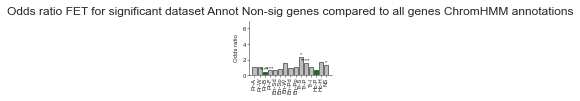

Pr-A 0.23818595057928663 2.236952445294526e-153 [[323, 5885], [2093.0, 9083.0]]
Pr-W 0.770557040111269 2.0066880841137127e-06 [[455, 3464], [1961.0, 11504.0]]
Pr-B 7.788216215895717 2.0042205275118214e-259 [[742, 806], [1674.0, 14162.0]]
Pr-F 2.363068698678868 2.673743261926909e-35 [[363, 1042], [2053.0, 13926.0]]
En-Sd 0.41906287770188605 0.09873307057889252 [[4, 59], [2412.0, 14909.0]]
En-Sp 0.9241107026858821 0.6608429851608619 [[52, 348], [2364.0, 14620.0]]
En-W 0.0 0.06396153528908419 [[0, 23], [2416.0, 14945.0]]
En-Pd 0.39720590995629207 0.002089334647878005 [[10, 155], [2406.0, 14813.0]]
En-Pp 0.5750104909777591 0.0016823232139883632 [[33, 352], [2383.0, 14616.0]]
Tr-S 0.0 0.0008198459150934424 [[0, 51], [2416.0, 14917.0]]
Tr-P 0.3143000733049763 1.8402472560241576e-21 [[53, 997], [2363.0, 13971.0]]
Tr-I 1.3073402569970076 0.26468037308163117 [[24, 114], [2392.0, 14854.0]]
Hc-P 5.830796380767217 3.605088624399581e-81 [[266, 311], [2150.0, 14657.0]]
Hc-H 0.3433715522401805 0.0561

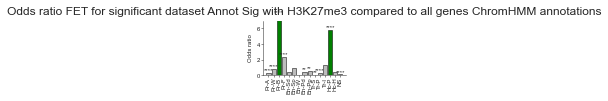

Pr-A 0.29641753925965103 2.551605400964937e-11 [[29, 5885], [151.0, 9083.0]]
Pr-W 0.7733873263943813 0.21244279261099747 [[34, 3464], [146.0, 11504.0]]
Pr-B 6.031739565201288 1.3467043737187781e-18 [[46, 806], [134.0, 14162.0]]
Pr-F 1.4849648112603966 0.13860694123361939 [[18, 1042], [162.0, 13926.0]]
En-Sd 1.41170343717451 0.512587328383429 [[1, 59], [179.0, 14909.0]]
En-Sp 0.23470108521158414 0.13485578173566978 [[1, 348], [179.0, 14620.0]]
En-W 0.0 1.0 [[0, 23], [180.0, 14945.0]]
En-Pd 1.619792236194642 0.43957989016331256 [[3, 155], [177.0, 14813.0]]
En-Pp 0.46654749744637386 0.4497847359448516 [[2, 352], [178.0, 14616.0]]
Tr-S 0.0 1.0 [[0, 51], [180.0, 14917.0]]
Tr-P 0.824296418667768 0.6527148928406563 [[10, 997], [170.0, 13971.0]]
Tr-I 2.208444840915849 0.16269180905899303 [[3, 114], [177.0, 14854.0]]
Hc-P 7.601389897313557 2.2132966867186292e-13 [[25, 311], [155.0, 14657.0]]
Hc-H 0.0 1.0 [[0, 54], [180.0, 14914.0]]
NS 0.2139043063640329 0.013627939739904006 [[2, 747], [178.0, 1

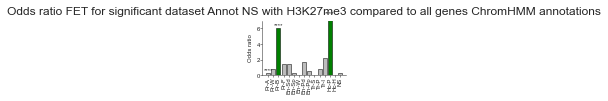

Pr-A 1.2764007850814194 4.0755655433711264e-21 [[4699, 5885], [5682.0, 9083.0]]
Pr-W 1.0501603041342333 0.10384414174317344 [[2494, 3464], [7887.0, 11504.0]]
Pr-B 0.030519439626903216 3.948499231679287e-159 [[18, 806], [10363.0, 14162.0]]
Pr-F 0.7981155299393619 2.1350211873678833e-05 [[585, 1042], [9796.0, 13926.0]]
En-Sd 1.198417619769418 0.377805338698898 [[49, 59], [10332.0, 14909.0]]
En-Sp 1.0664711599158936 0.45144754610565646 [[257, 348], [10124.0, 14620.0]]
En-W 1.1286390964510025 0.7514789076036937 [[18, 23], [10363.0, 14945.0]]
En-Pd 1.1647784459765487 0.2216479384996152 [[125, 155], [10256.0, 14813.0]]
En-Pp 1.0877345519249433 0.3199448127236231 [[265, 352], [10116.0, 14616.0]]
Tr-S 0.9611159434296576 0.9122768135132235 [[34, 51], [10347.0, 14917.0]]
Tr-P 1.045900745715407 0.3876751339707447 [[721, 997], [9660.0, 13971.0]]
Tr-I 0.91002751811141 0.5502457629914534 [[72, 114], [10309.0, 14854.0]]
Hc-P 0.07275039824539362 1.2754377804783065e-51 [[16, 311], [10365.0, 14657.0]]
H

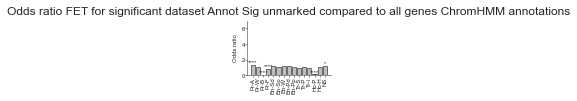

Pr-A 1.1125397546903375 0.02818185763382116 [[834, 5885], [1157.0, 9083.0]]
Pr-W 1.057886606610281 0.32308910897636933 [[481, 3464], [1510.0, 11504.0]]
Pr-B 0.0 2.476691958845903e-45 [[0, 806], [1991.0, 14162.0]]
Pr-F 0.5303999639175516 2.097775509860076e-08 [[76, 1042], [1915.0, 13926.0]]
En-Sd 0.6361906224930445 0.4361429485871955 [[5, 59], [1986.0, 14909.0]]
En-Sp 0.8174279475725527 0.2631359298283783 [[38, 348], [1953.0, 14620.0]]
En-W 1.6359078768772712 0.36925019693946404 [[5, 23], [1986.0, 14945.0]]
En-Pd 0.8230251331829918 0.5509370900222303 [[17, 155], [1974.0, 14813.0]]
En-Pp 1.1135543157203807 0.4810843988915803 [[52, 352], [1939.0, 14616.0]]
Tr-S 2.5189125295508275 0.002009889597174559 [[17, 51], [1974.0, 14917.0]]
Tr-P 1.678727408321703 5.721312892154466e-10 [[213, 997], [1778.0, 13971.0]]
Tr-I 0.989106115491157 1.0 [[15, 114], [1976.0, 14854.0]]
Hc-P 0.09487391517532773 1.3715972330113823e-12 [[4, 311], [1987.0, 14657.0]]
Hc-H 1.8151705800846347 0.057215537490759756 [[13,

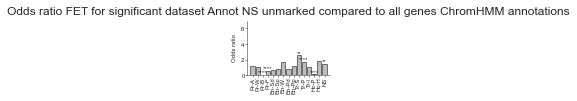

Pr-A 0.0509304959109864 6.0770285843974434e-114 [[23, 5885], [697.0, 9083.0]]
Pr-W 0.2746705099932279 3.524615789357567e-27 [[55, 3464], [665.0, 11504.0]]
Pr-B 15.46039818852082 5.623857672765395e-201 [[337, 806], [383.0, 14162.0]]
Pr-F 1.9335233393040776 1.2484936862153932e-07 [[91, 1042], [629.0, 13926.0]]
En-Sd 0.35145328964427996 0.5276247876279874 [[1, 59], [719.0, 14909.0]]
En-Sp 0.6518003339655983 0.20032185973273325 [[11, 348], [709.0, 14620.0]]
En-W 0.0 0.6242399728422908 [[0, 23], [720.0, 14945.0]]
En-Pd 0.5338979996395747 0.25484121725338116 [[4, 155], [716.0, 14813.0]]
En-Pp 0.5848271446862996 0.09837506379891905 [[10, 352], [710.0, 14616.0]]
Tr-S 0.0 0.17423368865478425 [[0, 51], [720.0, 14917.0]]
Tr-P 0.23750913758223824 7.681181819389645e-10 [[12, 997], [708.0, 13971.0]]
Tr-I 1.2792254127605127 0.508398041890984 [[7, 114], [713.0, 14854.0]]
Hc-P 11.17482679749395 1.7147442153265933e-77 [[138, 311], [582.0, 14657.0]]
Hc-H 0.0 0.17958360073965343 [[0, 54], [720.0, 14914.0]

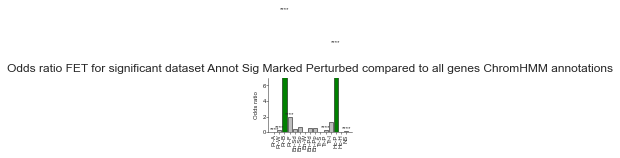

Pr-A 0.33167954076825884 3.0183776897993817e-75 [[300, 5885], [1396.0, 9083.0]]
Pr-W 1.0250049895931344 0.6931305769882641 [[400, 3464], [1296.0, 11504.0]]
Pr-B 5.512115754613443 1.994864626945351e-119 [[405, 806], [1291.0, 14162.0]]
Pr-F 2.5528046755375358 1.8746207153446434e-32 [[272, 1042], [1424.0, 13926.0]]
En-Sd 0.4477759868651576 0.20696709017086629 [[3, 59], [1693.0, 14909.0]]
En-Sp 1.0407681355696774 0.798994250648637 [[41, 348], [1655.0, 14620.0]]
En-W 0.0 0.1620866229946606 [[0, 23], [1696.0, 14945.0]]
En-Pd 0.3392937583508303 0.0036959390074737582 [[6, 155], [1690.0, 14813.0]]
En-Pp 0.5708444275389882 0.007211874141119964 [[23, 352], [1673.0, 14616.0]]
Tr-S 0.0 0.0085183957127423 [[0, 51], [1696.0, 14917.0]]
Tr-P 0.3471508180129512 2.8063545112976028e-14 [[41, 997], [1655.0, 13971.0]]
Tr-I 1.319279437426204 0.3075459395350693 [[17, 114], [1679.0, 14854.0]]
Hc-P 3.8472340704770653 1.9346216971430265e-29 [[128, 311], [1568.0, 14657.0]]
Hc-H 0.48940080068254904 0.2758557015255

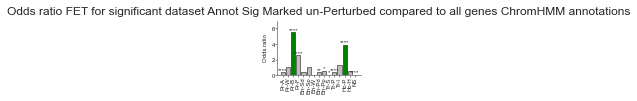

Pr-A 0.1624647855833296 1.6278070219087217e-63 [[62, 5885], [589.0, 9083.0]]
Pr-W 0.5465715336277666 2.023405810891417e-08 [[92, 3464], [559.0, 11504.0]]
Pr-B 0.1909860826410616 1.3767449328306686e-08 [[7, 806], [644.0, 14162.0]]
Pr-F 1.6879271297544647 0.0001249201569689377 [[73, 1042], [578.0, 13926.0]]
En-Sd 2.3506503744580214 0.053152944183913135 [[6, 59], [645.0, 14909.0]]
En-Sp 0.9908371286055085 1.0 [[15, 348], [636.0, 14620.0]]
En-W 4.017203144949936 0.024484895054830192 [[4, 23], [647.0, 14945.0]]
En-Pd 3.6580953850902915 4.2436721248647006e-07 [[24, 155], [627.0, 14813.0]]
En-Pp 1.7273454545454545 0.012501714757568927 [[26, 352], [625.0, 14616.0]]
Tr-S 1.8082856017213687 0.2914953837078631 [[4, 51], [647.0, 14917.0]]
Tr-P 3.2317405903912113 1.4726935990652035e-23 [[122, 997], [529.0, 13971.0]]
Tr-I 1.6211290278573571 0.171644244755815 [[8, 114], [643.0, 14854.0]]
Hc-P 0.2913670316126371 0.006096564170592466 [[4, 311], [647.0, 14657.0]]
Hc-H 0.8511099697540375 1.0 [[2, 54], [6

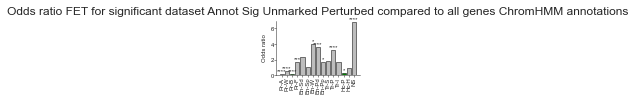

Pr-A 1.4052262914046818 3.193497314751803e-38 [[4637, 5885], [5093.0, 9083.0]]
Pr-W 1.0885754409673547 0.005613221839185514 [[2402, 3464], [7328.0, 11504.0]]
Pr-B 0.019886605168510582 1.8738270089337863e-159 [[11, 806], [9719.0, 14162.0]]
Pr-F 0.7423213115955639 5.874878403594816e-08 [[512, 1042], [9218.0, 13926.0]]
En-Sd 1.1216972598257668 0.6119182997533829 [[43, 59], [9687.0, 14909.0]]
En-Sp 1.071541063363765 0.41807205283336224 [[242, 348], [9488.0, 14620.0]]
En-W 0.9362861796767322 1.0 [[14, 23], [9716.0, 14945.0]]
En-Pd 1.0024241287240494 1.0 [[101, 155], [9629.0, 14813.0]]
En-Pp 1.0456149845307996 0.6092700953581481 [[239, 352], [9491.0, 14616.0]]
Tr-S 0.9046088538508187 0.7330413293657585 [[30, 51], [9700.0, 14917.0]]
Tr-P 0.9192651879634084 0.11816325487723417 [[599, 997], [9131.0, 13971.0]]
Tr-I 0.8627237450132677 0.3567788730979695 [[64, 114], [9666.0, 14854.0]]
Hc-P 0.0581954525993135 2.8647253430364884e-52 [[12, 311], [9718.0, 14657.0]]
Hc-H 1.0256516058042775 0.9142567154

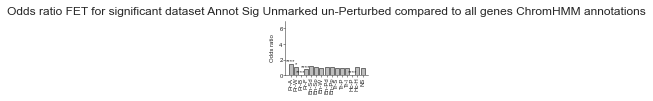

Pr-A 0.0509304959109864 6.0770285843974434e-114 [[23, 5885], [697.0, 9083.0]]
Pr-W 0.2746705099932279 3.524615789357567e-27 [[55, 3464], [665.0, 11504.0]]
Pr-B 15.46039818852082 5.623857672765395e-201 [[337, 806], [383.0, 14162.0]]
Pr-F 1.9335233393040776 1.2484936862153932e-07 [[91, 1042], [629.0, 13926.0]]
En-Sd 0.35145328964427996 0.5276247876279874 [[1, 59], [719.0, 14909.0]]
En-Sp 0.6518003339655983 0.20032185973273325 [[11, 348], [709.0, 14620.0]]
En-W 0.0 0.6242399728422908 [[0, 23], [720.0, 14945.0]]
En-Pd 0.5338979996395747 0.25484121725338116 [[4, 155], [716.0, 14813.0]]
En-Pp 0.5848271446862996 0.09837506379891905 [[10, 352], [710.0, 14616.0]]
Tr-S 0.0 0.17423368865478425 [[0, 51], [720.0, 14917.0]]
Tr-P 0.23750913758223824 7.681181819389645e-10 [[12, 997], [708.0, 13971.0]]
Tr-I 1.2792254127605127 0.508398041890984 [[7, 114], [713.0, 14854.0]]
Hc-P 11.17482679749395 1.7147442153265933e-77 [[138, 311], [582.0, 14657.0]]
Hc-H 0.0 0.17958360073965343 [[0, 54], [720.0, 14914.0]

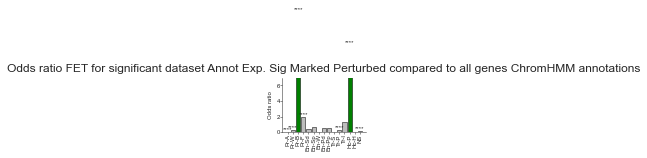

Pr-A 0.33167954076825884 3.0183776897993817e-75 [[300, 5885], [1396.0, 9083.0]]
Pr-W 1.0250049895931344 0.6931305769882641 [[400, 3464], [1296.0, 11504.0]]
Pr-B 5.512115754613443 1.994864626945351e-119 [[405, 806], [1291.0, 14162.0]]
Pr-F 2.5528046755375358 1.8746207153446434e-32 [[272, 1042], [1424.0, 13926.0]]
En-Sd 0.4477759868651576 0.20696709017086629 [[3, 59], [1693.0, 14909.0]]
En-Sp 1.0407681355696774 0.798994250648637 [[41, 348], [1655.0, 14620.0]]
En-W 0.0 0.1620866229946606 [[0, 23], [1696.0, 14945.0]]
En-Pd 0.3392937583508303 0.0036959390074737582 [[6, 155], [1690.0, 14813.0]]
En-Pp 0.5708444275389882 0.007211874141119964 [[23, 352], [1673.0, 14616.0]]
Tr-S 0.0 0.0085183957127423 [[0, 51], [1696.0, 14917.0]]
Tr-P 0.3471508180129512 2.8063545112976028e-14 [[41, 997], [1655.0, 13971.0]]
Tr-I 1.319279437426204 0.3075459395350693 [[17, 114], [1679.0, 14854.0]]
Hc-P 3.8472340704770653 1.9346216971430265e-29 [[128, 311], [1568.0, 14657.0]]
Hc-H 0.48940080068254904 0.2758557015255

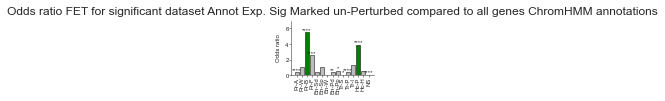

Pr-A 0.1624647855833296 1.6278070219087217e-63 [[62, 5885], [589.0, 9083.0]]
Pr-W 0.5465715336277666 2.023405810891417e-08 [[92, 3464], [559.0, 11504.0]]
Pr-B 0.1909860826410616 1.3767449328306686e-08 [[7, 806], [644.0, 14162.0]]
Pr-F 1.6879271297544647 0.0001249201569689377 [[73, 1042], [578.0, 13926.0]]
En-Sd 2.3506503744580214 0.053152944183913135 [[6, 59], [645.0, 14909.0]]
En-Sp 0.9908371286055085 1.0 [[15, 348], [636.0, 14620.0]]
En-W 4.017203144949936 0.024484895054830192 [[4, 23], [647.0, 14945.0]]
En-Pd 3.6580953850902915 4.2436721248647006e-07 [[24, 155], [627.0, 14813.0]]
En-Pp 1.7273454545454545 0.012501714757568927 [[26, 352], [625.0, 14616.0]]
Tr-S 1.8082856017213687 0.2914953837078631 [[4, 51], [647.0, 14917.0]]
Tr-P 3.2317405903912113 1.4726935990652035e-23 [[122, 997], [529.0, 13971.0]]
Tr-I 1.6211290278573571 0.171644244755815 [[8, 114], [643.0, 14854.0]]
Hc-P 0.2913670316126371 0.006096564170592466 [[4, 311], [647.0, 14657.0]]
Hc-H 0.8511099697540375 1.0 [[2, 54], [6

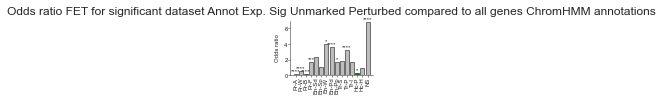

Pr-A 1.4052262914046818 3.193497314751803e-38 [[4637, 5885], [5093.0, 9083.0]]
Pr-W 1.0885754409673547 0.005613221839185514 [[2402, 3464], [7328.0, 11504.0]]
Pr-B 0.019886605168510582 1.8738270089337863e-159 [[11, 806], [9719.0, 14162.0]]
Pr-F 0.7423213115955639 5.874878403594816e-08 [[512, 1042], [9218.0, 13926.0]]
En-Sd 1.1216972598257668 0.6119182997533829 [[43, 59], [9687.0, 14909.0]]
En-Sp 1.071541063363765 0.41807205283336224 [[242, 348], [9488.0, 14620.0]]
En-W 0.9362861796767322 1.0 [[14, 23], [9716.0, 14945.0]]
En-Pd 1.0024241287240494 1.0 [[101, 155], [9629.0, 14813.0]]
En-Pp 1.0456149845307996 0.6092700953581481 [[239, 352], [9491.0, 14616.0]]
Tr-S 0.9046088538508187 0.7330413293657585 [[30, 51], [9700.0, 14917.0]]
Tr-P 0.9192651879634084 0.11816325487723417 [[599, 997], [9131.0, 13971.0]]
Tr-I 0.8627237450132677 0.3567788730979695 [[64, 114], [9666.0, 14854.0]]
Hc-P 0.0581954525993135 2.8647253430364884e-52 [[12, 311], [9718.0, 14657.0]]
Hc-H 1.0256516058042775 0.9142567154

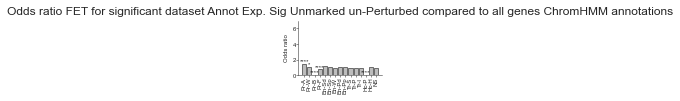

Pr-A 0.23818595057928663 2.236952445294526e-153 [[323, 5885], [2093.0, 9083.0]]
Pr-W 0.770557040111269 2.0066880841137127e-06 [[455, 3464], [1961.0, 11504.0]]
Pr-B 7.788216215895717 2.0042205275118214e-259 [[742, 806], [1674.0, 14162.0]]
Pr-F 2.363068698678868 2.673743261926909e-35 [[363, 1042], [2053.0, 13926.0]]
En-Sd 0.41906287770188605 0.09873307057889252 [[4, 59], [2412.0, 14909.0]]
En-Sp 0.9241107026858821 0.6608429851608619 [[52, 348], [2364.0, 14620.0]]
En-W 0.0 0.06396153528908419 [[0, 23], [2416.0, 14945.0]]
En-Pd 0.39720590995629207 0.002089334647878005 [[10, 155], [2406.0, 14813.0]]
En-Pp 0.5750104909777591 0.0016823232139883632 [[33, 352], [2383.0, 14616.0]]
Tr-S 0.0 0.0008198459150934424 [[0, 51], [2416.0, 14917.0]]
Tr-P 0.3143000733049763 1.8402472560241576e-21 [[53, 997], [2363.0, 13971.0]]
Tr-I 1.3073402569970076 0.26468037308163117 [[24, 114], [2392.0, 14854.0]]
Hc-P 5.830796380767217 3.605088624399581e-81 [[266, 311], [2150.0, 14657.0]]
Hc-H 0.3433715522401805 0.0561

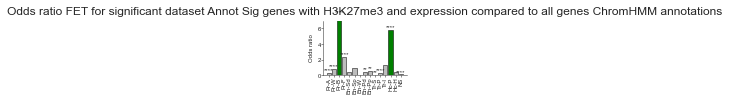

Pr-A nan 1.0 [[0, 5885], [0.0, 9083.0]]
Pr-W nan 1.0 [[0, 3464], [0.0, 11504.0]]
Pr-B nan 1.0 [[0, 806], [0.0, 14162.0]]
Pr-F nan 1.0 [[0, 1042], [0.0, 13926.0]]
En-Sd nan 1.0 [[0, 59], [0.0, 14909.0]]
En-Sp nan 1.0 [[0, 348], [0.0, 14620.0]]
En-W nan 1.0 [[0, 23], [0.0, 14945.0]]
En-Pd nan 1.0 [[0, 155], [0.0, 14813.0]]
En-Pp nan 1.0 [[0, 352], [0.0, 14616.0]]
Tr-S nan 1.0 [[0, 51], [0.0, 14917.0]]
Tr-P nan 1.0 [[0, 997], [0.0, 13971.0]]
Tr-I nan 1.0 [[0, 114], [0.0, 14854.0]]
Hc-P nan 1.0 [[0, 311], [0.0, 14657.0]]
Hc-H nan 1.0 [[0, 54], [0.0, 14914.0]]
NS nan 1.0 [[0, 747], [0.0, 14221.0]]


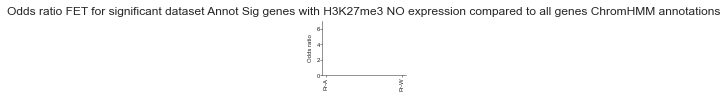

Pr-A 1.2764007850814194 4.0755655433711264e-21 [[4699, 5885], [5682.0, 9083.0]]
Pr-W 1.0501603041342333 0.10384414174317344 [[2494, 3464], [7887.0, 11504.0]]
Pr-B 0.030519439626903216 3.948499231679287e-159 [[18, 806], [10363.0, 14162.0]]
Pr-F 0.7981155299393619 2.1350211873678833e-05 [[585, 1042], [9796.0, 13926.0]]
En-Sd 1.198417619769418 0.377805338698898 [[49, 59], [10332.0, 14909.0]]
En-Sp 1.0664711599158936 0.45144754610565646 [[257, 348], [10124.0, 14620.0]]
En-W 1.1286390964510025 0.7514789076036937 [[18, 23], [10363.0, 14945.0]]
En-Pd 1.1647784459765487 0.2216479384996152 [[125, 155], [10256.0, 14813.0]]
En-Pp 1.0877345519249433 0.3199448127236231 [[265, 352], [10116.0, 14616.0]]
Tr-S 0.9611159434296576 0.9122768135132235 [[34, 51], [10347.0, 14917.0]]
Tr-P 1.045900745715407 0.3876751339707447 [[721, 997], [9660.0, 13971.0]]
Tr-I 0.91002751811141 0.5502457629914534 [[72, 114], [10309.0, 14854.0]]
Hc-P 0.07275039824539362 1.2754377804783065e-51 [[16, 311], [10365.0, 14657.0]]
H

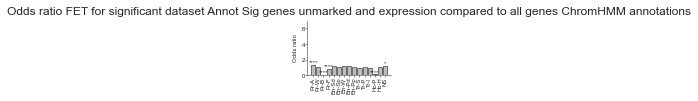

Pr-A nan 1.0 [[0, 5885], [0.0, 9083.0]]
Pr-W nan 1.0 [[0, 3464], [0.0, 11504.0]]
Pr-B nan 1.0 [[0, 806], [0.0, 14162.0]]
Pr-F nan 1.0 [[0, 1042], [0.0, 13926.0]]
En-Sd nan 1.0 [[0, 59], [0.0, 14909.0]]
En-Sp nan 1.0 [[0, 348], [0.0, 14620.0]]
En-W nan 1.0 [[0, 23], [0.0, 14945.0]]
En-Pd nan 1.0 [[0, 155], [0.0, 14813.0]]
En-Pp nan 1.0 [[0, 352], [0.0, 14616.0]]
Tr-S nan 1.0 [[0, 51], [0.0, 14917.0]]
Tr-P nan 1.0 [[0, 997], [0.0, 13971.0]]
Tr-I nan 1.0 [[0, 114], [0.0, 14854.0]]
Hc-P nan 1.0 [[0, 311], [0.0, 14657.0]]
Hc-H nan 1.0 [[0, 54], [0.0, 14914.0]]
NS nan 1.0 [[0, 747], [0.0, 14221.0]]


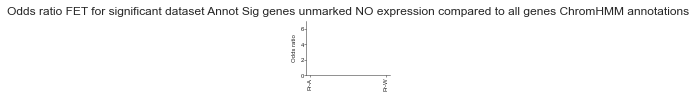

Pr-A 0.29641753925965103 2.551605400964937e-11 [[29, 5885], [151.0, 9083.0]]
Pr-W 0.7733873263943813 0.21244279261099747 [[34, 3464], [146.0, 11504.0]]
Pr-B 6.031739565201288 1.3467043737187781e-18 [[46, 806], [134.0, 14162.0]]
Pr-F 1.4849648112603966 0.13860694123361939 [[18, 1042], [162.0, 13926.0]]
En-Sd 1.41170343717451 0.512587328383429 [[1, 59], [179.0, 14909.0]]
En-Sp 0.23470108521158414 0.13485578173566978 [[1, 348], [179.0, 14620.0]]
En-W 0.0 1.0 [[0, 23], [180.0, 14945.0]]
En-Pd 1.619792236194642 0.43957989016331256 [[3, 155], [177.0, 14813.0]]
En-Pp 0.46654749744637386 0.4497847359448516 [[2, 352], [178.0, 14616.0]]
Tr-S 0.0 1.0 [[0, 51], [180.0, 14917.0]]
Tr-P 0.824296418667768 0.6527148928406563 [[10, 997], [170.0, 13971.0]]
Tr-I 2.208444840915849 0.16269180905899303 [[3, 114], [177.0, 14854.0]]
Hc-P 7.601389897313557 2.2132966867186292e-13 [[25, 311], [155.0, 14657.0]]
Hc-H 0.0 1.0 [[0, 54], [180.0, 14914.0]]
NS 0.2139043063640329 0.013627939739904006 [[2, 747], [178.0, 1

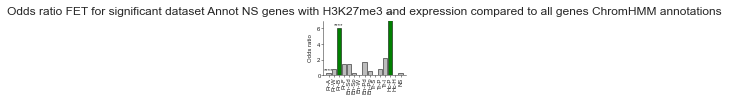

Pr-A nan 1.0 [[0, 5885], [0.0, 9083.0]]
Pr-W nan 1.0 [[0, 3464], [0.0, 11504.0]]
Pr-B nan 1.0 [[0, 806], [0.0, 14162.0]]
Pr-F nan 1.0 [[0, 1042], [0.0, 13926.0]]
En-Sd nan 1.0 [[0, 59], [0.0, 14909.0]]
En-Sp nan 1.0 [[0, 348], [0.0, 14620.0]]
En-W nan 1.0 [[0, 23], [0.0, 14945.0]]
En-Pd nan 1.0 [[0, 155], [0.0, 14813.0]]
En-Pp nan 1.0 [[0, 352], [0.0, 14616.0]]
Tr-S nan 1.0 [[0, 51], [0.0, 14917.0]]
Tr-P nan 1.0 [[0, 997], [0.0, 13971.0]]
Tr-I nan 1.0 [[0, 114], [0.0, 14854.0]]
Hc-P nan 1.0 [[0, 311], [0.0, 14657.0]]
Hc-H nan 1.0 [[0, 54], [0.0, 14914.0]]
NS nan 1.0 [[0, 747], [0.0, 14221.0]]


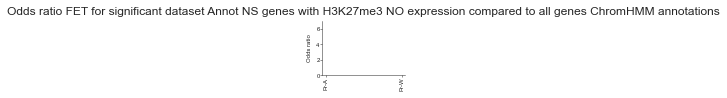

Pr-A 1.1125397546903375 0.02818185763382116 [[834, 5885], [1157.0, 9083.0]]
Pr-W 1.057886606610281 0.32308910897636933 [[481, 3464], [1510.0, 11504.0]]
Pr-B 0.0 2.476691958845903e-45 [[0, 806], [1991.0, 14162.0]]
Pr-F 0.5303999639175516 2.097775509860076e-08 [[76, 1042], [1915.0, 13926.0]]
En-Sd 0.6361906224930445 0.4361429485871955 [[5, 59], [1986.0, 14909.0]]
En-Sp 0.8174279475725527 0.2631359298283783 [[38, 348], [1953.0, 14620.0]]
En-W 1.6359078768772712 0.36925019693946404 [[5, 23], [1986.0, 14945.0]]
En-Pd 0.8230251331829918 0.5509370900222303 [[17, 155], [1974.0, 14813.0]]
En-Pp 1.1135543157203807 0.4810843988915803 [[52, 352], [1939.0, 14616.0]]
Tr-S 2.5189125295508275 0.002009889597174559 [[17, 51], [1974.0, 14917.0]]
Tr-P 1.678727408321703 5.721312892154466e-10 [[213, 997], [1778.0, 13971.0]]
Tr-I 0.989106115491157 1.0 [[15, 114], [1976.0, 14854.0]]
Hc-P 0.09487391517532773 1.3715972330113823e-12 [[4, 311], [1987.0, 14657.0]]
Hc-H 1.8151705800846347 0.057215537490759756 [[13,

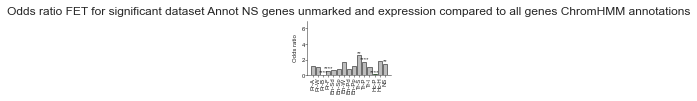

Pr-A nan 1.0 [[0, 5885], [0.0, 9083.0]]
Pr-W nan 1.0 [[0, 3464], [0.0, 11504.0]]
Pr-B nan 1.0 [[0, 806], [0.0, 14162.0]]
Pr-F nan 1.0 [[0, 1042], [0.0, 13926.0]]
En-Sd nan 1.0 [[0, 59], [0.0, 14909.0]]
En-Sp nan 1.0 [[0, 348], [0.0, 14620.0]]
En-W nan 1.0 [[0, 23], [0.0, 14945.0]]
En-Pd nan 1.0 [[0, 155], [0.0, 14813.0]]
En-Pp nan 1.0 [[0, 352], [0.0, 14616.0]]
Tr-S nan 1.0 [[0, 51], [0.0, 14917.0]]
Tr-P nan 1.0 [[0, 997], [0.0, 13971.0]]
Tr-I nan 1.0 [[0, 114], [0.0, 14854.0]]
Hc-P nan 1.0 [[0, 311], [0.0, 14657.0]]
Hc-H nan 1.0 [[0, 54], [0.0, 14914.0]]
NS nan 1.0 [[0, 747], [0.0, 14221.0]]


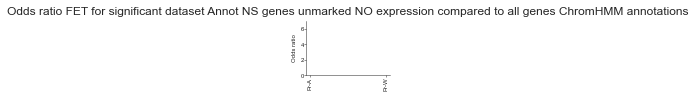

Pr-A 0.019787377731302964 4.926813612546631e-16 [[1, 5885], [78.0, 9083.0]]
Pr-W 0.04257713033694558 4.6024416856852484e-08 [[1, 3464], [78.0, 11504.0]]
Pr-B 18.02125087484889 2.696619432615863e-29 [[40, 806], [39.0, 14162.0]]
Pr-F 1.0984671206583756 0.8228515422912354 [[6, 1042], [73.0, 13926.0]]
En-Sd 0.0 1.0 [[0, 59], [79.0, 14909.0]]
En-Sp 0.0 0.26702551236445826 [[0, 348], [79.0, 14620.0]]
En-W 0.0 1.0 [[0, 23], [79.0, 14945.0]]
En-Pd 0.0 1.0 [[0, 155], [79.0, 14813.0]]
En-Pp 1.639055023923445 0.43685596099512336 [[3, 352], [76.0, 14616.0]]
Tr-S 0.0 1.0 [[0, 51], [79.0, 14917.0]]
Tr-P 0.1796543476583597 0.06442277689689606 [[1, 997], [78.0, 13971.0]]
Tr-I 1.6704903283850652 0.4553851297568427 [[1, 114], [78.0, 14854.0]]
Hc-P 18.189992666553845 1.2199182090405693e-18 [[22, 311], [57.0, 14657.0]]
Hc-H 0.0 1.0 [[0, 54], [79.0, 14914.0]]
NS 0.24407029828716575 0.18815211721269076 [[1, 747], [78.0, 14221.0]]


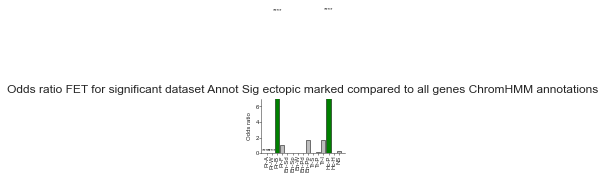

Pr-A 0.0116046275416664 1.3323109978182741e-27 [[1, 5885], [133.0, 9083.0]]
Pr-W 0.12872155683262618 7.521467592546501e-10 [[5, 3464], [129.0, 11504.0]]
Pr-B 0.0 0.0013994281800665611 [[0, 806], [134.0, 14162.0]]
Pr-F 1.1952155797949535 0.49837975221714775 [[11, 1042], [123.0, 13926.0]]
En-Sd 1.8999617688288517 0.41480363016823824 [[1, 59], [133.0, 14909.0]]
En-Sp 0.0 0.07895695912665159 [[0, 348], [134.0, 14620.0]]
En-W 0.0 1.0 [[0, 23], [134.0, 14945.0]]
En-Pd 3.7041760440110028 0.014029434043745742 [[5, 155], [129.0, 14813.0]]
En-Pp 1.2776223776223776 0.5607825725249646 [[4, 352], [130.0, 14616.0]]
Tr-S 0.0 1.0 [[0, 51], [134.0, 14917.0]]
Tr-P 5.345179869505423 1.0452593982858716e-13 [[37, 997], [97.0, 13971.0]]
Tr-I 0.9796860572483841 1.0 [[1, 114], [133.0, 14854.0]]
Hc-P 0.35435050649130867 0.5321926928594225 [[1, 311], [133.0, 14657.0]]
Hc-H 2.0765803397382343 0.38803197244119225 [[1, 54], [133.0, 14914.0]]
NS 16.892414729339894 2.886576056781655e-44 [[63, 747], [71.0, 14221.0]]


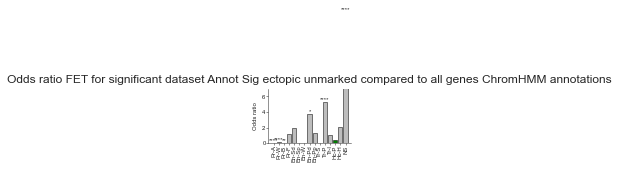

Pr-A 0.0 0.164107889841359 [[0, 5885], [5.0, 9083.0]]
Pr-W 0.0 0.5961521532563814 [[0, 3464], [5.0, 11504.0]]
Pr-B 11.713813068651778 0.026079405101370422 [[2, 806], [3.0, 14162.0]]
Pr-F 0.0 1.0 [[0, 1042], [5.0, 13926.0]]
En-Sd 0.0 1.0 [[0, 59], [5.0, 14909.0]]
En-Sp 0.0 1.0 [[0, 348], [5.0, 14620.0]]
En-W 0.0 1.0 [[0, 23], [5.0, 14945.0]]
En-Pd 0.0 1.0 [[0, 155], [5.0, 14813.0]]
En-Pp 0.0 1.0 [[0, 352], [5.0, 14616.0]]
Tr-S 0.0 1.0 [[0, 51], [5.0, 14917.0]]
Tr-P 0.0 1.0 [[0, 997], [5.0, 13971.0]]
Tr-I 0.0 1.0 [[0, 114], [5.0, 14854.0]]
Hc-P 31.419078242229368 0.004178032283020019 [[2, 311], [3.0, 14657.0]]
Hc-H 0.0 1.0 [[0, 54], [5.0, 14914.0]]
NS 0.0 1.0 [[0, 747], [5.0, 14221.0]]


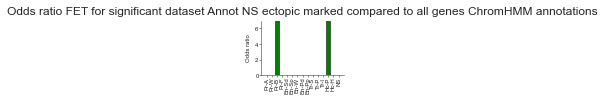

Pr-A 0.06430897762673464 0.00010407710665741586 [[1, 5885], [24.0, 9083.0]]
Pr-W 0.6325745078631915 0.4844689905451397 [[4, 3464], [21.0, 11504.0]]
Pr-B 0.0 0.6429934066382045 [[0, 806], [25.0, 14162.0]]
Pr-F 1.8224568138195778 0.2513038850245739 [[3, 1042], [22.0, 13926.0]]
En-Sd 0.0 1.0 [[0, 59], [25.0, 14909.0]]
En-Sp 1.7504789272030652 0.4452821378371988 [[1, 348], [24.0, 14620.0]]
En-W 0.0 1.0 [[0, 23], [25.0, 14945.0]]
En-Pd 0.0 1.0 [[0, 155], [25.0, 14813.0]]
En-Pp 3.610671936758893 0.11695443918898807 [[2, 352], [23.0, 14616.0]]
Tr-S 0.0 1.0 [[0, 51], [25.0, 14917.0]]
Tr-P 3.503259779338014 0.02287063148107479 [[5, 997], [20.0, 13971.0]]
Tr-I 5.429093567251462 0.17522955164759707 [[1, 114], [24.0, 14854.0]]
Hc-P 0.0 1.0 [[0, 311], [25.0, 14657.0]]
Hc-H 0.0 1.0 [[0, 54], [25.0, 14914.0]]
NS 8.958815654775966 2.0046719627012813e-05 [[8, 747], [17.0, 14221.0]]


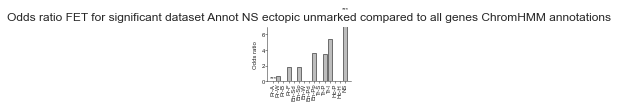

In [56]:
"""
--------------------------------------------------------
Test for enriched gorkin et al states
--------------------------------------------------------
"""
for label, d in df_dict.items():
    run_annot_plot(df_bg, d, title=f'Annot {label}')


Pr-A 1.0 1.0 [[5950, 5950], [14950.0, 14950.0]]
Pr-W 1.0 1.0 [[3508, 3508], [17392.0, 17392.0]]
Pr-B 1.0 1.0 [[894, 894], [20006.0, 20006.0]]
Pr-F 1.0 1.0 [[1102, 1102], [19798.0, 19798.0]]
En-Sd 1.0 1.0 [[68, 68], [20832.0, 20832.0]]
En-Sp 1.0 1.0 [[359, 359], [20541.0, 20541.0]]
En-W 1.0 1.0 [[35, 35], [20865.0, 20865.0]]
En-Pd 1.0 1.0 [[200, 200], [20700.0, 20700.0]]
En-Pp 1.0 1.0 [[384, 384], [20516.0, 20516.0]]
Tr-S 1.0 1.0 [[70, 70], [20830.0, 20830.0]]
Tr-P 1.0 1.0 [[1809, 1809], [19091.0, 19091.0]]
Tr-I 1.0 1.0 [[125, 125], [20775.0, 20775.0]]
Hc-P 1.0 1.0 [[404, 404], [20496.0, 20496.0]]
Hc-H 1.0 1.0 [[248, 248], [20652.0, 20652.0]]
NS 1.0 1.0 [[4923, 4923], [15977.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


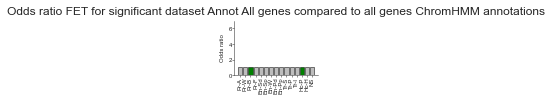

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.042823  0.324115  0.158708  0.494785  0.342727  0.641053  0.637703   
1  0.039187  0.364354  0.164689  0.494306  0.407416  0.641196  0.638086   
2  0.024976  0.259761  0.148373  0.506077  0.240191  0.642536  0.638995   
3  0.029378  0.302488  0.106220  0.372488  0.238995  0.643541  0.623684   
4  0.014115  0.223062  0.131053  0.483158  0.125550  0.641196  0.639426   

     H3k9ac       Tissue  
0  0.603301    Forebrain  
1  0.602919     Midbrain  
2  0.595550    Hindbrain  
3  0.597847  Neural-tube  
4  0.589809        E.F.P  


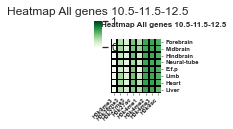

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.041531  0.287990  0.080096  0.453636  0.473876  0.615502  0.632201   
1  0.048182  0.293541  0.082249  0.498995  0.390909  0.646077  0.633876   
2  0.045024  0.334880  0.068708  0.510478  0.389426  0.652823  0.639282   
3  0.060670  0.227081  0.081483  0.542632  0.495455  0.660239  0.640909   
4  0.046268  0.247799  0.100191  0.511675  0.398325  0.657081  0.649282   

     H3k9ac       Tissue  
0  0.601148    Forebrain  
1  0.603971     Midbrain  
2  0.607464    Hindbrain  
3  0.596890  Neural-tube  
4  0.548565        E.F.P  


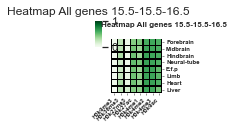

Pr-A 0.35229909214572 6.663716561307163e-87 [[356, 5950], [2539.0, 14950.0]]
Pr-W 1.0375368295310683 0.49094583681428094 [[501, 3508], [2394.0, 17392.0]]
Pr-B 9.661750940991377 0.0 [[873, 894], [2022.0, 20006.0]]
Pr-F 2.871891578249337 4.8799329861392675e-56 [[399, 1102], [2496.0, 19798.0]]
En-Sd 0.5300223895786689 0.20830706575354516 [[5, 68], [2890.0, 20832.0]]
En-Sp 1.0670356510676502 0.6483372771342493 [[53, 359], [2842.0, 20541.0]]
En-W 0.0 0.01786772714428886 [[0, 35], [2895.0, 20865.0]]
En-Pd 0.5029503644567859 0.008518869493996198 [[14, 200], [2881.0, 20700.0]]
En-Pp 0.7485405720957384 0.08474726879148752 [[40, 384], [2855.0, 20516.0]]
Tr-S 0.0 0.00016928039280276818 [[0, 70], [2895.0, 20830.0]]
Tr-P 0.5041771477994272 8.260535730979814e-16 [[132, 1809], [2763.0, 19091.0]]
Tr-I 1.7403141361256544 0.009213484726219917 [[30, 125], [2865.0, 20775.0]]
Hc-P 7.526386276073065 3.0763908487226512e-140 [[374, 404], [2521.0, 20496.0]]
Hc-H 0.08638401820372106 8.183507746720551e-11 [[3, 2

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


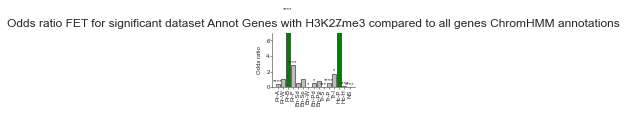

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.042142  0.159240  0.806218  0.357168  0.606218  0.897409  0.896028   
1  0.035233  0.193782  0.816580  0.339896  0.676339  0.895682  0.894991   
2  0.023834  0.125389  0.785492  0.377547  0.485665  0.903282  0.900864   
3  0.024870  0.163385  0.631779  0.223143  0.437997  0.905009  0.862176   
4  0.013126  0.112608  0.673921  0.347841  0.252504  0.897755  0.902936   

     H3k9ac       Tissue  
0  0.747841    Forebrain  
1  0.746114     Midbrain  
2  0.729879    Hindbrain  
3  0.736097  Neural-tube  
4  0.710190        E.F.P  


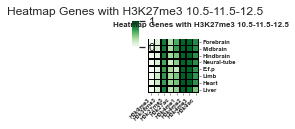

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.040415  0.131952  0.577893  0.259067  0.725734  0.851813  0.862522   
1  0.041105  0.149914  0.593782  0.354750  0.571675  0.899827  0.873230   
2  0.041796  0.179275  0.496028  0.393092  0.629361  0.915371  0.887047   
3  0.061831  0.118135  0.531606  0.442832  0.768912  0.926425  0.897064   
4  0.053541  0.152332  0.526770  0.431434  0.678756  0.912263  0.905009   

     H3k9ac       Tissue  
0  0.731952    Forebrain  
1  0.750950     Midbrain  
2  0.757858    Hindbrain  
3  0.750950  Neural-tube  
4  0.600691        E.F.P  


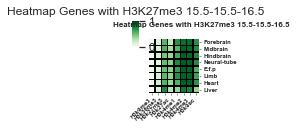

Pr-A 2.032788960005701 2.8193458353445493e-197 [[5533, 5950], [6839.0, 14950.0]]
Pr-W 1.5695952843583234 1.1903236519336677e-57 [[2975, 3508], [9397.0, 17392.0]]
Pr-B 0.032605258954793326 2.5601121716530535e-154 [[18, 894], [12354.0, 20006.0]]
Pr-F 1.0140215947870996 0.7806805468680287 [[661, 1102], [11711.0, 19798.0]]
En-Sd 1.342998767943612 0.1109410300051666 [[54, 68], [12318.0, 20832.0]]
En-Sp 1.3976231437874382 2.973874412911722e-05 [[295, 359], [12077.0, 20541.0]]
En-W 1.110315467996252 0.6857668681804585 [[23, 35], [12349.0, 20865.0]]
En-Pd 1.2017170891251021 0.10282883977853917 [[142, 200], [12230.0, 20700.0]]
En-Pp 1.4049262062767869 1.1229076033209602e-05 [[317, 384], [12055.0, 20516.0]]
Tr-S 1.2317297992973668 0.25948216184918627 [[51, 70], [12321.0, 20830.0]]
Tr-P 0.8617611172827746 0.0003881813114154639 [[934, 1809], [11438.0, 19091.0]]
Tr-I 1.176996336996337 0.25428353791792435 [[87, 125], [12285.0, 20775.0]]
Hc-P 0.08214487251833992 2.62525072545279e-57 [[20, 404], [1235

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


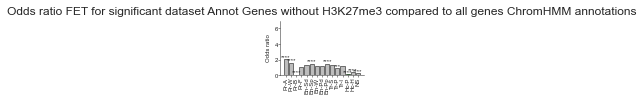

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.047527  0.498464  0.076140  0.739897  0.421112  0.849984  0.845377   
1  0.043566  0.559570  0.083495  0.741998  0.511478  0.849580  0.846185   
2  0.026592  0.399774  0.063369  0.754203  0.281038  0.850388  0.846589   
3  0.029502  0.465487  0.030149  0.567491  0.288797  0.851681  0.834142   
4  0.016489  0.342224  0.061025  0.720740  0.146298  0.849499  0.847236   

     H3k9ac       Tissue  
0  0.827029    Forebrain  
1  0.826059     Midbrain  
2  0.818946    Hindbrain  
3  0.821128  Neural-tube  
4  0.813854        E.F.P  


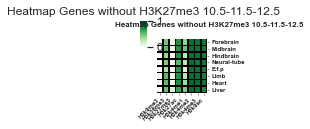

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.044779  0.448109  0.000081  0.693986  0.610168  0.819593  0.845134   
1  0.045021  0.452958  0.000000  0.746929  0.511801  0.854914  0.845538   
2  0.044617  0.514953  0.000000  0.758002  0.495635  0.861623  0.850873   
3  0.057630  0.347236  0.011316  0.796476  0.633446  0.869463  0.850226   
4  0.050356  0.372939  0.043566  0.737795  0.489007  0.865099  0.857905   

     H3k9ac       Tissue  
0  0.827756    Forebrain  
1  0.826625     Midbrain  
2  0.830666    Hindbrain  
3  0.813935  Neural-tube  
4  0.772551        E.F.P  


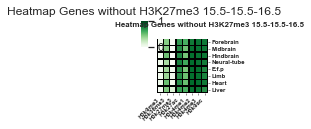

Pr-A 1.622932800129698 2.818017067299491e-92 [[5022, 5950], [7775.0, 14950.0]]
Pr-W 1.4846246759177353 7.04819175454217e-45 [[2949, 3508], [9848.0, 17392.0]]
Pr-B 1.4129216422369582 1.3014535827248074e-11 [[760, 894], [12037.0, 20006.0]]
Pr-F 1.4373626757386773 3.833534384602958e-15 [[948, 1102], [11849.0, 19798.0]]
En-Sd 1.2740666888224217 0.18993047392586293 [[53, 68], [12744.0, 20832.0]]
En-Sp 1.4157700584761927 1.0955105546292346e-05 [[309, 359], [12488.0, 20541.0]]
En-W 0.8397035314634501 0.5748447551175753 [[18, 35], [12779.0, 20865.0]]
En-Pd 1.1034986574000947 0.39619131465404356 [[135, 200], [12662.0, 20700.0]]
En-Pp 1.2738035709523428 0.0021298162746898365 [[298, 384], [12499.0, 20516.0]]
Tr-S 0.7927155505311111 0.3115949752781515 [[34, 70], [12763.0, 20830.0]]
Tr-P 0.6793885517103826 8.200875290916301e-19 [[774, 1809], [12023.0, 19091.0]]
Tr-I 1.2562160459806315 0.09547730174599986 [[96, 125], [12701.0, 20775.0]]
Hc-P 1.143157320126739 0.09501093517145413 [[282, 404], [12515.

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


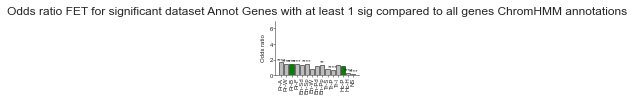

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.047511  0.441432  0.222161  0.678597  0.463624  0.871142  0.866922   
1  0.041650  0.495897  0.229116  0.677034  0.552630  0.870360  0.867860   
2  0.025865  0.352817  0.206220  0.696413  0.325545  0.873095  0.869266   
3  0.028210  0.414550  0.147456  0.514027  0.322966  0.874893  0.854497   
4  0.015863  0.304056  0.182855  0.660545  0.171212  0.871376  0.869110   

     H3k9ac       Tissue  
0  0.828944    Forebrain  
1  0.827460     Midbrain  
2  0.819020    Hindbrain  
3  0.823005  Neural-tube  
4  0.810034        E.F.P  


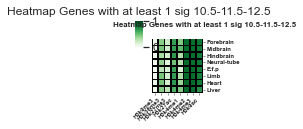

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.043135  0.389310  0.108697  0.620380  0.644135  0.838321  0.861686   
1  0.043135  0.399547  0.111667  0.684145  0.531531  0.875987  0.863796   
2  0.043057  0.453622  0.092991  0.702430  0.529030  0.884192  0.870907   
3  0.057670  0.302571  0.110260  0.744237  0.668516  0.892240  0.873017   
4  0.050324  0.331328  0.138861  0.686958  0.536610  0.885442  0.878096   

     H3k9ac       Tissue  
0  0.825584    Forebrain  
1  0.827694     Midbrain  
2  0.832304    Hindbrain  
3  0.817926  Neural-tube  
4  0.752989        E.F.P  


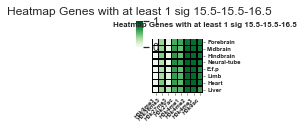

Pr-A 0.32497525839604136 1.1640352404074572e-227 [[928, 5950], [7175.0, 14950.0]]
Pr-W 0.3673669394965726 6.013577977033573e-118 [[559, 3508], [7544.0, 17392.0]]
Pr-B 0.37629090129172243 3.6768040239757575e-31 [[134, 894], [7969.0, 20006.0]]
Pr-F 0.3480550578906043 1.9226212775714226e-42 [[154, 1102], [7949.0, 19798.0]]
En-Sd 0.5681619828940478 0.04941503297992829 [[15, 68], [8088.0, 20832.0]]
En-Sp 0.3552543784613565 1.9689021737093873e-14 [[50, 359], [8053.0, 20541.0]]
En-W 1.2533302710151584 0.44150866787559584 [[17, 35], [8086.0, 20865.0]]
En-Pd 0.8369619308285643 0.24218516940897322 [[65, 200], [8038.0, 20700.0]]
En-Pp 0.5731232589081535 1.2906080718749907e-06 [[86, 384], [8017.0, 20516.0]]
Tr-S 1.3279498485894916 0.19252453714943107 [[36, 70], [8067.0, 20830.0]]
Tr-P 1.5453751333879555 5.174339676729751e-25 [[1035, 1809], [7068.0, 19091.0]]
Tr-I 0.5969531830567253 0.011438810551557772 [[29, 125], [8074.0, 20775.0]]
Hc-P 0.7755151157265833 0.014164797473373087 [[122, 404], [7981.0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


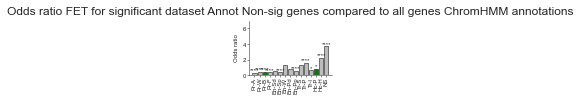

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.035419  0.138837  0.058497  0.204492  0.151796  0.277675  0.275700   
1  0.035296  0.156609  0.062940  0.205726  0.178082  0.279279  0.275207   
2  0.023572  0.112798  0.057016  0.205479  0.105393  0.278415  0.275330   
3  0.031223  0.125509  0.041096  0.148957  0.106380  0.278169  0.259163   
4  0.011354  0.095150  0.049241  0.203011  0.053437  0.277675  0.276688   

     H3k9ac       Tissue  
0  0.246946    Forebrain  
1  0.248303     Midbrain  
2  0.242626    Hindbrain  
3  0.242256  Neural-tube  
4  0.242009        E.F.P  


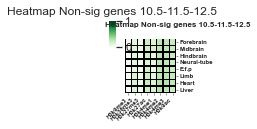

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.038998  0.127977  0.034925  0.190300  0.204986  0.263606  0.269777   
1  0.056152  0.126126  0.035789  0.206590  0.168826  0.282982  0.270764   
2  0.048130  0.147353  0.030359  0.207331  0.168950  0.287424  0.273479   
3  0.065408  0.107861  0.036036  0.224238  0.222140  0.293842  0.274343   
4  0.039862  0.115883  0.039121  0.234851  0.179933  0.296433  0.287918   

     H3k9ac       Tissue  
0  0.246699    Forebrain  
1  0.250648     Midbrain  
2  0.252376    Hindbrain  
3  0.247809  Neural-tube  
4  0.225719        E.F.P  


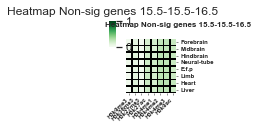

Pr-A 0.3877551020408163 7.962038072311434e-64 [[323, 5950], [2093.0, 14950.0]]
Pr-W 1.150333440516526 0.011823443786777764 [[455, 3508], [1961.0, 17392.0]]
Pr-B 9.91907553075194 0.0 [[742, 894], [1674.0, 20006.0]]
Pr-F 3.1765624737558156 1.439638420402903e-60 [[363, 1102], [2053.0, 19798.0]]
En-Sd 0.50804799531753 0.24298218828321153 [[4, 68], [2412.0, 20832.0]]
En-Sp 1.258586315625751 0.14084539274160562 [[52, 359], [2364.0, 20541.0]]
En-W 0.0 0.04582830071646458 [[0, 35], [2416.0, 20865.0]]
En-Pd 0.43017456359102246 0.005912626893783525 [[10, 200], [2406.0, 20700.0]]
En-Pp 0.7398630927402434 0.10469392935019493 [[33, 384], [2383.0, 20516.0]]
Tr-S 0.0 0.0011059894261603413 [[0, 70], [2416.0, 20830.0]]
Tr-P 0.23670218054412193 3.3037900424268224e-37 [[53, 1809], [2363.0, 19091.0]]
Tr-I 1.6675585284280936 0.02963672940273314 [[24, 125], [2392.0, 20775.0]]
Hc-P 6.276693529818098 7.806105603676734e-92 [[266, 404], [2150.0, 20496.0]]
Hc-H 0.10353194390599307 8.085095770997223e-09 [[3, 248]

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


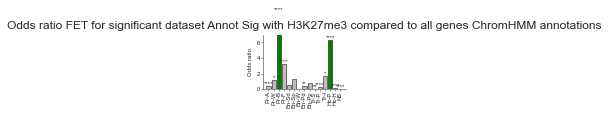

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.045530  0.164321  0.815397  0.391142  0.632036  0.926738  0.928808   
1  0.037252  0.201573  0.826159  0.372517  0.703642  0.927566  0.928808   
2  0.026076  0.126242  0.797599  0.415563  0.506623  0.933361  0.934189   
3  0.026490  0.168460  0.637003  0.247930  0.462334  0.936672  0.907699   
4  0.014073  0.117136  0.677152  0.381623  0.266970  0.925911  0.930877   

     H3k9ac       Tissue  
0  0.797185    Forebrain  
1  0.794288     Midbrain  
2  0.780629    Hindbrain  
3  0.790149  Neural-tube  
4  0.759934        E.F.P  


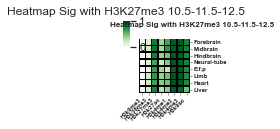

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.043460  0.134520  0.575331  0.279801  0.753725  0.883692  0.899834   
1  0.045944  0.157699  0.591474  0.388245  0.599752  0.929222  0.909768   
2  0.043874  0.186672  0.492550  0.431291  0.653146  0.943295  0.922599   
3  0.064570  0.121689  0.532699  0.487169  0.791805  0.952815  0.931705   
4  0.056705  0.154387  0.524007  0.462748  0.701987  0.937914  0.933361   

     H3k9ac       Tissue  
0  0.778146    Forebrain  
1  0.795116     Midbrain  
2  0.803394    Hindbrain  
3  0.798841  Neural-tube  
4  0.642798        E.F.P  


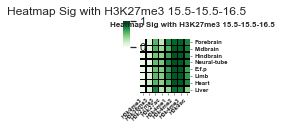

Pr-A 0.18591023853487584 1.1519219550187902e-31 [[33, 5950], [446.0, 14950.0]]
Pr-W 0.5266958268925399 1.2552471251997661e-05 [[46, 3508], [433.0, 17392.0]]
Pr-B 8.42393093162591 5.510857997808387e-63 [[131, 894], [348.0, 20006.0]]
Pr-F 1.459951739705768 0.038644068773693106 [[36, 1102], [443.0, 19798.0]]
En-Sd 0.6409057346788087 1.0 [[1, 68], [478.0, 20832.0]]
En-Sp 0.11970140208156083 0.005828216021783513 [[1, 359], [478.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [479.0, 20865.0]]
En-Pd 0.871578947368421 1.0 [[4, 200], [475.0, 20700.0]]
En-Pp 0.7923508121468926 0.7286014693125498 [[7, 384], [472.0, 20516.0]]
Tr-S 0.0 0.4112036550816187 [[0, 70], [479.0, 20830.0]]
Tr-P 2.0842855168601435 5.2179241307250416e-08 [[79, 1809], [400.0, 19091.0]]
Tr-I 2.108245243128964 0.07464393409848245 [[6, 125], [473.0, 20775.0]]
Hc-P 14.7685410050439 2.4003618636013794e-74 [[108, 404], [371.0, 20496.0]]
Hc-H 0.0 0.007610541248035641 [[0, 248], [479.0, 20652.0]]
NS 0.07628027174035705 1.4909263378110454e-39 [[

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


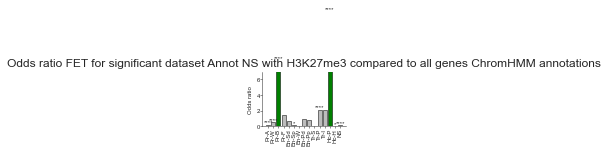

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.025052  0.133612  0.759916  0.185804  0.475992  0.749478  0.730689   
1  0.025052  0.154489  0.768267  0.175365  0.538622  0.734864  0.724426   
2  0.012526  0.121086  0.724426  0.185804  0.379958  0.751566  0.732777   
3  0.016701  0.137787  0.605428  0.098121  0.315240  0.745303  0.632568   
4  0.008351  0.089770  0.657620  0.177453  0.179541  0.755741  0.762004   

     H3k9ac       Tissue  
0  0.498956    Forebrain  
1  0.503132     Midbrain  
2  0.473904    Hindbrain  
3  0.463466  Neural-tube  
4  0.459290        E.F.P  


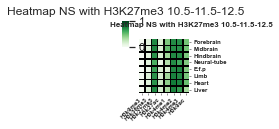

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.025052  0.118998  0.590814  0.154489  0.584551  0.691023  0.674322   
1  0.016701  0.110647  0.605428  0.185804  0.430063  0.751566  0.688935   
2  0.031315  0.141962  0.513570  0.200418  0.509395  0.774530  0.707724   
3  0.048017  0.100209  0.526096  0.219207  0.653445  0.793319  0.722338   
4  0.037578  0.141962  0.540710  0.273486  0.561587  0.782881  0.762004   

     H3k9ac       Tissue  
0  0.498956    Forebrain  
1  0.528184     Midbrain  
2  0.528184    Hindbrain  
3  0.509395  Neural-tube  
4  0.388309        E.F.P  


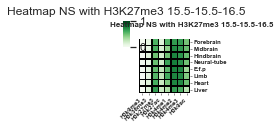

Pr-A 2.077918178887183 4.443813803464265e-188 [[4699, 5950], [5682.0, 14950.0]]
Pr-W 1.567741845008869 1.5778806819172055e-51 [[2494, 3508], [7887.0, 17392.0]]
Pr-B 0.03886957146844705 5.415866359027181e-131 [[18, 894], [10363.0, 20006.0]]
Pr-F 1.0728692921811858 0.183889323297005 [[585, 1102], [9796.0, 19798.0]]
En-Sd 1.4528933524629364 0.049206712765461694 [[49, 68], [10332.0, 20832.0]]
En-Sp 1.4524731766210413 8.154251545217595e-06 [[257, 359], [10124.0, 20541.0]]
En-W 1.035469596504046 0.8848852454778545 [[18, 35], [10363.0, 20865.0]]
En-Pd 1.2614567082683308 0.0441505634069623 [[125, 200], [10256.0, 20700.0]]
En-Pp 1.3995825507446948 4.231611350754705e-05 [[265, 384], [10116.0, 20516.0]]
Tr-S 0.9778127545596377 1.0 [[34, 70], [10347.0, 20830.0]]
Tr-P 0.7876771536840756 1.3870385194541576e-07 [[721, 1809], [9660.0, 19091.0]]
Tr-I 1.160772140847803 0.32411650390054897 [[72, 125], [10309.0, 20775.0]]
Hc-P 0.0783138226992019 6.099458826728976e-51 [[16, 404], [10365.0, 20496.0]]
Hc-H 0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


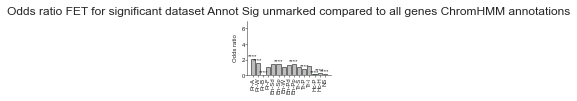

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.047972  0.505924  0.084096  0.745497  0.424429  0.858202  0.852519   
1  0.042674  0.564396  0.090165  0.747905  0.517484  0.857047  0.853675   
2  0.025816  0.405549  0.068587  0.761776  0.283402  0.859069  0.854157   
3  0.028610  0.471824  0.033523  0.575956  0.290531  0.860514  0.842115   
4  0.016280  0.347558  0.067816  0.725460  0.148926  0.858684  0.854735   

     H3k9ac       Tissue  
0  0.836336    Forebrain  
1  0.835180     Midbrain  
2  0.827955    Hindbrain  
3  0.830652  Neural-tube  
4  0.821693        E.F.P  


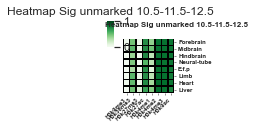

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.043059  0.448608  0.000096  0.699644  0.618630  0.827762  0.852808   
1  0.042481  0.455833  0.000000  0.753010  0.515654  0.863597  0.853097   
2  0.042867  0.515750  0.000000  0.765533  0.500144  0.870436  0.858877   
3  0.056064  0.344668  0.011945  0.804065  0.639823  0.878143  0.859358   
4  0.048839  0.372507  0.049225  0.739139  0.498122  0.873230  0.865235   

     H3k9ac       Tissue  
0  0.836625    Forebrain  
1  0.835276     Midbrain  
2  0.839033    Hindbrain  
3  0.822368  Neural-tube  
4  0.778634        E.F.P  


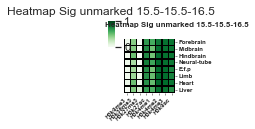

Pr-A 0.3341925267654989 4.884573508385617e-209 [[895, 5950], [6729.0, 14950.0]]
Pr-W 0.3576651523720537 4.332244637429182e-117 [[513, 3508], [7111.0, 17392.0]]
Pr-B 0.00880911011519741 3.644887870693938e-117 [[3, 894], [7621.0, 20006.0]]
Pr-F 0.282431526043533 1.2932475132017859e-51 [[118, 1102], [7506.0, 19798.0]]
En-Sd 0.5635927958568447 0.05977887587841639 [[14, 68], [7610.0, 20832.0]]
En-Sp 0.3701183154527152 4.2500885390829184e-13 [[49, 359], [7575.0, 20541.0]]
En-W 1.3322503708989841 0.34713832270830897 [[17, 35], [7607.0, 20865.0]]
En-Pd 0.8347877826259421 0.2326658359506216 [[61, 200], [7563.0, 20700.0]]
En-Pp 0.5594088248288049 9.853522949664765e-07 [[79, 384], [7545.0, 20516.0]]
Tr-S 1.4117779953309737 0.09901867986439014 [[36, 70], [7588.0, 20830.0]]
Tr-P 1.5130469760110996 1.0736968314197004e-21 [[956, 1809], [6668.0, 19091.0]]
Tr-I 0.5029075121694514 0.0014768767559743545 [[23, 125], [7601.0, 20775.0]]
Hc-P 0.09333211902004918 9.687829418164524e-38 [[14, 404], [7610.0, 204

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


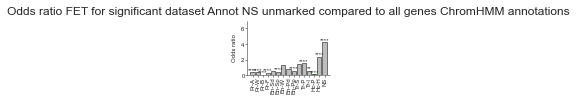

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.036070  0.139166  0.014428  0.205666  0.131427  0.248033  0.247114   
1  0.035939  0.156742  0.018625  0.207634  0.155430  0.250656  0.246983   
2  0.024265  0.112277  0.015084  0.206716  0.088143  0.248688  0.246590   
3  0.032135  0.124738  0.005640  0.152151  0.093258  0.248820  0.235703   
4  0.011542  0.095488  0.011018  0.204617  0.045514  0.247639  0.246196   

     H3k9ac       Tissue  
0  0.231112    Forebrain  
1  0.232293     Midbrain  
2  0.228095    Hindbrain  
3  0.228358  Neural-tube  
4  0.228358        E.F.P  


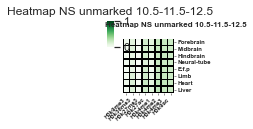

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.039874  0.128541  0.000000  0.192550  0.181139  0.236752  0.244360   
1  0.058631  0.127099  0.000000  0.207896  0.152413  0.253541  0.244491   
2  0.049187  0.147692  0.000000  0.207765  0.147560  0.256821  0.246196   
3  0.066501  0.108342  0.005247  0.224554  0.195042  0.262461  0.246196   
4  0.040005  0.114244  0.007608  0.232424  0.155955  0.265871  0.258132   

     H3k9ac       Tissue  
0  0.230850    Forebrain  
1  0.233211     Midbrain  
2  0.235047    Hindbrain  
3  0.231375  Neural-tube  
4  0.215504        E.F.P  


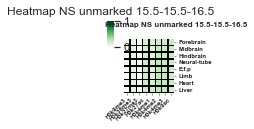

Pr-A 0.08291236150127196 1.0501448176586107e-69 [[23, 5950], [697.0, 14950.0]]
Pr-W 0.4100444955032964 1.6808726162180155e-12 [[55, 3508], [665.0, 17392.0]]
Pr-B 19.690369799241825 1.0383506306289513e-233 [[337, 894], [383.0, 20006.0]]
Pr-F 2.599144783728962 1.1139753864685481e-13 [[91, 1102], [629.0, 19798.0]]
En-Sd 0.426081976601489 0.7306414220530224 [[1, 68], [719.0, 20832.0]]
En-Sp 0.887715052390475 0.8832722284234752 [[11, 359], [709.0, 20541.0]]
En-W 0.0 0.631260195912668 [[0, 35], [720.0, 20865.0]]
En-Pd 0.5782122905027933 0.4277361635434618 [[4, 200], [716.0, 20700.0]]
En-Pp 0.752494131455399 0.47732987946935 [[10, 384], [710.0, 20516.0]]
Tr-S 0.0 0.17675160091415054 [[0, 70], [720.0, 20830.0]]
Tr-P 0.17887024388415737 3.913334135132403e-15 [[12, 1809], [708.0, 19091.0]]
Tr-I 1.6316970546984573 0.21474736726027585 [[7, 125], [713.0, 20775.0]]
Hc-P 12.0293967541084 3.1664128243083116e-83 [[138, 404], [582.0, 20496.0]]
Hc-H 0.0 0.00047212463302561867 [[0, 248], [720.0, 20652.0]]

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


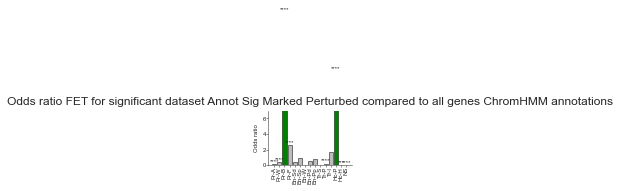

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.033333  0.069444  0.929167  0.170833  0.654167  0.876389  0.879167   
1  0.027778  0.083333  0.929167  0.176389  0.702778  0.873611  0.883333   
2  0.016667  0.050000  0.927778  0.225000  0.569444  0.883333  0.894444   
3  0.016667  0.062500  0.815278  0.145833  0.518056  0.905556  0.861111   
4  0.013889  0.050000  0.845833  0.215278  0.283333  0.875000  0.884722   

     H3k9ac       Tissue  
0  0.652778    Forebrain  
1  0.627778     Midbrain  
2  0.637500    Hindbrain  
3  0.668056  Neural-tube  
4  0.615278        E.F.P  


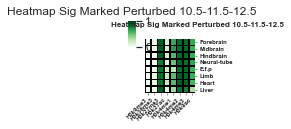

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.019444  0.040278  0.744444  0.097222  0.731944  0.811111  0.826389   
1  0.026389  0.048611  0.790278  0.166667  0.570833  0.868056  0.844444   
2  0.022222  0.052778  0.708333  0.213889  0.656944  0.894444  0.873611   
3  0.045833  0.052778  0.702778  0.275000  0.788889  0.920833  0.890278   
4  0.038889  0.065278  0.711111  0.304167  0.730556  0.895833  0.902778   

     H3k9ac       Tissue  
0  0.586111    Forebrain  
1  0.630556     Midbrain  
2  0.636111    Hindbrain  
3  0.644444  Neural-tube  
4  0.479167        E.F.P  


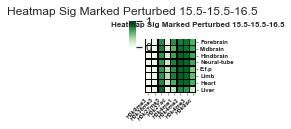

Pr-A 0.5399581035852736 3.148676762047795e-23 [[300, 5950], [1396.0, 14950.0]]
Pr-W 1.5301884933203824 6.7070558858927e-12 [[400, 3508], [1296.0, 17392.0]]
Pr-B 7.02023300183511 1.022835483723534e-152 [[405, 894], [1291.0, 20006.0]]
Pr-F 3.4316156528477335 8.73499824660694e-53 [[272, 1102], [1424.0, 19798.0]]
En-Sd 0.5428581355755533 0.3721319892454382 [[3, 68], [1693.0, 20832.0]]
En-Sp 1.417467116612948 0.04360136245777811 [[41, 359], [1655.0, 20541.0]]
En-W 0.0 0.1090187908766395 [[0, 35], [1696.0, 20865.0]]
En-Pd 0.36745562130177517 0.007610506435278198 [[6, 200], [1690.0, 20700.0]]
En-Pp 0.7345026399681212 0.1827625355707849 [[23, 384], [1673.0, 20516.0]]
Tr-S 0.0 0.009775314853106943 [[0, 70], [1696.0, 20830.0]]
Tr-P 0.26144236855333935 7.881117334008117e-25 [[41, 1809], [1655.0, 19091.0]]
Tr-I 1.6827873734365695 0.053227096892811424 [[17, 125], [1679.0, 20775.0]]
Hc-P 4.141442715700141 2.939442472701875e-33 [[128, 404], [1568.0, 20496.0]]
Hc-H 0.14756206771716557 9.47149564248533

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


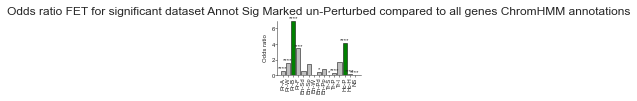

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.050708  0.204599  0.767099  0.484670  0.622642  0.948113  0.949882   
1  0.041274  0.251769  0.782429  0.455778  0.704009  0.950472  0.948113   
2  0.030071  0.158608  0.742335  0.496462  0.479953  0.954599  0.951061   
3  0.030660  0.213443  0.561321  0.291274  0.438679  0.949882  0.927476   
4  0.014151  0.145637  0.605542  0.452241  0.260024  0.947524  0.950472   

     H3k9ac       Tissue  
0  0.858491    Forebrain  
1  0.864976     Midbrain  
2  0.841392    Hindbrain  
3  0.841981  Neural-tube  
4  0.821344        E.F.P  


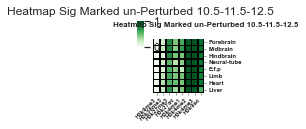

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.053656  0.174528  0.503538  0.357311  0.762972  0.914505  0.931014   
1  0.054245  0.204009  0.507075  0.482311  0.612028  0.955189  0.937500   
2  0.053066  0.243514  0.400943  0.523585  0.651533  0.964033  0.943396   
3  0.072524  0.150943  0.460495  0.577241  0.793042  0.966392  0.949292   
4  0.064269  0.192217  0.444575  0.530071  0.689858  0.955778  0.946344   

     H3k9ac       Tissue  
0  0.859670    Forebrain  
1  0.864976     Midbrain  
2  0.874410    Hindbrain  
3  0.864387  Neural-tube  
4  0.712264        E.F.P  


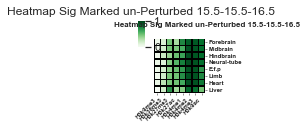

Pr-A 0.26448474126492705 1.628194885522949e-31 [[62, 5950], [589.0, 14950.0]]
Pr-W 0.8159545368317345 0.07817852278414977 [[92, 3508], [559.0, 17392.0]]
Pr-B 0.24323995720260674 5.540994145855695e-06 [[7, 894], [644.0, 20006.0]]
Pr-F 2.2690013124925428 6.244902846132799e-09 [[73, 1102], [578.0, 19798.0]]
En-Sd 2.849794801641587 0.024319999871252822 [[6, 68], [645.0, 20832.0]]
En-Sp 1.3494639196930678 0.2823773054062226 [[15, 359], [636.0, 20541.0]]
En-W 3.68558180613822 0.029429549751167672 [[4, 35], [647.0, 20865.0]]
En-Pd 3.9617224880382773 8.696499552297684e-08 [[24, 200], [627.0, 20700.0]]
En-Pp 2.222566666666667 0.00037694231016208315 [[26, 384], [625.0, 20516.0]]
Tr-S 1.8396997129609185 0.2879256588934363 [[4, 70], [647.0, 20830.0]]
Tr-P 2.433852581244168 2.668725999940841e-15 [[122, 1809], [529.0, 19091.0]]
Tr-I 2.067807153965785 0.06559796116002094 [[8, 125], [643.0, 20775.0]]
Hc-P 0.3136486755321591 0.011891449611148047 [[4, 404], [647.0, 20496.0]]
Hc-H 0.25662309259903576 0.0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


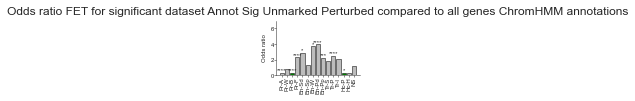

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.024578  0.164363  0.112135  0.291859  0.285714  0.473118  0.448541   
1  0.026114  0.185868  0.121352  0.270353  0.344086  0.466974  0.439324   
2  0.012289  0.112135  0.096774  0.299539  0.188940  0.474654  0.443932   
3  0.010753  0.130568  0.050691  0.153610  0.196621  0.482335  0.420891   
4  0.007680  0.118280  0.090630  0.282642  0.112135  0.479263  0.456221   

     H3k9ac       Tissue  
0  0.400922    Forebrain  
1  0.402458     Midbrain  
2  0.379416    Hindbrain  
3  0.397849  Neural-tube  
4  0.388633        E.F.P  


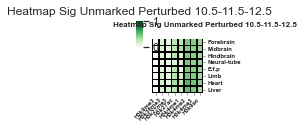

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.019969  0.072197  0.000000  0.225806  0.403994  0.457757  0.443932   
1  0.019969  0.073733  0.000000  0.256528  0.305684  0.485407  0.439324   
2  0.027650  0.069124  0.000000  0.270353  0.316436  0.520737  0.462366   
3  0.056836  0.050691  0.032258  0.336406  0.405530  0.543779  0.462366   
4  0.018433  0.139785  0.064516  0.380952  0.368664  0.540707  0.493088   

     H3k9ac       Tissue  
0  0.408602    Forebrain  
1  0.382488     Midbrain  
2  0.403994    Hindbrain  
3  0.400922  Neural-tube  
4  0.342550        E.F.P  


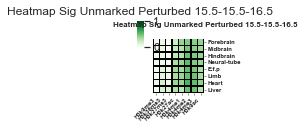

Pr-A 2.2876398153999475 2.5934172429834382e-232 [[4637, 5950], [5093.0, 14950.0]]
Pr-W 1.6250902491124466 4.5860735785421315e-58 [[2402, 3508], [7328.0, 17392.0]]
Pr-B 0.025327588917485135 6.259137329887994e-132 [[11, 894], [9719.0, 20006.0]]
Pr-F 0.997867740028879 0.9780956444229981 [[512, 1102], [9218.0, 19798.0]]
En-Sd 1.3598819521614778 0.12533070323564469 [[43, 68], [9687.0, 20832.0]]
En-Sp 1.4593780973004458 9.230419419787615e-06 [[242, 359], [9488.0, 20541.0]]
En-W 0.8589954713874022 0.7590418250384905 [[14, 35], [9716.0, 20865.0]]
En-Pd 1.085626752518434 0.4944999088278897 [[101, 200], [9629.0, 20700.0]]
En-Pp 1.3453875162434588 0.0004242367167890005 [[239, 384], [9491.0, 20516.0]]
Tr-S 0.9203240058910162 0.7479125452781517 [[30, 70], [9700.0, 20830.0]]
Tr-P 0.6923067888632138 1.373545566783198e-14 [[599, 1809], [9131.0, 19091.0]]
Tr-I 1.1004345127250155 0.5314575399264829 [[64, 125], [9666.0, 20775.0]]
Hc-P 0.06264582004609187 2.234645548878032e-51 [[12, 404], [9718.0, 20496.0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


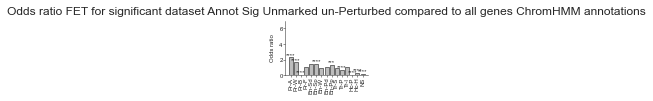

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.049538  0.528777  0.082220  0.775848  0.433710  0.883967  0.879548   
1  0.043782  0.589723  0.088078  0.779856  0.529085  0.883145  0.881398   
2  0.026721  0.425180  0.066701  0.792703  0.289723  0.884789  0.881603   
3  0.029805  0.494656  0.032374  0.604214  0.296814  0.885817  0.870298   
4  0.016855  0.362898  0.066290  0.755087  0.151387  0.884070  0.881398   

     H3k9ac       Tissue  
0  0.865468    Forebrain  
1  0.864132     Midbrain  
2  0.857965    Hindbrain  
3  0.859609  Neural-tube  
4  0.850668        E.F.P  


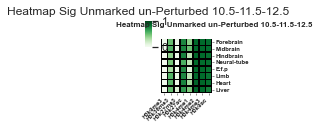

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.044604  0.473792  0.000103  0.731346  0.632991  0.852518  0.880164   
1  0.043988  0.481398  0.000000  0.786228  0.529702  0.888900  0.880781   
2  0.043885  0.545632  0.000000  0.798664  0.512436  0.893834  0.885406   
3  0.056012  0.364337  0.010586  0.835355  0.655498  0.900514  0.885920   
4  0.050874  0.388078  0.048201  0.763104  0.506783  0.895478  0.890134   

     H3k9ac       Tissue  
0  0.865262    Forebrain  
1  0.865570     Midbrain  
2  0.868140    Hindbrain  
3  0.850565  Neural-tube  
4  0.807811        E.F.P  


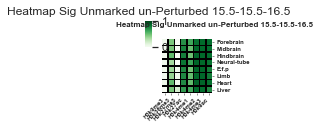

Pr-A 0.08291236150127196 1.0501448176586107e-69 [[23, 5950], [697.0, 14950.0]]
Pr-W 0.4100444955032964 1.6808726162180155e-12 [[55, 3508], [665.0, 17392.0]]
Pr-B 19.690369799241825 1.0383506306289513e-233 [[337, 894], [383.0, 20006.0]]
Pr-F 2.599144783728962 1.1139753864685481e-13 [[91, 1102], [629.0, 19798.0]]
En-Sd 0.426081976601489 0.7306414220530224 [[1, 68], [719.0, 20832.0]]
En-Sp 0.887715052390475 0.8832722284234752 [[11, 359], [709.0, 20541.0]]
En-W 0.0 0.631260195912668 [[0, 35], [720.0, 20865.0]]
En-Pd 0.5782122905027933 0.4277361635434618 [[4, 200], [716.0, 20700.0]]
En-Pp 0.752494131455399 0.47732987946935 [[10, 384], [710.0, 20516.0]]
Tr-S 0.0 0.17675160091415054 [[0, 70], [720.0, 20830.0]]
Tr-P 0.17887024388415737 3.913334135132403e-15 [[12, 1809], [708.0, 19091.0]]
Tr-I 1.6316970546984573 0.21474736726027585 [[7, 125], [713.0, 20775.0]]
Hc-P 12.0293967541084 3.1664128243083116e-83 [[138, 404], [582.0, 20496.0]]
Hc-H 0.0 0.00047212463302561867 [[0, 248], [720.0, 20652.0]]

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


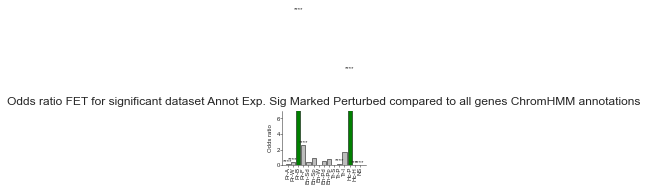

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.033333  0.069444  0.929167  0.170833  0.654167  0.876389  0.879167   
1  0.027778  0.083333  0.929167  0.176389  0.702778  0.873611  0.883333   
2  0.016667  0.050000  0.927778  0.225000  0.569444  0.883333  0.894444   
3  0.016667  0.062500  0.815278  0.145833  0.518056  0.905556  0.861111   
4  0.013889  0.050000  0.845833  0.215278  0.283333  0.875000  0.884722   

     H3k9ac       Tissue  
0  0.652778    Forebrain  
1  0.627778     Midbrain  
2  0.637500    Hindbrain  
3  0.668056  Neural-tube  
4  0.615278        E.F.P  


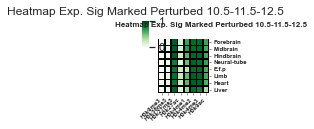

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.019444  0.040278  0.744444  0.097222  0.731944  0.811111  0.826389   
1  0.026389  0.048611  0.790278  0.166667  0.570833  0.868056  0.844444   
2  0.022222  0.052778  0.708333  0.213889  0.656944  0.894444  0.873611   
3  0.045833  0.052778  0.702778  0.275000  0.788889  0.920833  0.890278   
4  0.038889  0.065278  0.711111  0.304167  0.730556  0.895833  0.902778   

     H3k9ac       Tissue  
0  0.586111    Forebrain  
1  0.630556     Midbrain  
2  0.636111    Hindbrain  
3  0.644444  Neural-tube  
4  0.479167        E.F.P  


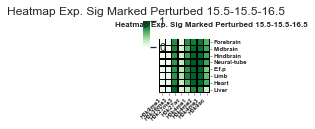

Pr-A 0.5399581035852736 3.148676762047795e-23 [[300, 5950], [1396.0, 14950.0]]
Pr-W 1.5301884933203824 6.7070558858927e-12 [[400, 3508], [1296.0, 17392.0]]
Pr-B 7.02023300183511 1.022835483723534e-152 [[405, 894], [1291.0, 20006.0]]
Pr-F 3.4316156528477335 8.73499824660694e-53 [[272, 1102], [1424.0, 19798.0]]
En-Sd 0.5428581355755533 0.3721319892454382 [[3, 68], [1693.0, 20832.0]]
En-Sp 1.417467116612948 0.04360136245777811 [[41, 359], [1655.0, 20541.0]]
En-W 0.0 0.1090187908766395 [[0, 35], [1696.0, 20865.0]]
En-Pd 0.36745562130177517 0.007610506435278198 [[6, 200], [1690.0, 20700.0]]
En-Pp 0.7345026399681212 0.1827625355707849 [[23, 384], [1673.0, 20516.0]]
Tr-S 0.0 0.009775314853106943 [[0, 70], [1696.0, 20830.0]]
Tr-P 0.26144236855333935 7.881117334008117e-25 [[41, 1809], [1655.0, 19091.0]]
Tr-I 1.6827873734365695 0.053227096892811424 [[17, 125], [1679.0, 20775.0]]
Hc-P 4.141442715700141 2.939442472701875e-33 [[128, 404], [1568.0, 20496.0]]
Hc-H 0.14756206771716557 9.47149564248533

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


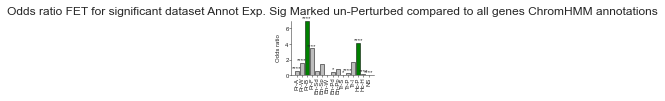

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.050708  0.204599  0.767099  0.484670  0.622642  0.948113  0.949882   
1  0.041274  0.251769  0.782429  0.455778  0.704009  0.950472  0.948113   
2  0.030071  0.158608  0.742335  0.496462  0.479953  0.954599  0.951061   
3  0.030660  0.213443  0.561321  0.291274  0.438679  0.949882  0.927476   
4  0.014151  0.145637  0.605542  0.452241  0.260024  0.947524  0.950472   

     H3k9ac       Tissue  
0  0.858491    Forebrain  
1  0.864976     Midbrain  
2  0.841392    Hindbrain  
3  0.841981  Neural-tube  
4  0.821344        E.F.P  


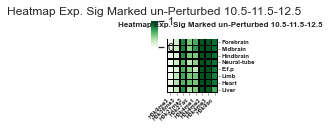

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.053656  0.174528  0.503538  0.357311  0.762972  0.914505  0.931014   
1  0.054245  0.204009  0.507075  0.482311  0.612028  0.955189  0.937500   
2  0.053066  0.243514  0.400943  0.523585  0.651533  0.964033  0.943396   
3  0.072524  0.150943  0.460495  0.577241  0.793042  0.966392  0.949292   
4  0.064269  0.192217  0.444575  0.530071  0.689858  0.955778  0.946344   

     H3k9ac       Tissue  
0  0.859670    Forebrain  
1  0.864976     Midbrain  
2  0.874410    Hindbrain  
3  0.864387  Neural-tube  
4  0.712264        E.F.P  


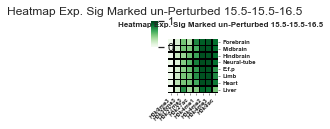

Pr-A 0.26448474126492705 1.628194885522949e-31 [[62, 5950], [589.0, 14950.0]]
Pr-W 0.8159545368317345 0.07817852278414977 [[92, 3508], [559.0, 17392.0]]
Pr-B 0.24323995720260674 5.540994145855695e-06 [[7, 894], [644.0, 20006.0]]
Pr-F 2.2690013124925428 6.244902846132799e-09 [[73, 1102], [578.0, 19798.0]]
En-Sd 2.849794801641587 0.024319999871252822 [[6, 68], [645.0, 20832.0]]
En-Sp 1.3494639196930678 0.2823773054062226 [[15, 359], [636.0, 20541.0]]
En-W 3.68558180613822 0.029429549751167672 [[4, 35], [647.0, 20865.0]]
En-Pd 3.9617224880382773 8.696499552297684e-08 [[24, 200], [627.0, 20700.0]]
En-Pp 2.222566666666667 0.00037694231016208315 [[26, 384], [625.0, 20516.0]]
Tr-S 1.8396997129609185 0.2879256588934363 [[4, 70], [647.0, 20830.0]]
Tr-P 2.433852581244168 2.668725999940841e-15 [[122, 1809], [529.0, 19091.0]]
Tr-I 2.067807153965785 0.06559796116002094 [[8, 125], [643.0, 20775.0]]
Hc-P 0.3136486755321591 0.011891449611148047 [[4, 404], [647.0, 20496.0]]
Hc-H 0.25662309259903576 0.0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


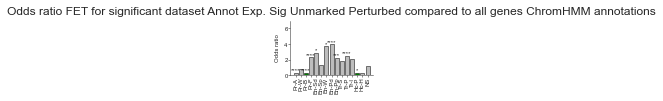

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.024578  0.164363  0.112135  0.291859  0.285714  0.473118  0.448541   
1  0.026114  0.185868  0.121352  0.270353  0.344086  0.466974  0.439324   
2  0.012289  0.112135  0.096774  0.299539  0.188940  0.474654  0.443932   
3  0.010753  0.130568  0.050691  0.153610  0.196621  0.482335  0.420891   
4  0.007680  0.118280  0.090630  0.282642  0.112135  0.479263  0.456221   

     H3k9ac       Tissue  
0  0.400922    Forebrain  
1  0.402458     Midbrain  
2  0.379416    Hindbrain  
3  0.397849  Neural-tube  
4  0.388633        E.F.P  


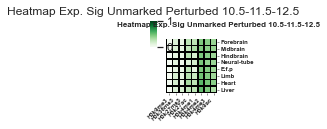

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.019969  0.072197  0.000000  0.225806  0.403994  0.457757  0.443932   
1  0.019969  0.073733  0.000000  0.256528  0.305684  0.485407  0.439324   
2  0.027650  0.069124  0.000000  0.270353  0.316436  0.520737  0.462366   
3  0.056836  0.050691  0.032258  0.336406  0.405530  0.543779  0.462366   
4  0.018433  0.139785  0.064516  0.380952  0.368664  0.540707  0.493088   

     H3k9ac       Tissue  
0  0.408602    Forebrain  
1  0.382488     Midbrain  
2  0.403994    Hindbrain  
3  0.400922  Neural-tube  
4  0.342550        E.F.P  


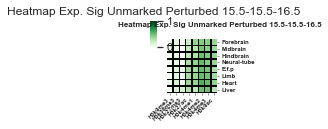

Pr-A 2.2876398153999475 2.5934172429834382e-232 [[4637, 5950], [5093.0, 14950.0]]
Pr-W 1.6250902491124466 4.5860735785421315e-58 [[2402, 3508], [7328.0, 17392.0]]
Pr-B 0.025327588917485135 6.259137329887994e-132 [[11, 894], [9719.0, 20006.0]]
Pr-F 0.997867740028879 0.9780956444229981 [[512, 1102], [9218.0, 19798.0]]
En-Sd 1.3598819521614778 0.12533070323564469 [[43, 68], [9687.0, 20832.0]]
En-Sp 1.4593780973004458 9.230419419787615e-06 [[242, 359], [9488.0, 20541.0]]
En-W 0.8589954713874022 0.7590418250384905 [[14, 35], [9716.0, 20865.0]]
En-Pd 1.085626752518434 0.4944999088278897 [[101, 200], [9629.0, 20700.0]]
En-Pp 1.3453875162434588 0.0004242367167890005 [[239, 384], [9491.0, 20516.0]]
Tr-S 0.9203240058910162 0.7479125452781517 [[30, 70], [9700.0, 20830.0]]
Tr-P 0.6923067888632138 1.373545566783198e-14 [[599, 1809], [9131.0, 19091.0]]
Tr-I 1.1004345127250155 0.5314575399264829 [[64, 125], [9666.0, 20775.0]]
Hc-P 0.06264582004609187 2.234645548878032e-51 [[12, 404], [9718.0, 20496.0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


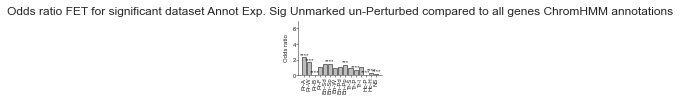

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.049538  0.528777  0.082220  0.775848  0.433710  0.883967  0.879548   
1  0.043782  0.589723  0.088078  0.779856  0.529085  0.883145  0.881398   
2  0.026721  0.425180  0.066701  0.792703  0.289723  0.884789  0.881603   
3  0.029805  0.494656  0.032374  0.604214  0.296814  0.885817  0.870298   
4  0.016855  0.362898  0.066290  0.755087  0.151387  0.884070  0.881398   

     H3k9ac       Tissue  
0  0.865468    Forebrain  
1  0.864132     Midbrain  
2  0.857965    Hindbrain  
3  0.859609  Neural-tube  
4  0.850668        E.F.P  


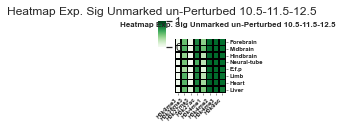

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.044604  0.473792  0.000103  0.731346  0.632991  0.852518  0.880164   
1  0.043988  0.481398  0.000000  0.786228  0.529702  0.888900  0.880781   
2  0.043885  0.545632  0.000000  0.798664  0.512436  0.893834  0.885406   
3  0.056012  0.364337  0.010586  0.835355  0.655498  0.900514  0.885920   
4  0.050874  0.388078  0.048201  0.763104  0.506783  0.895478  0.890134   

     H3k9ac       Tissue  
0  0.865262    Forebrain  
1  0.865570     Midbrain  
2  0.868140    Hindbrain  
3  0.850565  Neural-tube  
4  0.807811        E.F.P  


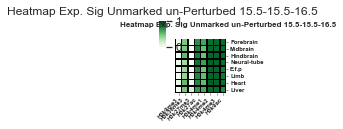

Pr-A 0.3877551020408163 7.962038072311434e-64 [[323, 5950], [2093.0, 14950.0]]
Pr-W 1.150333440516526 0.011823443786777764 [[455, 3508], [1961.0, 17392.0]]
Pr-B 9.91907553075194 0.0 [[742, 894], [1674.0, 20006.0]]
Pr-F 3.1765624737558156 1.439638420402903e-60 [[363, 1102], [2053.0, 19798.0]]
En-Sd 0.50804799531753 0.24298218828321153 [[4, 68], [2412.0, 20832.0]]
En-Sp 1.258586315625751 0.14084539274160562 [[52, 359], [2364.0, 20541.0]]
En-W 0.0 0.04582830071646458 [[0, 35], [2416.0, 20865.0]]
En-Pd 0.43017456359102246 0.005912626893783525 [[10, 200], [2406.0, 20700.0]]
En-Pp 0.7398630927402434 0.10469392935019493 [[33, 384], [2383.0, 20516.0]]
Tr-S 0.0 0.0011059894261603413 [[0, 70], [2416.0, 20830.0]]
Tr-P 0.23670218054412193 3.3037900424268224e-37 [[53, 1809], [2363.0, 19091.0]]
Tr-I 1.6675585284280936 0.02963672940273314 [[24, 125], [2392.0, 20775.0]]
Hc-P 6.276693529818098 7.806105603676734e-92 [[266, 404], [2150.0, 20496.0]]
Hc-H 0.10353194390599307 8.085095770997223e-09 [[3, 248]

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


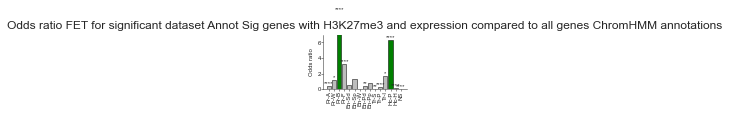

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.045530  0.164321  0.815397  0.391142  0.632036  0.926738  0.928808   
1  0.037252  0.201573  0.826159  0.372517  0.703642  0.927566  0.928808   
2  0.026076  0.126242  0.797599  0.415563  0.506623  0.933361  0.934189   
3  0.026490  0.168460  0.637003  0.247930  0.462334  0.936672  0.907699   
4  0.014073  0.117136  0.677152  0.381623  0.266970  0.925911  0.930877   

     H3k9ac       Tissue  
0  0.797185    Forebrain  
1  0.794288     Midbrain  
2  0.780629    Hindbrain  
3  0.790149  Neural-tube  
4  0.759934        E.F.P  


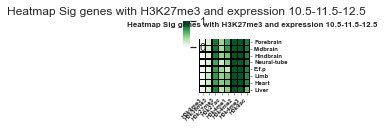

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.043460  0.134520  0.575331  0.279801  0.753725  0.883692  0.899834   
1  0.045944  0.157699  0.591474  0.388245  0.599752  0.929222  0.909768   
2  0.043874  0.186672  0.492550  0.431291  0.653146  0.943295  0.922599   
3  0.064570  0.121689  0.532699  0.487169  0.791805  0.952815  0.931705   
4  0.056705  0.154387  0.524007  0.462748  0.701987  0.937914  0.933361   

     H3k9ac       Tissue  
0  0.778146    Forebrain  
1  0.795116     Midbrain  
2  0.803394    Hindbrain  
3  0.798841  Neural-tube  
4  0.642798        E.F.P  


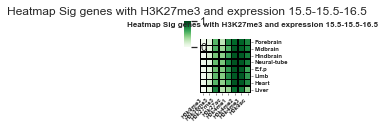

Pr-A nan 1.0 [[0, 5950], [0.0, 14950.0]]
Pr-W nan 1.0 [[0, 3508], [0.0, 17392.0]]
Pr-B nan 1.0 [[0, 894], [0.0, 20006.0]]
Pr-F nan 1.0 [[0, 1102], [0.0, 19798.0]]
En-Sd nan 1.0 [[0, 68], [0.0, 20832.0]]
En-Sp nan 1.0 [[0, 359], [0.0, 20541.0]]
En-W nan 1.0 [[0, 35], [0.0, 20865.0]]
En-Pd nan 1.0 [[0, 200], [0.0, 20700.0]]
En-Pp nan 1.0 [[0, 384], [0.0, 20516.0]]
Tr-S nan 1.0 [[0, 70], [0.0, 20830.0]]
Tr-P nan 1.0 [[0, 1809], [0.0, 19091.0]]
Tr-I nan 1.0 [[0, 125], [0.0, 20775.0]]
Hc-P nan 1.0 [[0, 404], [0.0, 20496.0]]
Hc-H nan 1.0 [[0, 248], [0.0, 20652.0]]
NS nan 1.0 [[0, 4923], [0.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


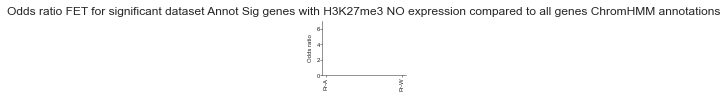

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0        0         0         0        0        0        0        0       0   
1        0         0         0        0        0        0        0       0   
2        0         0         0        0        0        0        0       0   
3        0         0         0        0        0        0        0       0   
4        0         0         0        0        0        0        0       0   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


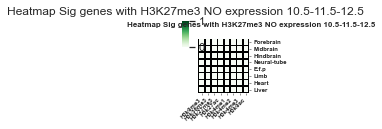

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0        0         0         0        0        0        0        0       0   
1        0         0         0        0        0        0        0       0   
2        0         0         0        0        0        0        0       0   
3        0         0         0        0        0        0        0       0   
4        0         0         0        0        0        0        0       0   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


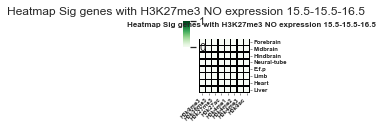

Pr-A 2.077918178887183 4.443813803464265e-188 [[4699, 5950], [5682.0, 14950.0]]
Pr-W 1.567741845008869 1.5778806819172055e-51 [[2494, 3508], [7887.0, 17392.0]]
Pr-B 0.03886957146844705 5.415866359027181e-131 [[18, 894], [10363.0, 20006.0]]
Pr-F 1.0728692921811858 0.183889323297005 [[585, 1102], [9796.0, 19798.0]]
En-Sd 1.4528933524629364 0.049206712765461694 [[49, 68], [10332.0, 20832.0]]
En-Sp 1.4524731766210413 8.154251545217595e-06 [[257, 359], [10124.0, 20541.0]]
En-W 1.035469596504046 0.8848852454778545 [[18, 35], [10363.0, 20865.0]]
En-Pd 1.2614567082683308 0.0441505634069623 [[125, 200], [10256.0, 20700.0]]
En-Pp 1.3995825507446948 4.231611350754705e-05 [[265, 384], [10116.0, 20516.0]]
Tr-S 0.9778127545596377 1.0 [[34, 70], [10347.0, 20830.0]]
Tr-P 0.7876771536840756 1.3870385194541576e-07 [[721, 1809], [9660.0, 19091.0]]
Tr-I 1.160772140847803 0.32411650390054897 [[72, 125], [10309.0, 20775.0]]
Hc-P 0.0783138226992019 6.099458826728976e-51 [[16, 404], [10365.0, 20496.0]]
Hc-H 0

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


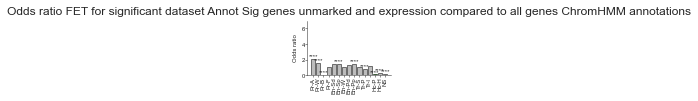

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.047972  0.505924  0.084096  0.745497  0.424429  0.858202  0.852519   
1  0.042674  0.564396  0.090165  0.747905  0.517484  0.857047  0.853675   
2  0.025816  0.405549  0.068587  0.761776  0.283402  0.859069  0.854157   
3  0.028610  0.471824  0.033523  0.575956  0.290531  0.860514  0.842115   
4  0.016280  0.347558  0.067816  0.725460  0.148926  0.858684  0.854735   

     H3k9ac       Tissue  
0  0.836336    Forebrain  
1  0.835180     Midbrain  
2  0.827955    Hindbrain  
3  0.830652  Neural-tube  
4  0.821693        E.F.P  


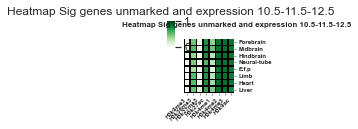

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.043059  0.448608  0.000096  0.699644  0.618630  0.827762  0.852808   
1  0.042481  0.455833  0.000000  0.753010  0.515654  0.863597  0.853097   
2  0.042867  0.515750  0.000000  0.765533  0.500144  0.870436  0.858877   
3  0.056064  0.344668  0.011945  0.804065  0.639823  0.878143  0.859358   
4  0.048839  0.372507  0.049225  0.739139  0.498122  0.873230  0.865235   

     H3k9ac       Tissue  
0  0.836625    Forebrain  
1  0.835276     Midbrain  
2  0.839033    Hindbrain  
3  0.822368  Neural-tube  
4  0.778634        E.F.P  


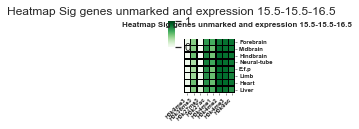

Pr-A nan 1.0 [[0, 5950], [0.0, 14950.0]]
Pr-W nan 1.0 [[0, 3508], [0.0, 17392.0]]
Pr-B nan 1.0 [[0, 894], [0.0, 20006.0]]
Pr-F nan 1.0 [[0, 1102], [0.0, 19798.0]]
En-Sd nan 1.0 [[0, 68], [0.0, 20832.0]]
En-Sp nan 1.0 [[0, 359], [0.0, 20541.0]]
En-W nan 1.0 [[0, 35], [0.0, 20865.0]]
En-Pd nan 1.0 [[0, 200], [0.0, 20700.0]]
En-Pp nan 1.0 [[0, 384], [0.0, 20516.0]]
Tr-S nan 1.0 [[0, 70], [0.0, 20830.0]]
Tr-P nan 1.0 [[0, 1809], [0.0, 19091.0]]
Tr-I nan 1.0 [[0, 125], [0.0, 20775.0]]
Hc-P nan 1.0 [[0, 404], [0.0, 20496.0]]
Hc-H nan 1.0 [[0, 248], [0.0, 20652.0]]
NS nan 1.0 [[0, 4923], [0.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


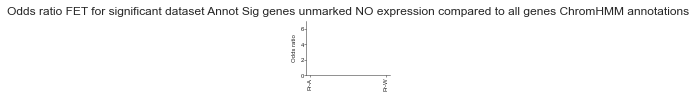

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0        0         0         0        0        0        0        0       0   
1        0         0         0        0        0        0        0       0   
2        0         0         0        0        0        0        0       0   
3        0         0         0        0        0        0        0       0   
4        0         0         0        0        0        0        0       0   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


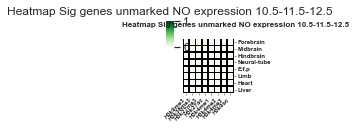

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0        0         0         0        0        0        0        0       0   
1        0         0         0        0        0        0        0       0   
2        0         0         0        0        0        0        0       0   
3        0         0         0        0        0        0        0       0   
4        0         0         0        0        0        0        0       0   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


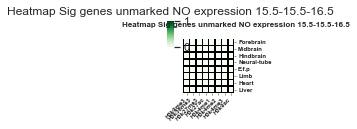

Pr-A 0.4825532862151483 0.00016732315029309571 [[29, 5950], [151.0, 14950.0]]
Pr-W 1.1545586604395432 0.42477906982120184 [[34, 3508], [146.0, 17392.0]]
Pr-B 7.682026111055461 1.5386420269728448e-22 [[46, 894], [134.0, 20006.0]]
Pr-F 1.996168582375479 0.010731058025017393 [[18, 1102], [162.0, 19798.0]]
En-Sd 1.7114689451199474 0.4471533028342336 [[1, 68], [179.0, 20832.0]]
En-Sp 0.31964955416193336 0.379817362752911 [[1, 359], [179.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [180.0, 20865.0]]
En-Pd 1.7542372881355932 0.2509538868165968 [[3, 200], [177.0, 20700.0]]
En-Pp 0.6003043071161048 0.7763546998958062 [[2, 384], [178.0, 20516.0]]
Tr-S 0.0 1.0 [[0, 70], [180.0, 20830.0]]
Tr-P 0.6207849640685461 0.1804117858393482 [[10, 1809], [170.0, 19091.0]]
Tr-I 2.816949152542373 0.09683370052163891 [[3, 125], [177.0, 20775.0]]
Hc-P 8.182689236665603 3.8741092139370984e-14 [[25, 404], [155.0, 20496.0]]
Hc-H 0.0 0.28070281165290983 [[0, 248], [180.0, 20652.0]]
NS 0.03646493071959867 2.6655431701547816e-

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


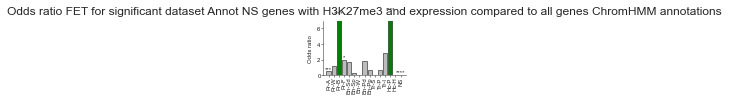

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.038889  0.288889  0.727778  0.422222  0.533333  0.916667  0.905556   
1  0.033333  0.327778  0.777778  0.400000  0.588889  0.894444  0.905556   
2  0.016667  0.250000  0.694444  0.422222  0.427778  0.916667  0.911111   
3  0.022222  0.305556  0.550000  0.238889  0.355556  0.927778  0.827778   
4  0.005556  0.172222  0.605556  0.388889  0.205556  0.922222  0.933333   

     H3k9ac       Tissue  
0  0.711111    Forebrain  
1  0.716667     Midbrain  
2  0.688889    Hindbrain  
3  0.688889  Neural-tube  
4  0.677778        E.F.P  


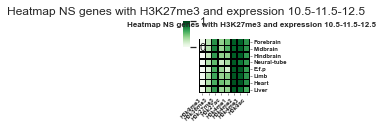

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.038889  0.261111  0.577778  0.350000  0.672222  0.850000  0.838889   
1  0.033333  0.250000  0.550000  0.411111  0.527778  0.911111  0.872222   
2  0.038889  0.327778  0.450000  0.427778  0.588889  0.933333  0.872222   
3  0.077778  0.183333  0.444444  0.455556  0.755556  0.938889  0.872222   
4  0.038889  0.300000  0.450000  0.511111  0.572222  0.927778  0.927778   

     H3k9ac       Tissue  
0  0.733333    Forebrain  
1  0.761111     Midbrain  
2  0.744444    Hindbrain  
3  0.716667  Neural-tube  
4  0.655556        E.F.P  


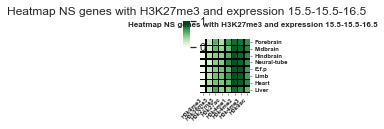

Pr-A 0.034069220908702465 1.025219848457126e-36 [[4, 5950], [295.0, 14950.0]]
Pr-W 0.20729522167350684 1.8857760933578993e-11 [[12, 3508], [287.0, 17392.0]]
Pr-B 8.888488155721424 1.4315082404053564e-43 [[85, 894], [214.0, 20006.0]]
Pr-F 1.1508160510492085 0.515790272206679 [[18, 1102], [281.0, 19798.0]]
En-Sd 0.0 1.0 [[0, 68], [299.0, 20832.0]]
En-Sp 0.0 0.011047862838876151 [[0, 359], [299.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [299.0, 20865.0]]
En-Pd 0.34731543624161076 0.536971611439804 [[1, 200], [298.0, 20700.0]]
En-Pp 0.9086238662131519 1.0 [[5, 384], [294.0, 20516.0]]
Tr-S 0.0 0.6288807049114573 [[0, 70], [299.0, 20830.0]]
Tr-P 3.1660033167495856 8.373804189907646e-14 [[69, 1809], [230.0, 19091.0]]
Tr-I 1.6844594594594595 0.4316913357189447 [[3, 125], [296.0, 20775.0]]
Hc-P 19.494499449944996 2.7605708010697163e-66 [[83, 404], [216.0, 20496.0]]
Hc-H 0.0 0.05384381581150446 [[0, 248], [299.0, 20652.0]]
NS 0.10071865347033979 5.1763575284702236e-23 [[9, 4923], [290.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


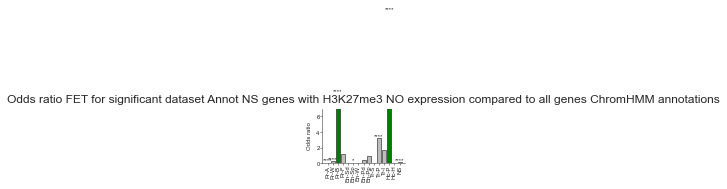

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.016722  0.040134  0.779264  0.043478  0.441472  0.648829  0.625418   
1  0.020067  0.050167  0.762542  0.040134  0.508361  0.638796  0.615385   
2  0.010033  0.043478  0.742475  0.043478  0.351171  0.652174  0.625418   
3  0.013378  0.036789  0.638796  0.013378  0.290970  0.635452  0.515050   
4  0.010033  0.040134  0.688963  0.050167  0.163880  0.655518  0.658863   

     H3k9ac       Tissue  
0  0.371237    Forebrain  
1  0.374582     Midbrain  
2  0.344482    Hindbrain  
3  0.327759  Neural-tube  
4  0.327759        E.F.P  


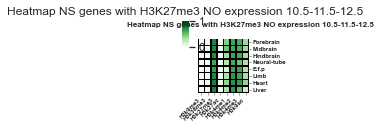

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.016722  0.033445  0.598662  0.036789  0.531773  0.595318  0.575251   
1  0.006689  0.026756  0.638796  0.050167  0.371237  0.655518  0.578595   
2  0.026756  0.030100  0.551839  0.063545  0.461538  0.678930  0.608696   
3  0.030100  0.050167  0.575251  0.076923  0.591973  0.705686  0.632107   
4  0.036789  0.046823  0.595318  0.130435  0.555184  0.695652  0.662207   

     H3k9ac       Tissue  
0  0.357860    Forebrain  
1  0.387960     Midbrain  
2  0.397993    Hindbrain  
3  0.384615  Neural-tube  
4  0.227425        E.F.P  


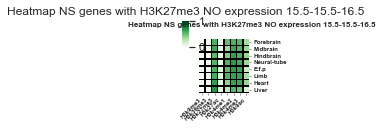

Pr-A 1.8111604192238693 4.444731087375691e-34 [[834, 5950], [1157.0, 14950.0]]
Pr-W 1.5792761294902098 1.5348245619626754e-15 [[481, 3508], [1510.0, 17392.0]]
Pr-B 0.0 1.2773386355874239e-36 [[0, 894], [1991.0, 20006.0]]
Pr-F 0.7129918069685783 0.004113751786359846 [[76, 1102], [1915.0, 19798.0]]
En-Sd 0.7712813221965523 0.833895099530771 [[5, 68], [1986.0, 20832.0]]
En-Sp 1.1132904595030573 0.5289933081093066 [[38, 359], [1953.0, 20541.0]]
En-W 1.5008631851532153 0.39189054848329685 [[5, 35], [1986.0, 20865.0]]
En-Pd 0.8913373860182371 0.8082159966786635 [[17, 200], [1974.0, 20700.0]]
En-Pp 1.4328047103317862 0.020146395156615357 [[52, 384], [1939.0, 20516.0]]
Tr-S 2.562671877261543 0.001561958236371458 [[17, 70], [1974.0, 20830.0]]
Tr-P 1.2642645415591707 0.0028927146251480143 [[213, 1809], [1778.0, 19091.0]]
Tr-I 1.2616396761133604 0.3671799935479154 [[15, 125], [1976.0, 20775.0]]
Hc-P 0.10212918624524757 9.499526508867285e-12 [[4, 404], [1987.0, 20496.0]]
Hc-H 0.5473025865161942 0.

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


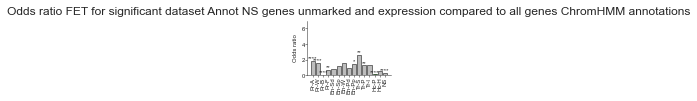

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.045203  0.459568  0.034656  0.710698  0.403817  0.807132  0.808137   
1  0.048217  0.534405  0.048719  0.711200  0.480161  0.810648  0.807132   
2  0.030638  0.369663  0.036163  0.714716  0.268709  0.805123  0.807132   
3  0.034154  0.432446  0.012557  0.523355  0.279759  0.805625  0.792567   
4  0.017579  0.314415  0.025615  0.696133  0.132597  0.801607  0.808137   

     H3k9ac       Tissue  
0  0.778503    Forebrain  
1  0.778503     Midbrain  
2  0.771974    Hindbrain  
3  0.771472  Neural-tube  
4  0.772978        E.F.P  


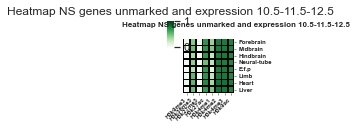

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.053742  0.445505  0.000000  0.664490  0.566047  0.776996  0.805123   
1  0.058262  0.437971  0.000000  0.715218  0.491713  0.809643  0.806128   
2  0.053742  0.510799  0.000000  0.718734  0.472125  0.815671  0.809141   
3  0.065796  0.360623  0.008036  0.756906  0.600201  0.824209  0.802612   
4  0.058262  0.375188  0.014063  0.730789  0.441487  0.822702  0.819689   

     H3k9ac       Tissue  
0  0.781517    Forebrain  
1  0.781517     Midbrain  
2  0.787042    Hindbrain  
3  0.769965  Neural-tube  
4  0.740834        E.F.P  


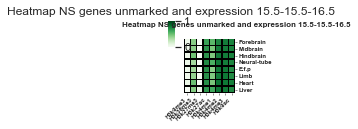

Pr-A 0.027506982692574518 0.0 [[61, 5950], [5572.0, 14950.0]]
Pr-W 0.028325288874746873 0.0 [[32, 3508], [5601.0, 17392.0]]
Pr-B 0.01192437445611358 9.326250757294948e-89 [[3, 894], [5630.0, 20006.0]]
Pr-F 0.1349582765404992 5.317132482215724e-68 [[42, 1102], [5591.0, 19798.0]]
En-Sd 0.49025186176888963 0.04925187784613247 [[9, 68], [5624.0, 20832.0]]
En-Sp 0.11195125794109691 1.013231572490825e-24 [[11, 359], [5622.0, 20541.0]]
En-W 1.2726764429308461 0.47550014244429095 [[12, 35], [5621.0, 20865.0]]
En-Pd 0.8148148148148148 0.2384514049626631 [[44, 200], [5589.0, 20700.0]]
En-Pp 0.25731916696396717 2.906636635790075e-16 [[27, 384], [5606.0, 20516.0]]
Tr-S 1.0070995979439157 1.0 [[19, 70], [5614.0, 20830.0]]
Tr-P 1.603504065674807 4.5134549095739947e-23 [[743, 1809], [4890.0, 19091.0]]
Tr-I 0.23637333333333332 1.9203139344302495e-06 [[8, 125], [5625.0, 20775.0]]
Hc-P 0.09022349860808596 9.53836666939461e-30 [[10, 404], [5623.0, 20496.0]]
Hc-H 2.9702506983612973 4.790131088955153e-27 [

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


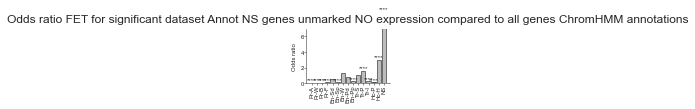

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.032842  0.025919  0.007279  0.027161  0.035150  0.050417  0.048819   
1  0.031600  0.023256  0.007989  0.029647  0.040653  0.052725  0.048997   
2  0.022013  0.021303  0.007634  0.027161  0.024321  0.052015  0.048464   
3  0.031422  0.015977  0.003195  0.020948  0.027339  0.052015  0.038878   
4  0.009409  0.018108  0.005858  0.030889  0.014735  0.051837  0.047577   

     H3k9ac       Tissue  
0  0.037635    Forebrain  
1  0.039233     Midbrain  
2  0.035860    Hindbrain  
3  0.036393  Neural-tube  
4  0.035860        E.F.P  


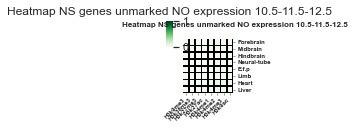

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.034972  0.016510  0.000000  0.025741  0.045091  0.045802  0.046157   
1  0.058761  0.017220  0.000000  0.028582  0.032487  0.056986  0.045979   
2  0.047577  0.019350  0.000000  0.027161  0.032842  0.059293  0.047222   
3  0.066750  0.019173  0.004261  0.036393  0.051837  0.063909  0.049530   
4  0.033552  0.022013  0.005326  0.056276  0.055033  0.069057  0.059648   

     H3k9ac       Tissue  
0  0.036215    Forebrain  
1  0.039411     Midbrain  
2  0.039943    Hindbrain  
3  0.041008  Neural-tube  
4  0.029824        E.F.P  


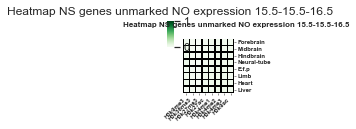

Pr-A 0.03221288515406162 2.1712251115447024e-10 [[1, 5950], [78.0, 14950.0]]
Pr-W 0.06356167587638512 1.355063031415357e-05 [[1, 3508], [78.0, 17392.0]]
Pr-B 22.951872884758792 3.983154277160978e-33 [[40, 894], [39.0, 20006.0]]
Pr-F 1.4766178554558338 0.3122983122978357 [[6, 1102], [73.0, 19798.0]]
En-Sd 0.0 1.0 [[0, 68], [79.0, 20832.0]]
En-Sp 0.0 0.6478141289640501 [[0, 359], [79.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [79.0, 20865.0]]
En-Pd 0.0 1.0 [[0, 200], [79.0, 20700.0]]
En-Pp 2.108963815789474 0.17898912941056028 [[3, 384], [76.0, 20516.0]]
Tr-S 0.0 1.0 [[0, 70], [79.0, 20830.0]]
Tr-P 0.13529928704058058 0.013953699081058613 [[1, 1809], [78.0, 19091.0]]
Tr-I 2.1307692307692307 0.3792300141401266 [[1, 125], [78.0, 20775.0]]
Hc-P 19.581031787389264 2.3187404002586847e-19 [[22, 404], [57.0, 20496.0]]
Hc-H 0.0 1.0 [[0, 248], [79.0, 20652.0]]
NS 0.04160742094928566 2.6764200512883924e-08 [[1, 4923], [78.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


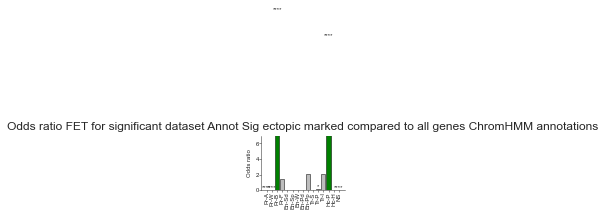

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.025316  0.025316  0.886076  0.101266  0.620253  0.810127  0.822785   
1  0.000000  0.063291  0.886076  0.063291  0.670886  0.797468  0.797468   
2  0.012658  0.037975  0.924051  0.050633  0.556962  0.822785  0.822785   
3  0.025316  0.025316  0.797468  0.012658  0.417722  0.835443  0.759494   
4  0.012658  0.037975  0.822785  0.088608  0.354430  0.835443  0.848101   

     H3k9ac       Tissue  
0  0.531646    Forebrain  
1  0.518987     Midbrain  
2  0.455696    Hindbrain  
3  0.455696  Neural-tube  
4  0.493671        E.F.P  


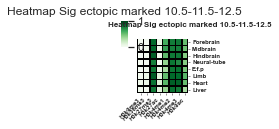

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.012658  0.050633  0.734177  0.037975  0.734177  0.810127  0.759494   
1  0.012658  0.025316  0.822785  0.050633  0.582278  0.835443  0.772152   
2  0.025316  0.025316  0.708861  0.025316  0.670886  0.860759  0.797468   
3  0.025316  0.025316  0.721519  0.050633  0.772152  0.886076  0.848101   
4  0.012658  0.025316  0.734177  0.164557  0.721519  0.886076  0.898734   

     H3k9ac       Tissue  
0  0.481013    Forebrain  
1  0.531646     Midbrain  
2  0.531646    Hindbrain  
3  0.556962  Neural-tube  
4  0.329114        E.F.P  


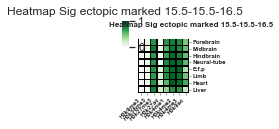

Pr-A 0.018891767233209074 3.1519200599235126e-18 [[1, 5950], [133.0, 14950.0]]
Pr-W 0.1921632061379085 6.414713199062247e-06 [[5, 3508], [129.0, 17392.0]]
Pr-B 0.0 0.004626545161825099 [[0, 894], [134.0, 20006.0]]
Pr-F 1.606672273619288 0.12311159693721282 [[11, 1102], [123.0, 19798.0]]
En-Sd 2.303405572755418 0.35705547878012184 [[1, 68], [133.0, 20832.0]]
En-Sp 0.0 0.17874485820628966 [[0, 359], [134.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [134.0, 20865.0]]
En-Pd 4.011627906976744 0.010155249469547337 [[5, 200], [129.0, 20700.0]]
En-Pp 1.6439102564102563 0.316831117062513 [[4, 384], [130.0, 20516.0]]
Tr-S 0.0 1.0 [[0, 70], [134.0, 20830.0]]
Tr-P 4.025502498959954 1.779723082809111e-10 [[37, 1809], [97.0, 19091.0]]
Tr-I 1.2496240601503759 0.5541078622677988 [[1, 125], [133.0, 20775.0]]
Hc-P 0.38144867118290776 0.5257431512745099 [[1, 404], [133.0, 20496.0]]
Hc-H 0.6261217560029105 1.0 [[1, 248], [133.0, 20652.0]]
NS 2.879702345701264 4.1889592848491065e-09 [[63, 4923], [71.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


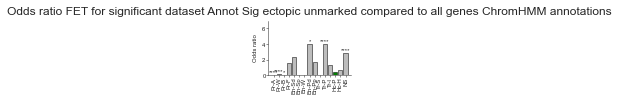

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.037313  0.037313  0.029851  0.074627  0.208955  0.201493  0.156716   
1  0.037313  0.029851  0.037313  0.067164  0.194030  0.216418  0.156716   
2  0.037313  0.037313  0.029851  0.074627  0.111940  0.208955  0.156716   
3  0.022388  0.029851  0.007463  0.022388  0.104478  0.201493  0.126866   
4  0.022388  0.022388  0.014925  0.074627  0.104478  0.238806  0.179104   

     H3k9ac       Tissue  
0  0.126866    Forebrain  
1  0.134328     Midbrain  
2  0.089552    Hindbrain  
3  0.097015  Neural-tube  
4  0.111940        E.F.P  


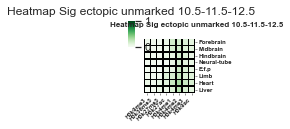

    H3k9me3  H3k36me3  H3k27me3   H3k27ac   H3k4me1   H3k4me2   H3k4me3  \
0  0.029851  0.014925       0.0  0.044776  0.201493  0.171642  0.141791   
1  0.044776  0.014925       0.0  0.074627  0.111940  0.231343  0.164179   
2  0.044776  0.022388       0.0  0.097015  0.156716  0.268657  0.156716   
3  0.067164  0.014925       0.0  0.104478  0.216418  0.268657  0.149254   
4  0.044776  0.022388       0.0  0.171642  0.261194  0.335821  0.223881   

     H3k9ac       Tissue  
0  0.104478    Forebrain  
1  0.111940     Midbrain  
2  0.111940    Hindbrain  
3  0.126866  Neural-tube  
4  0.067164        E.F.P  


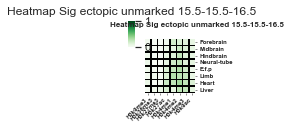

Pr-A 0.0 0.33063917806645804 [[0, 5950], [5.0, 14950.0]]
Pr-W 0.0 0.5975294080385802 [[0, 3508], [5.0, 17392.0]]
Pr-B 14.918717375093214 0.016830697560635856 [[2, 894], [3.0, 20006.0]]
Pr-F 0.0 1.0 [[0, 1102], [5.0, 19798.0]]
En-Sd 0.0 1.0 [[0, 68], [5.0, 20832.0]]
En-Sp 0.0 1.0 [[0, 359], [5.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [5.0, 20865.0]]
En-Pd 0.0 1.0 [[0, 200], [5.0, 20700.0]]
En-Pp 0.0 1.0 [[0, 384], [5.0, 20516.0]]
Tr-S 0.0 1.0 [[0, 70], [5.0, 20830.0]]
Tr-P 0.0 1.0 [[0, 1809], [5.0, 19091.0]]
Tr-I 0.0 1.0 [[0, 125], [5.0, 20775.0]]
Hc-P 33.82178217821782 0.003619362020101844 [[2, 404], [3.0, 20496.0]]
Hc-H 0.0 1.0 [[0, 248], [5.0, 20652.0]]
NS 0.0 0.5977294939371893 [[0, 4923], [5.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


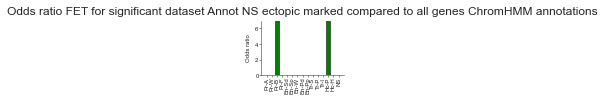

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0        0         0       1.0      0.0      0.6      0.8      0.8     0.4   
1        0         0       1.0      0.0      0.4      0.8      0.8     0.6   
2        0         0       0.8      0.0      0.4      0.8      0.8     0.4   
3        0         0       0.8      0.0      0.4      0.8      0.8     0.6   
4        0         0       1.0      0.0      0.4      0.8      0.8     0.4   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


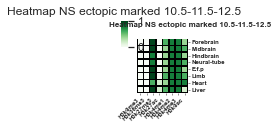

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0        0         0       0.8      0.0      0.6      0.6      0.6     0.2   
1        0         0       0.8      0.0      0.6      0.8      0.8     0.6   
2        0         0       0.8      0.0      0.6      0.8      0.8     0.4   
3        0         0       0.8      0.2      0.6      0.8      0.8     0.4   
4        0         0       0.8      0.2      0.6      0.8      0.8     0.4   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


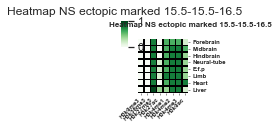

Pr-A 0.10469187675070028 0.0034994111002326425 [[1, 5950], [24.0, 14950.0]]
Pr-W 0.9443448987348645 1.0 [[4, 3508], [21.0, 17392.0]]
Pr-B 0.0 0.6252457651512446 [[0, 894], [25.0, 20006.0]]
Pr-F 2.449843260188088 0.14303289172618586 [[3, 1102], [22.0, 19798.0]]
En-Sd 0.0 1.0 [[0, 68], [25.0, 20832.0]]
En-Sp 2.3840529247910864 0.35215352993318566 [[1, 359], [24.0, 20541.0]]
En-W 0.0 1.0 [[0, 35], [25.0, 20865.0]]
En-Pd 0.0 1.0 [[0, 200], [25.0, 20700.0]]
En-Pp 4.645833333333333 0.07708776101598697 [[2, 384], [23.0, 20516.0]]
Tr-S 0.0 1.0 [[0, 70], [25.0, 20830.0]]
Tr-P 2.638336097291321 0.0600793504725192 [[5, 1809], [20.0, 19091.0]]
Tr-I 6.925 0.1402207550079517 [[1, 125], [24.0, 20775.0]]
Hc-P 0.0 1.0 [[0, 404], [25.0, 20496.0]]
Hc-H 0.0 1.0 [[0, 248], [25.0, 20652.0]]
NS 1.5272370983737797 0.3451081590052232 [[8, 4923], [17.0, 15977.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


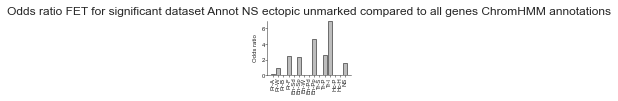

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0     0.04      0.00      0.12     0.16     0.20     0.40     0.36    0.28   
1     0.08      0.08      0.08     0.12     0.20     0.40     0.36    0.28   
2     0.04      0.04      0.12     0.12     0.08     0.36     0.32    0.24   
3     0.00      0.00      0.04     0.04     0.08     0.36     0.32    0.24   
4     0.00      0.08      0.04     0.20     0.04     0.40     0.36    0.24   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


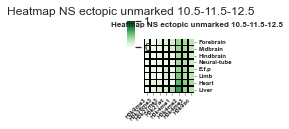

   H3k9me3  H3k36me3  H3k27me3  H3k27ac  H3k4me1  H3k4me2  H3k4me3  H3k9ac  \
0     0.08      0.08       0.0     0.12     0.32     0.44     0.36    0.32   
1     0.04      0.08       0.0     0.20     0.16     0.44     0.40    0.32   
2     0.00      0.04       0.0     0.16     0.28     0.48     0.40    0.32   
3     0.08      0.04       0.0     0.20     0.44     0.60     0.40    0.28   
4     0.12      0.04       0.0     0.20     0.36     0.56     0.48    0.20   

        Tissue  
0    Forebrain  
1     Midbrain  
2    Hindbrain  
3  Neural-tube  
4        E.F.P  


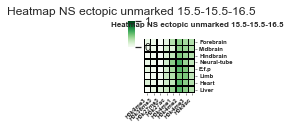

In [33]:
for label, d in df_dict.items():
    run_annot_plot(df_bg, d, title=f'Annot {label}')
    plot_mark_heatmap(d, None, title=f'Heatmap {label}')

In [58]:
for label, d in df_dict.items():
    try:
        logFC_up = d[d['log2FoldChange_fb'] > 0.5]
        logFC_down = d[d['log2FoldChange_fb'] < -0.5]
        u.dp([label, len(d), 100 * (len(d)/len(df_all))])
        print('LogFC up: ', len(logFC_up), 100 * (len(logFC_up)/len(d)))
        print('LogFC down: ', len(logFC_down), 100 * (len(logFC_down)/len(d)))
    except:
        print("unable to run:", label)

--------------------------------------------------------------------------------
                       All genes	14968	71.61722488038278	                       
--------------------------------------------------------------------------------
LogFC up:  3030 20.243185462319616
LogFC down:  1554 10.38214858364511
--------------------------------------------------------------------------------
                  Genes with H3K27me3	2596	12.421052631578949	                  
--------------------------------------------------------------------------------
LogFC up:  1279 49.26810477657935
LogFC down:  212 8.166409861325114
--------------------------------------------------------------------------------
                Genes without H3K27me3	12372	59.196172248803826	                
--------------------------------------------------------------------------------
LogFC up:  1751 14.152925961849338
LogFC down:  1342 10.847074038150662
-----------------------------------------------------------

## 15) Plot the general trend of the RNA seq

No handles with labels found to put in legend.


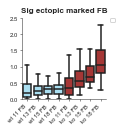

No handles with labels found to put in legend.


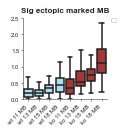

No handles with labels found to put in legend.


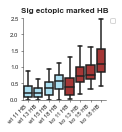

No handles with labels found to put in legend.


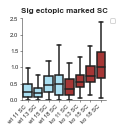

No handles with labels found to put in legend.


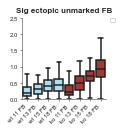

No handles with labels found to put in legend.


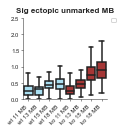

No handles with labels found to put in legend.


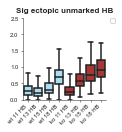

No handles with labels found to put in legend.


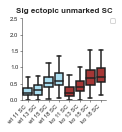

No handles with labels found to put in legend.


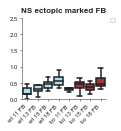

No handles with labels found to put in legend.


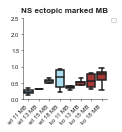

No handles with labels found to put in legend.


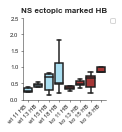

No handles with labels found to put in legend.


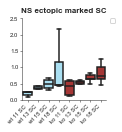

No handles with labels found to put in legend.


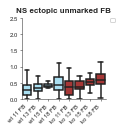

No handles with labels found to put in legend.


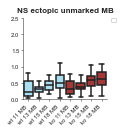

No handles with labels found to put in legend.


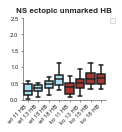

No handles with labels found to put in legend.


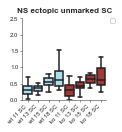

In [59]:

fb_genes = ['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6']
mb_genes = ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4']
hb_genes = ['Phox2b', 'Krox20', 'Fev', 'Hoxb1',  'Hoxd3']
sc_genes = ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11','Hoxa7', 'Hoxa9', 'Hoxa10',
            'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13']
progenitors = ['Sox2', 'Sox1', 'Sox3', 'Hes1', 'Hes5']
neurons = ['Tubb3', 'Snap25', 'Syt1', 'Slc32a1','Slc17a6']
glia = ['Pdgfra', 'Cspg4', 'Aqp4', 'Egfr', 'Slc6a11']

from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statannot import add_stat_annotation

hox_genes = sc_genes
forebrain_genes = fb_genes
h3cols = []
fb_rna_cols = []
sc_rna_cols = []

# Do it in this way so they are correctly ordered
for c in df_bg.columns:
    if 'H3K27me' in c and 'signal' in c:
        h3cols.append(c)
    elif 'wt' in c:
        if 'fb' in c:
            fb_rna_cols.append(c)
        if 'sc' in c:
            sc_rna_cols.append(c)
for c in df_bg.columns:
    if 'ko' in c:
        if 'fb' in c:
            fb_rna_cols.append(c)
        if 'sc' in c:
            sc_rna_cols.append(c)

wt_colour = "#AADFF1"   
    
def plot_gene_boxplot(df, title, cluster_id, cols):
    boxplot = Boxplot(df, gene_name, cols[0])
    boxplot.label_font_size = 6
    boxplot.title_font_size = 8
    sns.set(rc={'figure.figsize': (1.5, 1.5), 'font.family': 'sans-serif',
                    'font.sans-serif': 'Arial', 'font.size': 8.0}, style='ticks')
    boxplot.palette = sci_colour
    box_df = boxplot.format_data_for_boxplot(df, cols, gene_name, df[gene_name].values)
    is_hox = []
    sns.set_style("ticks")
    for c in box_df['Samples'].values:
        if 'Hox' in c:
            is_hox.append('Hox')
        else:
            is_hox.append('Hox like')
    box_df['is_hox'] = is_hox

    boxplot = Boxplot(box_df, "Conditions", "Values", add_stats=False, add_dots=False, 
                       order=cols)
    boxplot.label_font_size = 6
    boxplot.title_font_size = 8
    plt.rcParams['figure.figsize'] = (1.5,1.5)
    sns.set(rc={'figure.figsize': (1.5, 1.5), 'font.family': 'sans-serif',
                    'font.sans-serif': 'Arial', 'font.size': 8.0}, style='ticks')
    boxplot.palette = sci_colour
    ax = boxplot.plot()
    ax.tick_params(labelsize=6)
    
    plt.title(title, {'fontsize': 8, 'fontweight': 700})
    ax.set_ylim(0, 2.5)
    c = 0
    for b in ax.artists:
        if c < len(cols)/2:
            b.set_facecolor(wt_colour)
        else:
            b.set_facecolor(ko_colour)
        c += 1
    save_fig(f'{title}')
    
    plt.show()

avgs_fb = [['wt11fb1',
         'wt11fb2'],
         ['wt13fb1',
         'wt13fb2'],
         ['wt15fb1',
         'wt15fb2'],
         ['wt18fb1',
         'wt18fb2'],
         ['ko11fb1',
         'ko11fb2'],
         ['ko13fb1',
         'ko13fb2'],
         ['ko15fb1',
         'ko15fb2'],
         ['ko18fb1',
         'ko18fb2']]

avgs_sc = [['wt11sc1',
         'wt11sc2'],
         ['wt13sc1',
         'wt13sc2'],
         ['wt15sc1',
         'wt15sc2'],
         ['wt18sc1',
         'wt18sc2'],
         ['ko11sc1',
         'ko11sc2'],
         ['ko13sc1',
         'ko13sc2'],
         ['ko15sc1',
         'ko15sc2'],
         ['ko18sc1',
         'ko18sc2']]
avgs_hb = [['wt11hb1',
         'wt11hb2'],
         ['wt13hb1',
         'wt13hb2'],
         ['wt15hb1',
         'wt15hb2'],
         ['wt18hb1',
         'wt18hb2'],
         ['ko11hb1',
         'ko11hb2'],
         ['ko13hb1',
         'ko13hb2'],
         ['ko15hb1',
         'ko15hb2'],
         ['ko18hb1',
         'ko18hb2']]

avgs_mb = [['wt11mb1',
         'wt11mb2'],
         ['wt13mb1',
         'wt13mb2'],
         ['wt15mb1',
         'wt15mb2'],
         ['wt18mb1',
         'wt18mb2'],
         ['ko11mb1',
         'ko11mb2'],
         ['ko13mb1',
         'ko13mb2'],
         ['ko15mb1',
         'ko15mb2'],
         ['ko18mb1',
         'ko18mb2']]
for label, df in df_dict.items():
    if 'ectopic' in label:

        avgs_df = pd.DataFrame()
        avgs_df[gene_name] = df[gene_name].values
        fb_cols = []
        for f in avgs_fb:
            new_col = f'{f[0][:2]} {f[0][2:4]} FB'
            avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
            fb_cols.append(new_col)

        sc_cols = []
        for f in avgs_sc:
            new_col = f'{f[0][:2]} {f[0][2:4]} SC'
            avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
            sc_cols.append(new_col)

        mb_cols = []
        for f in avgs_mb:
            new_col = f'{f[0][:2]} {f[0][2:4]} MB'
            avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
            mb_cols.append(new_col)

        hb_cols = []
        for f in avgs_hb:
            new_col = f'{f[0][:2]} {f[0][2:4]} HB'
            avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
            hb_cols.append(new_col)
        plot_gene_boxplot(avgs_df, f'{label} FB', '', fb_cols)
        plot_gene_boxplot(avgs_df, f'{label} MB', '', mb_cols)
        plot_gene_boxplot(avgs_df, f'{label} HB', '', hb_cols)

        plot_gene_boxplot(avgs_df, f'{label} SC', '', sc_cols)

In [60]:
"""
---------------------------------------------------------------
            Read in results from DEseq2 and format DFs nicer
---------------------------------------------------------------
"""


# Want to consider genes that are DE in FB & MB vs SC and HB and then look at those 
# which are "consistently affected"
# i.e. for each gene make a "code of how it was affected"
df_all = pd.read_csv(f'{output_dir}df-all_epi-2500_{date}.csv')

df_dict = {}
deseq2_files = os.listdir(r_dir)
for f in deseq2_files:
    if 'DEseq2' in f:
        try:
            de_df = pd.read_csv(os.path.join(r_dir, f))
            de_df = de_df.rename(columns={de_df.columns[0]: 'u_id'})
            gene_names = [s.split('-')[1] for s in list(de_df['u_id'].values)]
            gene_ids = [s.split('-')[0] for s in list(de_df['u_id'].values)]
            de_df['padj'] = de_df['padj'].fillna(1) # Replace Nan p values with 1.0s
            # Replace Nans with 0's for other values
            de_df = de_df.replace(np.nan, 0)
            de_df[gene_id] = gene_ids
            de_df[gene_name] = gene_names
            df_dict[f] = de_df
        except:
            print(f)

/Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


merged_df_FEATURE_COUNTS_DEseq2Norm_20210124.csv


## Plot the venn diagrams of overlapping DE genes


In [30]:
df_dict.keys()

fb_unique_genes = []
mb_unique_genes = []
hb_unique_genes = []
sc_unique_genes = []
anterior_genes = []
posterior_genes = []

# DEseq2_CNS_wt_fb-hb_20210124.csv
fb_genes_all = []
mb_genes_all = []
hb_genes_all = []
sc_genes_all = []
cutoff = 2.0
neg_cutoff = -2.0
for k, d in df_dict.items():
    if 'wt_fb-' in k:
        gs = d[d['padj'] < 0.05]
        gs = gs[gs['log2FoldChange'] > cutoff] # Only want those that are "selectively on " in FB
        fb_genes_all += list(gs[gene_name].values)
    if 'wt_' in k and 'mb' in k:
        gs = d[d['padj'] < 0.05]
        if k == 'DEseq2_CNS_wt_fb-mb_20210124.csv':
            gs = gs[gs['log2FoldChange'] < neg_cutoff]
        else:
            gs = gs[gs['log2FoldChange'] > cutoff]
        mb_genes_all += list(gs[gene_name].values)
    if 'wt_' in k and 'hb' in k:
        gs = d[d['padj'] < 0.05]
        if k == 'DEseq2_CNS_wt_hb-sc_20210124.csv':
            gs = gs[gs['log2FoldChange'] > cutoff]
        else:
            gs = gs[gs['log2FoldChange'] < neg_cutoff]
        hb_genes_all += list(gs[gene_name].values)
    if 'wt_' in k and 'sc' in k:
        gs = d[d['padj'] < 0.05]
        gs = gs[gs['log2FoldChange'] < neg_cutoff] # Only want those that are "selectively on " in FB
        sc_genes_all += list(gs[gene_name].values)

/Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


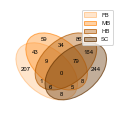

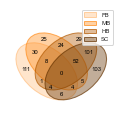

In [62]:
# Now see which are also in the consistently affected genes
const_aff = pd.read_csv(f'{output_dir}df-consistent_epi-2500_{date}.csv')
const_aff_genes = const_aff[gene_name]

plot_venn([set(fb_genes_all), 
           set(mb_genes_all), set(hb_genes_all), set(sc_genes_all)],
          ['FB', 'MB', 'HB', 'SC'], 'SpecificGenes_loc', colours=[fb_colour, mb_colour, hb_colour, sc_colour])

plot_venn([set(fb_genes_all) & set(const_aff_genes), 
           set(mb_genes_all) & set(const_aff_genes), 
           set(hb_genes_all) & set(const_aff_genes), 
           set(sc_genes_all) & set(const_aff_genes)],
          ['FB', 'MB', 'HB', 'SC'], 'SpecificGenes_CAFF_loc', colours=[fb_colour, mb_colour, hb_colour, sc_colour])

## Print out the genes for the table

This is just for supp. info

In [64]:
mb_caff = set(mb_genes_all) & set(const_aff_genes)
fb_caff = set(fb_genes_all) & set(const_aff_genes)
hb_caff = set(hb_genes_all) & set(const_aff_genes)
sc_caff = set(sc_genes_all) & set(const_aff_genes)

fb_spec = []
anterior_spec = []
for g in fb_caff:
    if g not in mb_caff and g not in hb_caff and g not in sc_caff:
        fb_spec.append(g)
    if g in mb_caff and g not in hb_caff and g not in sc_caff:
        anterior_spec.append(g)
        
mb_spec = []
for g in mb_caff:
    if g not in fb_caff and g not in hb_caff and g not in sc_caff:
        mb_spec.append(g)
        
posterior_spec = []
hb_spec = []
for g in hb_caff:
    if g not in mb_caff and g not in fb_caff and g not in sc_caff:
        hb_spec.append(g)
    if g in sc_caff and g not in mb_caff and g not in fb_caff:
        posterior_spec.append(g)
        
sc_spec = []
for g in sc_caff:
    if g not in mb_caff and g not in hb_caff and g not in fb_caff:
        sc_spec.append(g)
       


print(', '.join(fb_spec), '\n')
print(', '.join(mb_spec), '\n')
print(', '.join(hb_spec), '\n')
print(', '.join(sc_spec), '\n')
print(', '.join(anterior_spec), '\n')
print(', '.join(posterior_spec), '\n')

Cdca2, Cenpe, Satb2, Cdca5, Abcg8, Esco2, Alx3, Lipg, Ly6g6e, Dmrta1, Spc25, H2ac11, Mpped1, Drd1, Top2a, Melk, F2rl1, Isl1, Kif11, Vgll2, Arx, Bub1, Tiam2, Gsc, Spata18, Cdc25c, Gabrd, Knl1, Lhx8, Kif18b, Aurkb, Ticrr, Car12, Cldn6, Mfng, Foxg1, Sla, Depdc1b, Arhgap11a, Cdc20, Ccna2, Neurod6, Cdca7, Cenpa, Six6, Pclaf, Fam81b, Rrm2, Mki67, Shisa2, Ndc80, Neurod2, Ermn, Mn1, Ube2c, Kif22, Gsx2, Edar, Cdc45, Exo1, Alx1, Sstr2, Trp73, Kcnj4, Krt8, Foxo6, Wdr63, Ccnb1, Fzd8, Cdca3, Kif4, Zbtb18, 4833427G06Rik, Gipr, Vax1, Sox3, Cntnap3, Ect2, Clspn, Cldn3, Sgo1, Gucy1b2, Kif2c, Tfap2c, Prr32, Tbx15, Pif1, Ska1, Ppp1r1b, Lrr1, Mybl2, Wfdc2, 1700012B09Rik, Troap, Mms22l, AC151602.1, Eme1, Crym, Slc17a7, Ncapg, Sox5, Hrob, Hmgb2, Pbk, Uhrf1, Krt18, Bub1b, Neurog2, Mcidas, Rbm47, Cep55 

Foxa1, Foxd2, Ptf1a, Fgf15, Slc13a5, Krt73, Fgf3, Foxn4, Cnpy1, Gpr6, Aldh1a1, Bhlhe23, Sec14l5, Slc6a3, Sall4, Tafa4, Ttc6, Dbx1, Onecut1, Tal2, Pitx1, Cpne9, Ano1, Irx6, Gsc2 

Amn, Pnmt, Frmpd3, Aqp5, Atp1

## Run AP_axis functional

Run the functional enrichment and then re-read in the values from the GSEA and use this to plot the
pathway terms.


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from adjustText import adjust_text

from sciviso import Vis


class Volcanoplot(Vis):

    def __init__(self, df: pd.DataFrame, log_fc: str, p_val: str, label_column: str, title='',
                 xlabel='', ylabel='', invert=False, p_val_cutoff=0.05,
                 log_fc_cuttoff=2, label_big_sig=False, colours=None, offset=None,
                 text_colours=None, values_to_label=None, max_labels=10, values_colours=None,
                 figsize=(1.5, 1.5), title_font_size=8, label_font_size=6, title_font_weight=700):
        super().__init__(df, figsize=figsize, title_font_size=title_font_size, label_font_size=label_font_size,
                         title_font_weight=title_font_weight)
        super().__init__(df)
        self.log_fc = log_fc
        self.p_val = p_val
        self.p_val_cutoff = p_val_cutoff
        self.log_fc_cuttoff = log_fc_cuttoff
        self.values_to_label = values_to_label
        self.label_big_sig = label_big_sig
        self.invert = invert
        self.label_column = label_column
        self.offset = offset
        self.label = 'volcanoplot'
        self.colours = {'ns_small-neg-logFC': 'lightgrey',
                        'ns_small-pos-logFC': 'lightgrey',
                        'ns_big-neg-logFC': 'grey',
                        'ns_big-pos-logFC': 'grey',
                        'sig_small-neg-logFC': 'lightgrey',
                        'sig_small-pos-logFC': 'lightgrey',
                        'sig_big-neg-logFC': '#df80ff',
                        'sig_big-pos-logFC': '#ffa366'} if colours is None else colours
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title
        self.figsize = figsize
        self.max_labels = max_labels
        self.values_colours = values_colours or {}
        self.text_colours = text_colours or {}

    def add_scatter_and_annotate(self, fig: plt, x_all: np.array, y_all: np.array,
                                 colour: str, idxs: np.array, annotate=False, s=20):
        x = x_all[idxs]
        y = y_all[idxs]
        ax = fig.scatter(x, y, c=colour, alpha=self.opacity, s=s, vmin=-10.0, vmax=10.0)

        # Check if we want to annotate any of these with their gene IDs

        if self.values_to_label is not None:
            texts = []
            labels = self.df[self.label_column].values[idxs]
            for i, name in enumerate(labels):
                if name in self.values_to_label:
                    lbl_bg = self.values_colours.get(name)
                    color = self.text_colours.get(name)
                    texts.append(fig.text(x[i], y[i], name, color=color, fontsize=6,
                                          bbox=dict(fc="white", alpha=0.5, boxstyle='round,pad=0.1', lw=0)))
            adjust_text(texts, force_text=2.0)
        # Check if the user wants these labeled
        if self.label_big_sig and annotate:
            # If they do have a limit on the number of ones we show (i.e. we don't want 10000 gene names...)
            max_values = -1 * self.max_labels
            if len(y) < self.max_labels:
                max_values = -1 * (len(y) - 1)
            most_sig_idxs = np.argpartition(y, max_values)[max_values:]
            labels = self.df[self.label_column].values[idxs][most_sig_idxs]
            x = x[most_sig_idxs]
            y = y[most_sig_idxs]
            # We only label the ones with the max log fc
            for i, name in enumerate(labels):
                name = (' ').join(name.split('_')[1:]) #Format nicer
                fig.annotate(name, (x[i], y[i]),
                             xytext=(0, 10),
                             textcoords='offset points', ha='center', va='bottom',
                             bbox=dict(boxstyle='round,pad=0.25', 
                                       fc=colour, alpha=0.2)
                             )
        return ax

    def plot(self):
        """
        For annotation styling see: https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate
        Returns
        -------

        """
        # if offset is not given, make the offset the smallest value in the dataset
        if not self.offset:
            vals = self.df[self.p_val].values
            self.offset = np.min(vals[np.nonzero(vals)])
            self.u.warn_p(['No offset was provided, setting offset to be smallest value recorded in dataset: ',
                           self.offset])

        # x axis has log_fc, first only plot the values < cutoff
        x = self.df[self.log_fc].values
        y = -1 * np.log10(self.df[self.p_val].values + self.offset)

        log_fc_np = self.df[self.log_fc].values
        p_val_np = self.df[self.p_val].values

        if self.invert:
            x = -1 * np.log10(self.df[self.p_val].values + self.offset)
            y = self.df[self.log_fc].values
        sig_small_pos_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) < self.log_fc_cuttoff)
                                       & (log_fc_np > 0))
        sig_big_pos_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) >= self.log_fc_cuttoff)
                                     & (log_fc_np > 0))

        sig_small_neg_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) < self.log_fc_cuttoff)
                                       & (log_fc_np <= 0))
        sig_big_neg_logfc = np.where((p_val_np <= self.p_val_cutoff) & (np.abs(log_fc_np) >= self.log_fc_cuttoff)
                                     & (log_fc_np <= 0))

        # Plot the points
        fig, ax = plt.subplots(figsize=self.figsize)
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_small-pos-logFC'], sig_small_pos_logfc)
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_big-pos-logFC'], 
                                      sig_big_pos_logfc, annotate=True, s=40)

        # Negative
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_small-neg-logFC'], sig_small_neg_logfc)
        self.add_scatter_and_annotate(ax, x, y, self.colours['sig_big-neg-logFC'], sig_big_neg_logfc, annotate=True, s=40)
        self.add_labels()
        ax.tick_params(labelsize=6)
        ax.tick_params(direction='out', length=2, width=0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['top'].set_linewidth(0)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0)
        ax.tick_params(labelsize=6)
        ax.tick_params(axis='x', which='major', pad=0)
        ax.tick_params(axis='y', which='major', pad=0)
        return ax


Nothing significant for:  GSEA_log2FoldChange_p11_padj_p11Rank_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	6.1e-09	
--------------------------------------------------------------------------------


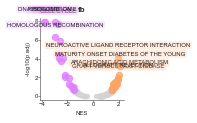

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.676274111573837e-07	
--------------------------------------------------------------------------------


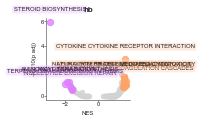

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.4623655913978495	
--------------------------------------------------------------------------------


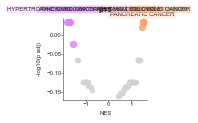

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	7.999738149709953e-06	
--------------------------------------------------------------------------------


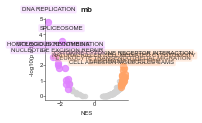

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	6.0333333333333344e-09	
--------------------------------------------------------------------------------


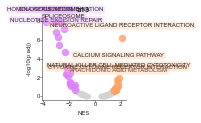

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.09497298107778476	
--------------------------------------------------------------------------------


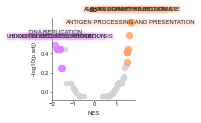

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	7.7489952815105e-06	
--------------------------------------------------------------------------------


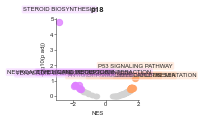

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.009588451068305224	
--------------------------------------------------------------------------------


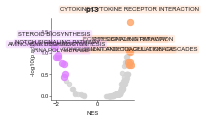

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	4.921090650064962e-06	
--------------------------------------------------------------------------------


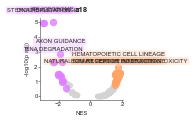

Nothing significant for:  GSEA_log2FoldChange_a11_padj_a11Rank_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.49e-08	
--------------------------------------------------------------------------------


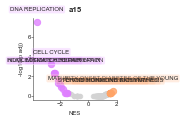

In [34]:
for f in os.listdir(fig_dir):
    if 'GSEA' in f and 'KEGG' in f and 'padj' in f:
        
        gsea_out = pd.read_csv(fig_dir + f)
        gsea_out = gsea_out.fillna(1.0)
        if len(gsea_out) > 1:
            volcanoplot = Volcanoplot(gsea_out, 'NES', 'padj', 'pathway', 
                                          f.split("_")[2], 'NES', '-log10(p adj)', 
                                          p_val_cutoff=1.0, max_labels=5,
                                          label_big_sig=True, log_fc_cuttoff=1.5, figsize=(1.5,1.5))
            sns.set_style("ticks")
            volcanoplot.plot()
            save_fig(f'Volcano_gsea_{f.split("_")[2]}')
            plt.show()
        else:
            print("Nothing significant for: ", f)
        

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	2.3654166666666663e-08	
--------------------------------------------------------------------------------


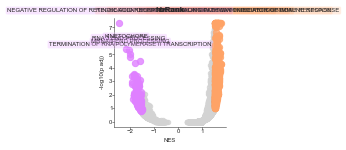

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	2.3704166666666663e-08	
--------------------------------------------------------------------------------


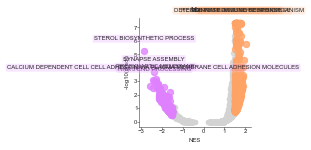

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.7254545454545453e-08	
--------------------------------------------------------------------------------


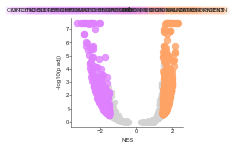

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	4.3907692307692315e-08	
--------------------------------------------------------------------------------


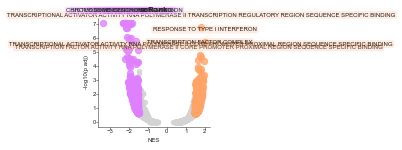

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	6.800000000000001e-09	
--------------------------------------------------------------------------------


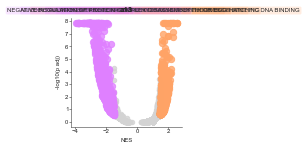

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	7.046913580246914e-09	
--------------------------------------------------------------------------------


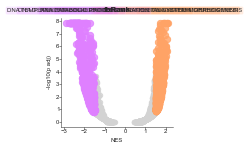

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.1890909090909094e-08	
--------------------------------------------------------------------------------


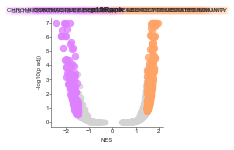

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	2.3479166666666663e-08	
--------------------------------------------------------------------------------


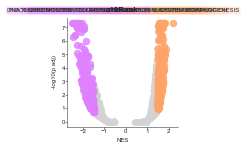

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.795638607604625e-08	
--------------------------------------------------------------------------------


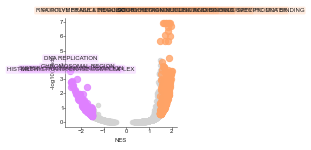

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	8.354352765535156e-08	
--------------------------------------------------------------------------------


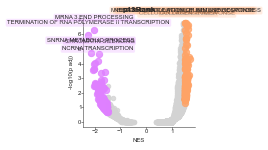

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	9.425e-09	
--------------------------------------------------------------------------------


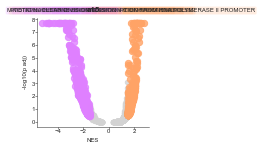

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.4957894736842104e-08	
--------------------------------------------------------------------------------


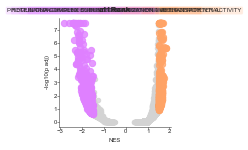

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.0137499999999999e-08	
--------------------------------------------------------------------------------


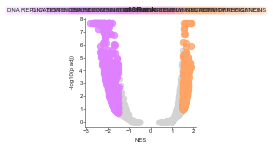

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	7.049814265637555e-07	
--------------------------------------------------------------------------------


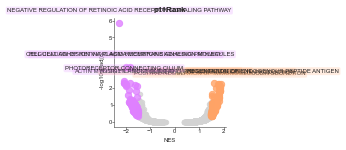

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.7692259773570684e-09	
--------------------------------------------------------------------------------


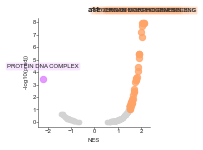

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	9.503333333333334e-08	
--------------------------------------------------------------------------------


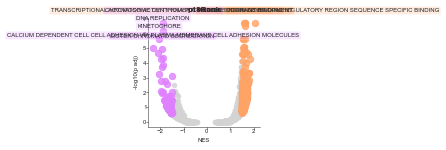

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.4764150943396234e-09	
--------------------------------------------------------------------------------


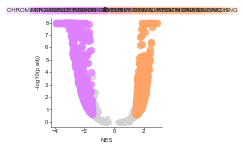

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.726363636363636e-08	
--------------------------------------------------------------------------------


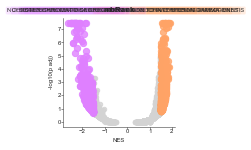

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	8.134285714285714e-09	
--------------------------------------------------------------------------------


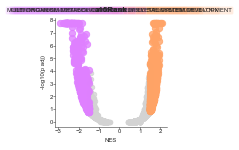

In [24]:
for f in os.listdir(fig_dir):
    if 'GSEA' in f and 'Go' in f and 'svg' not in f:
        gsea_out = pd.read_csv(fig_dir + f)
        gsea_out = gsea_out.fillna(1.0)
        volcanoplot = Volcanoplot(gsea_out, 'NES', 'padj', 'pathway', 
                                      f.split("_")[2], 'NES', '-log10(p adj)', 
                                      p_val_cutoff=1.0, max_labels=5,
                                      label_big_sig=True, log_fc_cuttoff=1.5, figsize=(2,2))
        sns.set_style("ticks")
        volcanoplot.plot()
        save_fig(f'Volcano_gsea_GO_{f.split("_")[1]}_{f.split("_")[2]}')
        plt.show()